# Further Assesment of Chosen GS Models  - Methods to Improve Model Predictions 
- models with more robust (uniform high mean or bell curve, avoid seeds with many 0% pred up results ...) are chosen
- dists are used to asses moetrics .... rather than single model values from a single seed 


In [8]:
import pandas as pd
import pickle
import random
import numpy as np
import os
import itertools
from joblib import Parallel, delayed , parallel_backend
from collections import defaultdict
import math
import torch.nn as nn
import json

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from Equations_Run_Combo_V_2 import * 
from Equations_Ensembles_Dist import (

    evaluate_binary_0_1_selective_ensemble , distribution_discovery , avg_ensemble , selective_ensemble_all_agree
)

# Import all functions
from Results_Dists_V_2 import *

# from Results_Dists_V_2_TESTING import *



FileNotFoundError: [Errno 2] No such file or directory: '/Users/cs/Desktop/Oil-LSTM-Project-2/short_dfs.pkl'

In [ ]:
import json
import pandas as pd
import copy
with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/V_05NEG_best_models_results/results_8fold_05NEG_preds_best_models_MAC_V_2.json' , 'r') as f_json:
   res_mac_val =  json.load(f_json)
with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/V_05NEG_best_models_results/results_TESTfold_05NEG_preds_best_models_MAC_V_2.json' , 'r') as f_json:
   res_mac_test =  json.load(f_json)
with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/V_05NEG_best_models_results/results_8fold_05NEG_preds_best_models_GC_V_2.json' , 'r') as f_json:
   res_gc_val =  json.load(f_json)
with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/V_05NEG_best_models_results/results_TESTfold_05NEG_preds_best_models_GC_V_2.json' , 'r') as f_json:
   res_gc_test =  json.load(f_json)

def flatten_results(result_list):
    """Flatten one list of results into a DataFrame without modifying the original."""
    flattened = []
    for entry in result_list:
        flat_entry = {k: v for k, v in entry.items() if k != "cv_sets"}
        flat_entry.update(entry["cv_sets"])
        flattened.append(flat_entry)
    return pd.DataFrame(flattened)

# Create new DataFrames for each result set
df_mac_val  = flatten_results(res_mac_val)
df_mac_test = flatten_results(res_mac_test)
df_gc_val   = flatten_results(res_gc_val)
df_gc_test  = flatten_results(res_gc_test)

dfs = [df_mac_val, df_mac_test, df_gc_val, df_gc_test]
### ---- number of up predictions made 
for df in dfs:
    no_up_list = []  
    for row in df["all_preds"]:
        flat_preds = [p for fold in row for p in fold]
        no_up_list.append(sum(p > 0.5 for p in flat_preds))
    df["no_up_preds"] = no_up_list

# ---- Crate a col that keeps track of the actual change when there was a false up pred 
for df in dfs:
        
    false_up_preds_col_list = []
    for row_raw_actuals, row_01_actuals , row_preds in zip(df["raw_actuals"] ,df["all_actuals"] , df["all_preds"]):
    
        false_up_preds_row = []
        row_raw_actuals_flattened = [p for fold in row_raw_actuals for p in fold ]
        row_01_actuals_flattened = [p for fold in row_01_actuals for p in fold ]
        row_preds_flattened = [p for fold in row_preds for p in fold]

        for entry_raw_actual,entry_01_actual , entry_pred in zip(row_raw_actuals_flattened , row_01_actuals_flattened,row_preds_flattened ):
            
            if entry_pred > 0.5 and entry_01_actual < 0.5:
                false_up_preds_row.append(round(entry_raw_actual,3)) 

        false_up_preds_col_list.append(false_up_preds_row)


    df["actuals_false_up"] = false_up_preds_col_list
# ---- Crate a col that keeps track of the actual change when there was a false up pred 

for df in dfs:
    df.rename(columns={"overall_metrics": "overall"}, inplace=True)

# ---- Flatten "parameters" dict column for each DataFrame ----
for df in (df_mac_val, df_mac_test, df_gc_val, df_gc_test):
    if "overall" in df.columns:
        params_df = pd.json_normalize(df["overall"])
        params_df.columns = [f"OA_{col}" for col in params_df.columns]
        df[params_df.columns] = params_df

df_gc_test.columns

dfs = [df_mac_val, df_mac_test, df_gc_val, df_gc_test]

for df in dfs:
    params_chosen = []
    for param_dict in df["parameters"]:
        param_dict_fix = {}
        for param_key in param_dict.keys():
            if param_key not in ['num_folds', 'end_value_train_set_fraction', 'val_set_fraction']:
                param_dict_fix[str(param_key)] = param_dict[param_key]

        params_chosen.append(str(param_dict_fix))
    
    df["params_fix"] = params_chosen


dict_fic_params = {}
for idx, p in enumerate(df_gc_test["params_fix"]):
    p_str = str(p).replace(' ','').replace("'",'').replace('  ','')
    dict_fic_params[p_str] = idx


for df in (df_mac_val, df_mac_test, df_gc_val, df_gc_test):
    param_values = []
    for p in df["params_fix"]:
        p_str = str(p).replace(' ','').replace("'",'')

        param_values.append(dict_fic_params[p_str])
    df["param_int_value"] = param_values


# Append suffix based on variable name
df_mac_val.rename(columns=lambda x: f"{x}_mac_val" if x != "params_fix" else x, inplace=True)
df_mac_test.rename(columns=lambda x: f"{x}_mac_test" if x != "params_fix" else x, inplace=True)
df_gc_val.rename(columns=lambda x: f"{x}_gc_val" if x != "params_fix" else x, inplace=True)
df_gc_test.rename(columns=lambda x: f"{x}_gc_test" if x != "params_fix" else x, inplace=True)


master_df = (
    df_mac_val
    .merge(df_mac_test, on="params_fix", how="outer")
    .merge(df_gc_val, on="params_fix", how="outer")
    .merge(df_gc_test, on="params_fix", how="outer")
)

master_df.columns = (
    master_df.columns
      .str.replace('precision', 'prec')
      .str.replace('recall', 'rec')
      .str.replace('down', '0')
      .str.replace('up', '1')
      .str.replace('accuracy', 'acc')
      .str.replace('test', 'T')
      .str.replace('val', 'V')

)


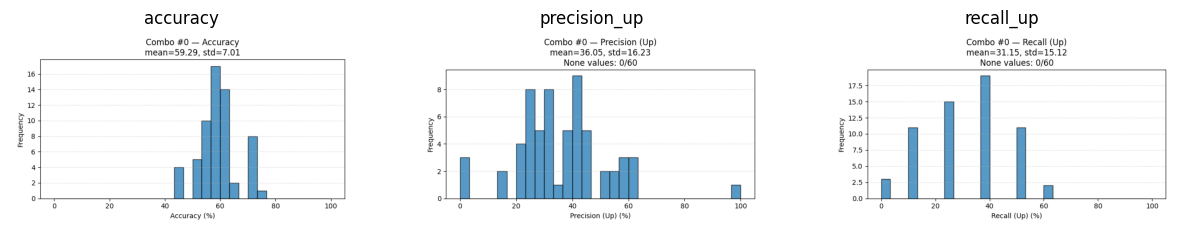

0.1


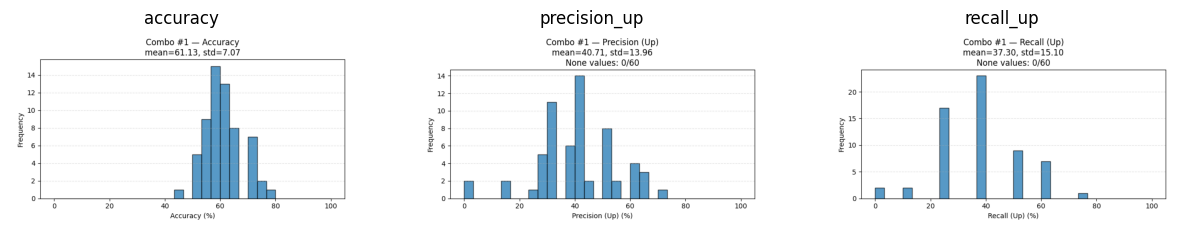

0.7


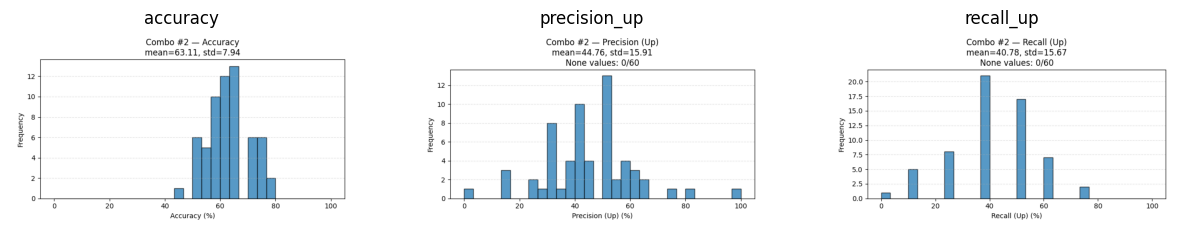

0.7


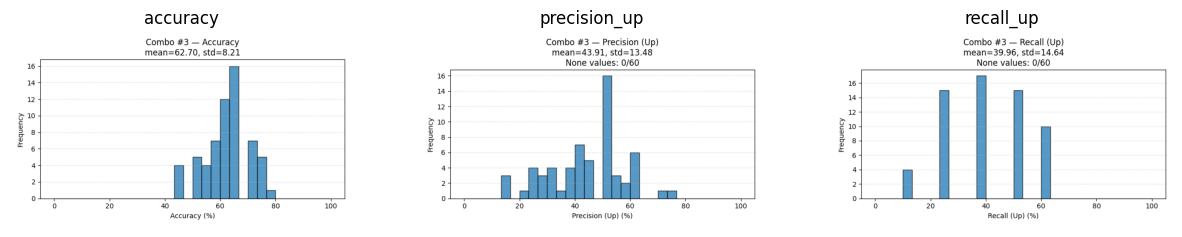

1


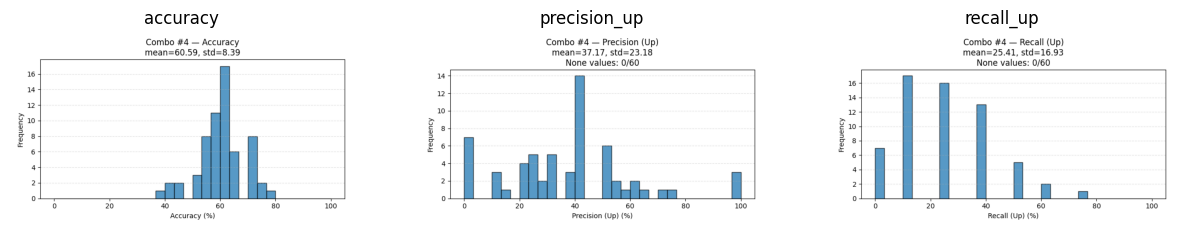

0.1


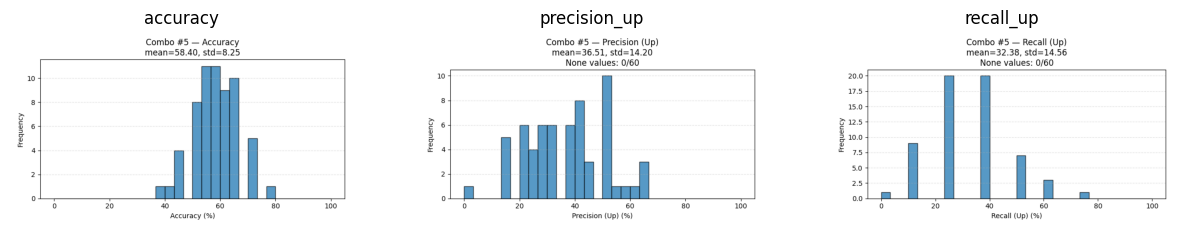

1


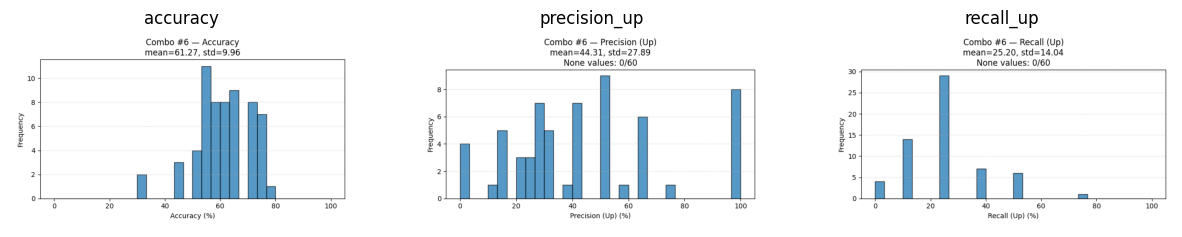

0.7


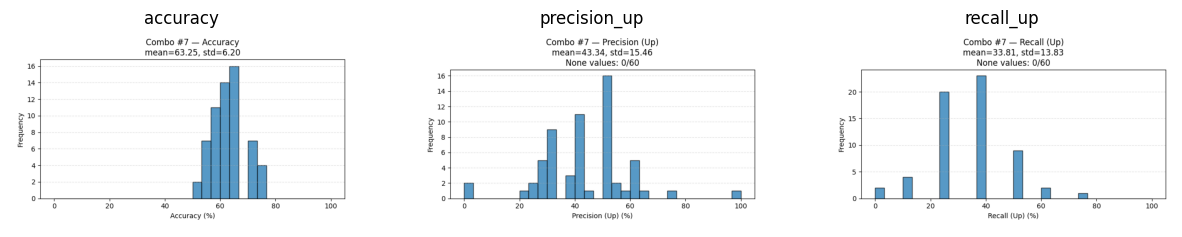

0.1


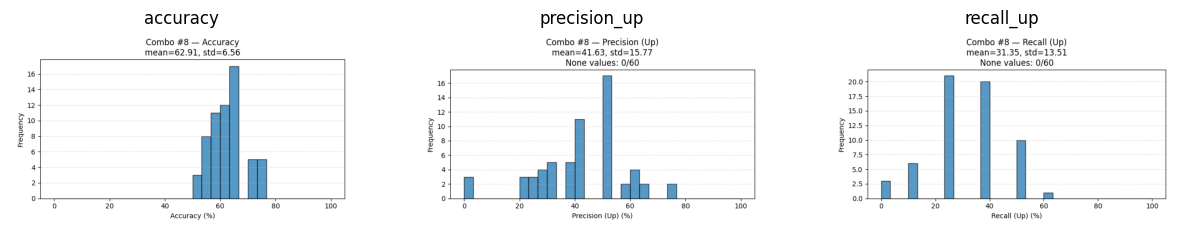

0.1


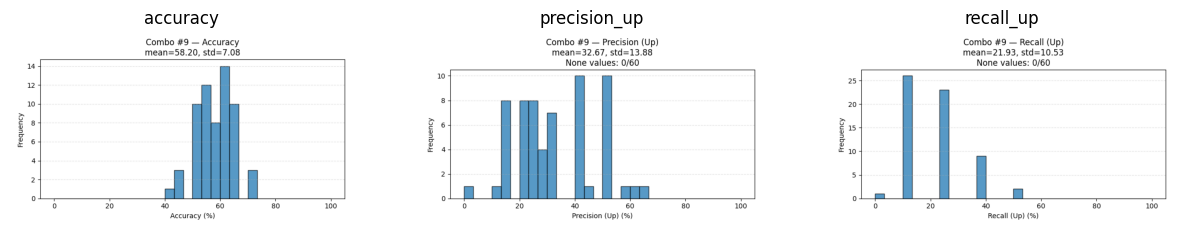

1.3


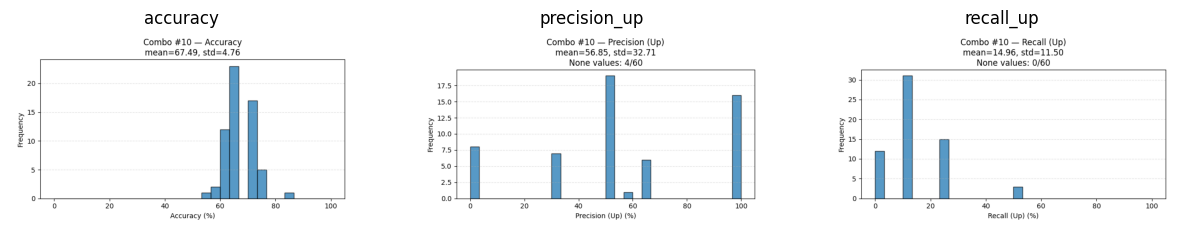

1.3


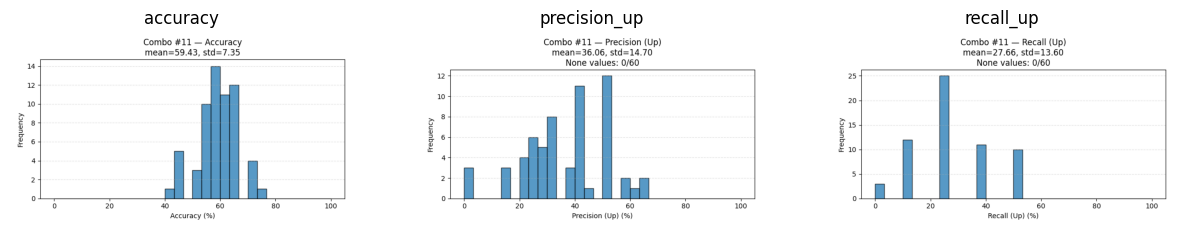

0.1


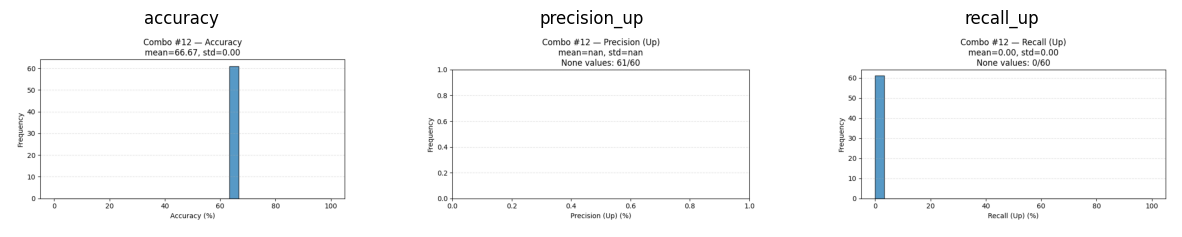

1


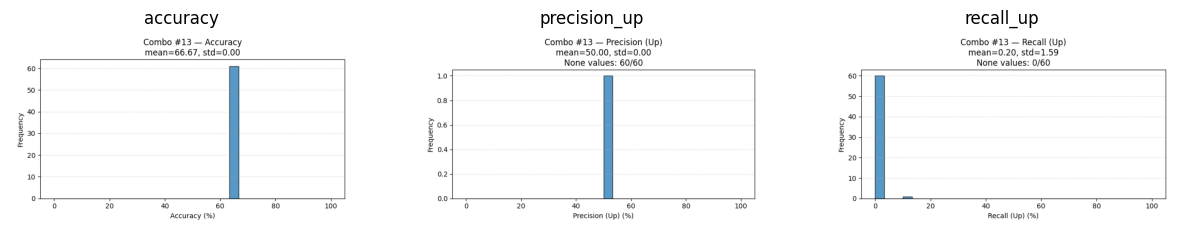

0.7


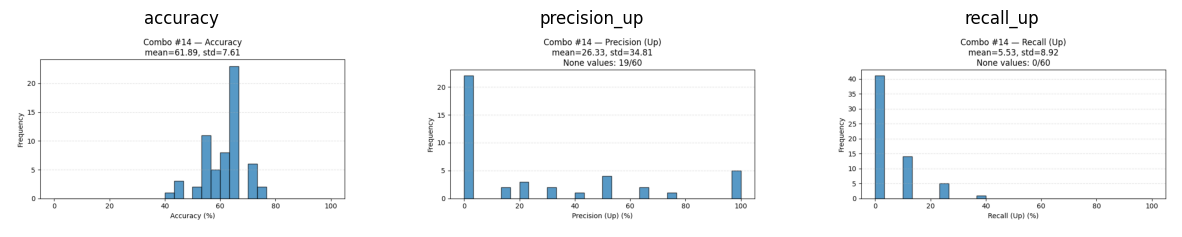

0.7


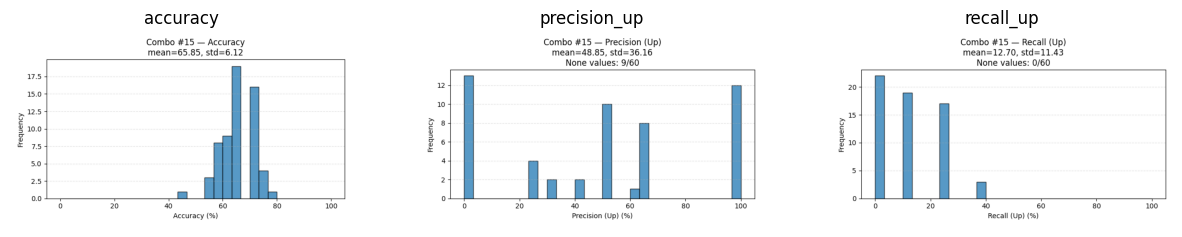

1


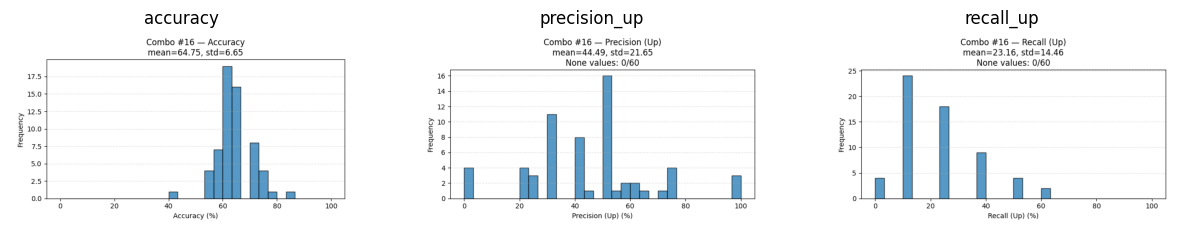

0.1


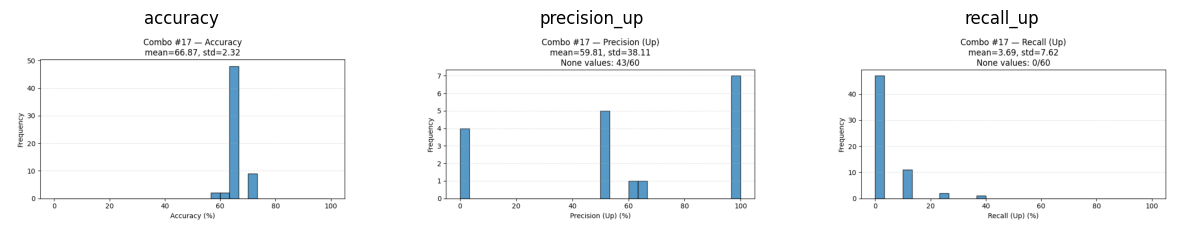

0.1


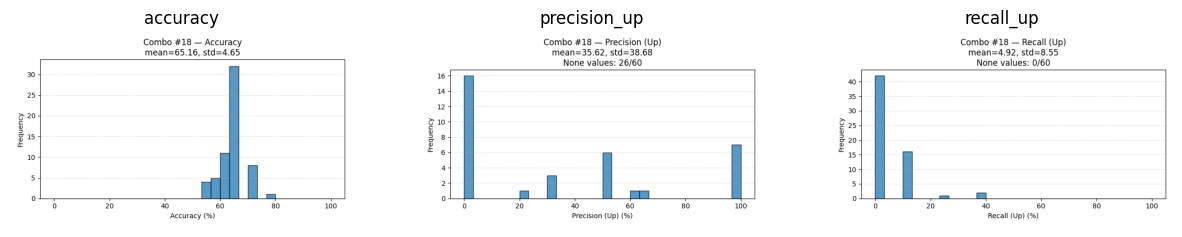

1


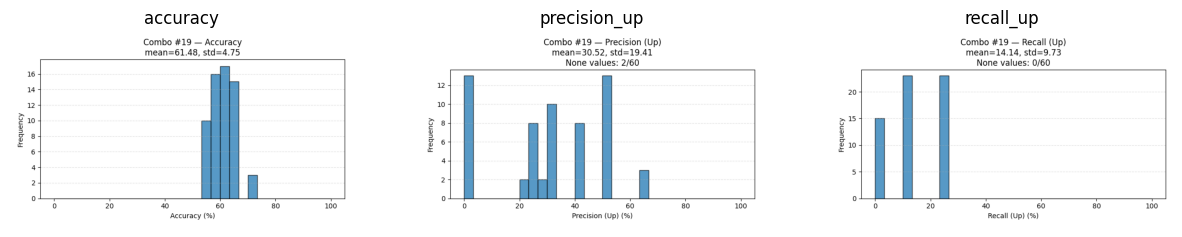

0.7


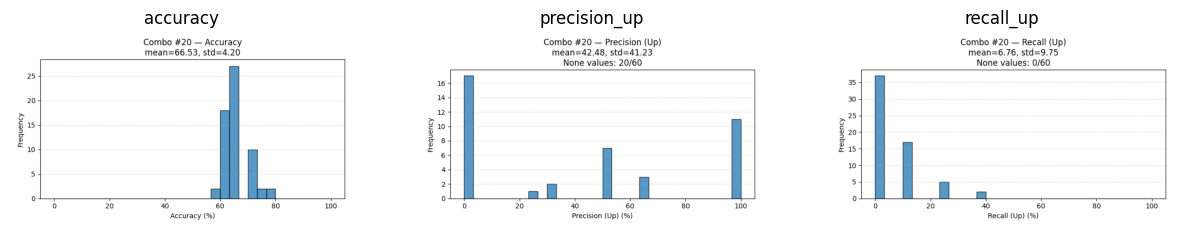

1


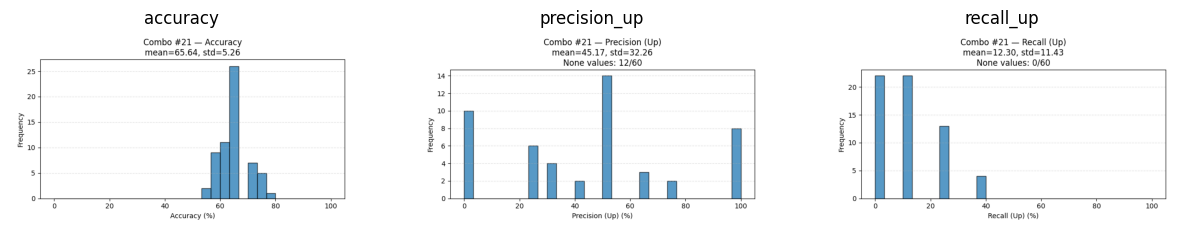

0.1


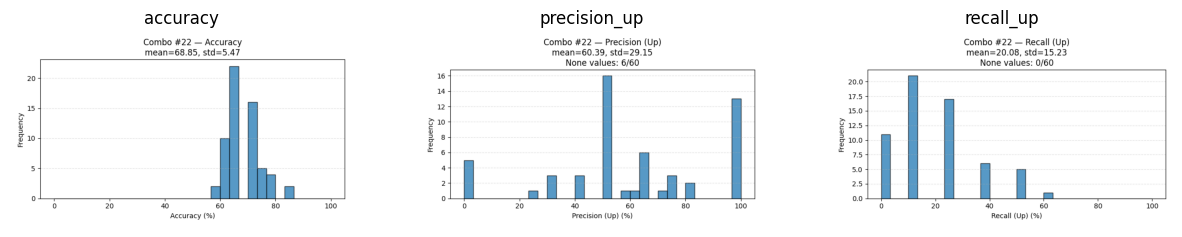

0.7


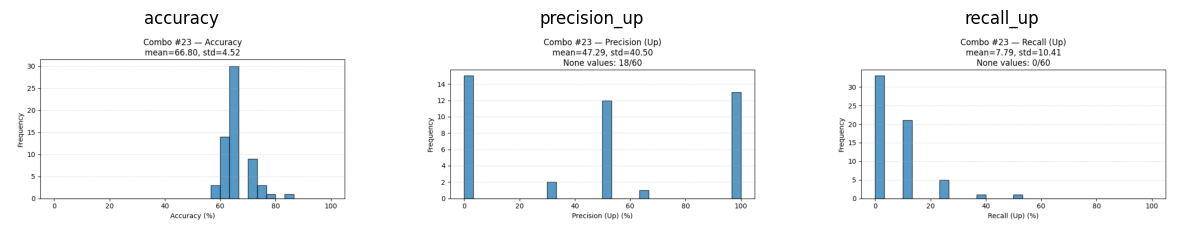

0.7


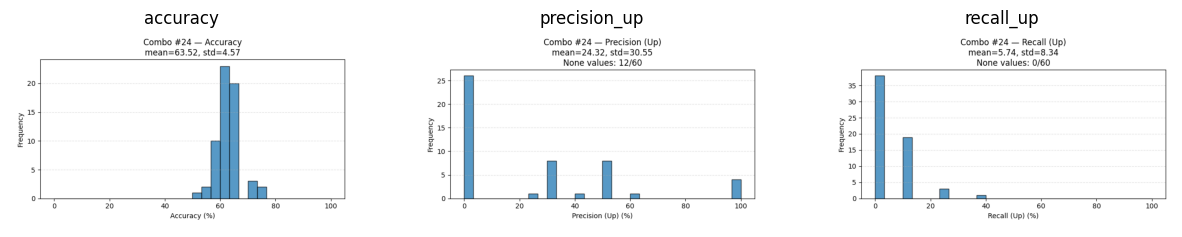

1.3


In [ ]:
#### Dist discovery results analysis - 1st filer afer GS
# PURPOSE - the idea is to measure hwo robust the model build is , as opposed to relying on one seeded mdoel ... resutls improve , there is a corr here 

import matplotlib.pyplot as plt
import base64
from io import BytesIO
import json

with open("/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/top_combos_dist_discovcery_25_combos_MAC.json") as f:
    results = json.load(f)


metrics = ['accuracy', 'precision_up', 'recall_up']

for i in results:
    fig, axs = plt.subplots(1, len(metrics), figsize=(15, 5))  # one row, 3 cols
    for ax, metric in zip(axs, metrics):
        image_data = base64.b64decode(i["plots_base64"][metric])
        img = plt.imread(BytesIO(image_data), format="png")
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(metric)
    plt.show()
    print(i["combo"]["POS_weight_multiplier"])



In [ ]:


###               ETF DATA

import pickle

with open('ETF_dfs_WTI_preds_analysis/df_HUC_T_folds_values', 'rb') as f:
    df_HUC_T_folds_values = pickle.load(f)
with open('ETF_dfs_WTI_preds_analysis/df_UCO_T_folds_values', 'rb') as f:
    df_UCO_T_folds_values = pickle.load(f)
with open('ETF_dfs_WTI_preds_analysis/df_HUC_V_folds_values', 'rb') as f:
    df_HUC_V_folds_values = pickle.load(f)
with open('ETF_dfs_WTI_preds_analysis/df_UCO_V_folds_values', 'rb') as f:
    df_UCO_V_folds_values = pickle.load(f)




with open('ETF_dfs_WTI_preds_analysis/df_HOD_T_folds_values', 'rb') as f:
    df_HOD_T_folds_values = pickle.load(f)
with open('ETF_dfs_WTI_preds_analysis/df_HOD_V_folds_values', 'rb') as f:
    df_HOD_V_folds_values = pickle.load(f)
with open('ETF_dfs_WTI_preds_analysis/df_CRUD_T_folds_values', 'rb') as f:
    df_CRUD_T_folds_values = pickle.load(f)
with open('ETF_dfs_WTI_preds_analysis/df_CRUD_V_folds_values', 'rb') as f:
    df_CRUD_V_folds_values = pickle.load(f)
with open('ETF_dfs_WTI_preds_analysis/df_USO_T_folds_values', 'rb') as f:
    df_USO_T_folds_values = pickle.load(f)
with open('ETF_dfs_WTI_preds_analysis/df_USO_V_folds_values', 'rb') as f:
    df_USO_V_folds_values = pickle.load(f)


In [1]:
import json
## NOTE - FIX - one of the params has been repeated in the H and L sets , will be kept in the L set only - this is a mistake made
#  when the models were being trained 


# Load data
with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/top_combos_dist_discovcery_low_high_preforming_models_V_T/top_combos_dist_discovcery_low_prec_seeds_results_MAC_V.json', 'r') as f_json:
   res_mac_L_val =  json.load(f_json)

with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/top_combos_dist_discovcery_low_high_preforming_models_V_T/top_combos_dist_discovcery_high_prec_seeds_results_MAC_V.json', 'r') as f_json:
   res_mac_H_val =  json.load(f_json)

with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/top_combos_dist_discovcery_low_high_preforming_models_V_T/top_combos_dist_discovcery_low_prec_seeds_results_MAC_T.json', 'r') as f_json:
   res_mac_L_test =  json.load(f_json)

with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/top_combos_dist_discovcery_low_high_preforming_models_V_T/top_combos_dist_discovcery_high_prec_seeds_results_MAC_T.json', 'r') as f_json:
   res_mac_H_test =  json.load(f_json)


res_mac_H_val = [i for i in res_mac_H_val if i["parameters"]["seed_num"] != 42]
res_mac_H_test = [i for i in res_mac_H_test if i["parameters"]["seed_num"] != 42]

# print("res_mac_L_val")
# for i in res_mac_L_val:
#    print(i["parameters"]["seed_num"])
# print("----------")
# print("res_mac_H_val")
# for i in res_mac_H_val:
#    print(i["parameters"]["seed_num"])
# print("----------")
# print("res_mac_L_test")
# for i in res_mac_L_test:
#    print(i["parameters"]["seed_num"])
# print("----------")
# print("res_mac_H_test")
# for i in res_mac_H_test:
#    print(i["parameters"]["seed_num"])
# print("----------")



In [ ]:


etf_data_T = {
    'HUC': df_HUC_T_folds_values,
    'UCO': df_UCO_T_folds_values,
    'HOD': df_HOD_T_folds_values,
    'CRUD': df_CRUD_T_folds_values,
    'USO': df_USO_T_folds_values
}

etf_data_V = {
    'HUC': df_HUC_V_folds_values,
    'UCO': df_UCO_V_folds_values,
    'HOD': df_HOD_V_folds_values,
    'CRUD': df_CRUD_V_folds_values,
    'USO': df_USO_V_folds_values
}


def add_etf_values(data , etf_data): 

    for res in data:
        for key in etf_data.keys():
            res[f"{key}_values"] = etf_data[key]


# Add threshold metrics
names_all = [res_mac_L_val, res_mac_H_val, res_mac_L_test, res_mac_H_test]

names_test = [res_mac_L_test, res_mac_H_test]
names_val = [res_mac_L_val, res_mac_H_val]



for data in names_val:
    add_etf_values(data, etf_data_V)
for data in names_test:
    add_etf_values(data, etf_data_T)


for data in names_all:
    add_threshold_metrics(data, threshold=.7)



In [ ]:


# Create DataFrames
df_mac_L_val = flatten_results(res_mac_L_val)
df_mac_H_val = flatten_results(res_mac_H_val)
df_mac_L_test = flatten_results(res_mac_L_test)
df_mac_H_test = flatten_results(res_mac_H_test)

# Add H/L labels
df_mac_L_val['H_L'] = 'L'
df_mac_H_val['H_L'] = 'H'
df_mac_L_test['H_L'] = 'L'
df_mac_H_test['H_L'] = 'H'

dfs = [df_mac_L_val, df_mac_H_val, df_mac_L_test, df_mac_H_test]

# Add various metrics
add_up_prediction_counts(dfs)
add_false_correct_up_stats(dfs)
flatten_metrics_columns(dfs)


master_df = process_parameters_and_merge(dfs)


# print(master_df.columns)

# master_df[["parameters_mac_T", "parameters_mac_V"]]


In [ ]:


display(master_df[[
    "OA_prec_1_mac_V", "OA_rec_1_mac_V", "no_1_preds_mac_V", "actuals_false_1_mac_V", "HOD_actuals_false_1_mac_V","UCO_actuals_false_1_mac_V",
    'false_1_preds_mac_V', 'correct_1_preds_mac_V', "HOD_actuals_correct_1_mac_V", 'actuals_correct_1_mac_V',
    "OA_prec_1_mac_T", "OA_rec_1_mac_T", "no_1_preds_mac_T", "actuals_false_1_mac_T", "HOD_actuals_false_1_mac_T",
    'false_1_preds_mac_T', 'correct_1_preds_mac_T', 'actuals_correct_1_mac_T', "HOD_actuals_correct_1_mac_T",
    "H_L_mac_T", "H_L_mac_V", "param_int_Vue_mac_T"
]].round(4))


display(master_df[[
    "OA_thresh_prec_1_thresh_mac_V", "OA_thresh_rec_1_thresh_mac_V", "no_1_preds_thresh_mac_V", 
    "actuals_false_1_thresh_mac_V", "HOD_actuals_false_1_thresh_mac_V", "UCO_actuals_false_1_thresh_mac_V", 'false_1_preds_thresh_mac_V', 'correct_1_preds_thresh_mac_V', 
    'actuals_correct_1_thresh_mac_V', "HOD_actuals_correct_1_thresh_mac_V",
    "OA_thresh_prec_1_thresh_mac_T", "OA_thresh_rec_1_thresh_mac_T", "no_1_preds_thresh_mac_T", 
    "actuals_false_1_thresh_mac_T", "HOD_actuals_false_1_thresh_mac_T", 'false_1_preds_thresh_mac_T', 'correct_1_preds_thresh_mac_T', 
    'actuals_correct_1_thresh_mac_T' , "HOD_actuals_correct_1_mac_T"
]].round(4))


# for L , params in zip(master_df["actuals_false_1_mac_V"] , master_df["parameters_mac_V"]):
#     for val in L:
#         if val > 0.1:
#             print(params )
#             print(val)


OA_prec_1_mac_T  OA_rec_1_mac_T  no_1_preds_mac_T  \
0           60.0000            60.0                 5   
1           66.6667            40.0                 3   
2          100.0000            20.0                 1   
3               NaN             0.0                 0   
4           50.0000            80.0                 8   
5            0.0000             0.0                 5   
6           50.0000            20.0                 2   
7           66.6667            40.0                 3   
8          100.0000            20.0                 1   
9           50.0000            20.0                 2   
10          50.0000            20.0                 2   
11          50.0000            20.0                 2   
12          50.0000            20.0                 2   
13         100.0000            40.0                 2   
14           0.0000             0.0                 1   

                         actuals_false_1_mac_T  \
0                             [0.1432, 0.0603]   
1                                    [-0.0224]   
2                                           []   
3                                           []   
4            [0.1432, 0.0603, 0.1024, -0.0485]   
5   [-0.0224, 0.1432, 0.0603, 0.1024, -0.0485]   
6                                    [-0.0224]   
7                                    [-0.0224]   
8                                           []   
9                                    [-0.0224]   
10                                   [-0.0224]   
11                                   [-0.0224]   
12                                   [-0.0224]   
13                                          []   
14                                    [0.1432]   

                       HOD_actuals_false_1_mac_T  \
0                             [-0.2349, -0.1754]   
1                                      [-0.0994]   
2                                             []   
3                                             []   
4            [-0.2349, -0.1754, -0.2302, 0.0269]   
5   [-0.0994, -0.2349, -0.1754, -0.2302, 0.0269]   
6                                      [-0.0994]   
7                                      [-0.0994]   
8                                             []   
9                                      [-0.0994]   
10                                     [-0.0994]   
11                                     [-0.0994]   
12                                     [-0.0994]   
13                                            []   
14                                     [-0.2349]   

                         false_1_preds_mac_T            correct_1_preds_mac_T  \
0                           [0.5053, 0.5134]         [0.5325, 0.5827, 0.6992]   
1                                   [0.6995]                 [0.5864, 0.6149]   
2                                         []                         [0.5491]   
3                                         []                               []   
4           [0.7354, 0.7476, 0.6734, 0.5682]  [0.6175, 0.579, 0.6052, 0.6275]   
5   [0.5748, 0.7035, 0.6556, 0.6205, 0.7691]                               []   
6                                   [0.9981]                         [0.7326]   
7                                   [0.9868]                 [0.9072, 0.9998]   
8                                         []                            [1.0]   
9                                   [0.5097]                         [0.9811]   
10                                  [0.9976]                         [0.5589]   
11                                  [0.9994]                         [0.9891]   
12                                  [0.7803]                         [0.9292]   
13                                        []                 [0.7603, 0.5057]   
14                                  [0.5469]                               []   

                 actuals_correct_1_mac_T       HOD_actuals_correct_1_mac_T  \
0            [-0.0768, -0.0515, -0.1039]          [0.0667, 0.0101, 0.1502]   
1   

OA_thresh_prec_1_thresh_mac_V  OA_thresh_rec_1_thresh_mac_V  \
0                        100.0000                          25.0   
1                        100.0000                          12.5   
2                        100.0000                          25.0   
3                        100.0000                          25.0   
4                             NaN                           0.0   
5                          0.0000                           0.0   
6                         75.0000                          37.5   
7                         66.6667                          50.0   
8                        100.0000                          37.5   
9                         66.6667                          50.0   
10                        66.6667                          50.0   
11                        50.0000                          12.5   
12                        71.4286                          62.5   
13                        80.0000                          50.0   
14                       100.0000                          50.0   

    no_1_preds_thresh_mac_V actuals_false_1_thresh_mac_V  \
0                         2                           []   
1                         1                           []   
2                         2                           []   
3                         2                           []   
4                         0                           []   
5                         1                     [0.1862]   
6                         4                     [0.0587]   
7                         6             [0.0551, 0.0587]   
8                         3                           []   
9                         6             [0.0551, 0.1615]   
10                        6             [0.0587, 0.1615]   
11                        2                     [0.0551]   
12                        7             [0.1897, 0.1066]   
13                        5                    [-0.0099]   
14                        4                           []   

   HOD_actuals_false_1_thresh_mac_V UCO_actuals_false_1_thresh_mac_V  \
0                                []                               []   
1                                []                               []   
2                                []                               []   
3                                []                               []   
4                                []                               []   
5                         [-0.3091]                         [0.3833]   
6                         [-0.1521]                         [0.1138]   
7                [-0.0504, -0.1521]                 [0.0899, 0.1138]   
8                                []                               []   
9                [-0.0504, -0.2673]                 [0.0899, 0.2556]   
10               [-0.1521, -0.2673]                 [0.1138, 0.2556]   
11                        [-0.0504]                         [0.0899]   
12               [-0.2036, -0.1949]                  [0.299, 0.1932]   
13                        [-0.0395]                         [0.0037]   
14                               []                               []   

   false_1_preds_thresh_mac_V              correct_1_preds_thresh_mac_V  \
0                          []                          [0.7344, 0.9469]   
1                          []                                  [0.8816]   
2                          []                          [0.8135, 0.9791]   
3                          []                           [0.852, 0.8788]   
4                          []                                        []   
5                    [0.7192]                                        []   
6                    [0.9995]                  [0.9115, 0.9959, 0.9998]   
7               [0.9999, 1.0]          [0.9989, 0.9998, 0.9999, 0.9247]   
8                          []                  [0.7063, 0.9946, 0.8154]   
9            [0.9991, 0.9139]          [0.9996, 0.9994, 0.9964, 0.9

In [ ]:

###                                      CORR FOR A PAIR SET OF PARAMS 

import numpy as np
from itertools import combinations
from collections import Counter
import random

random.seed(42)

n_random = 20
n_random_2 = 20
#  ----------------- Groups of size 2
groups_2_neg03_01 = get_model_groups_in_corr_range(master_df, "mac", "V", (-0.3, 0.1), group_size=2) 
groups_2_01_03    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.1, 0.3), group_size=2) 
groups_2_03_05    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.3, 0.5), group_size=2) 
# groups_2_04_07    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.6, 0.7), group_size=2) 

# Randomly select 10 from each group
random_2_neg03_01 = random.sample(groups_2_neg03_01, min(n_random_2, len(groups_2_neg03_01))) if groups_2_neg03_01 else []
random_2_01_03    = random.sample(groups_2_01_03, min(n_random_2, len(groups_2_01_03))) if groups_2_01_03 else []
random_2_03_05    = random.sample(groups_2_03_05, min(n_random_2, len(groups_2_03_05))) if groups_2_03_05 else []
# random_2_04_07    = random.sample(groups_2_04_07, min(n_random_2, len(groups_2_04_07))) if groups_2_04_07 else []

# ------------------ Groups of size 3
groups_3_neg03_01 = get_model_groups_in_corr_range(master_df, "mac", "V", (-0.3, 0.1), group_size=3)
groups_3_01_03    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.1, 0.3), group_size=3) 
groups_3_03_05    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.3, 0.5), group_size=3) 
# groups_3_04_07    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.6, 0.7), group_size=3)

# Randomly select 10 from each group
random_3_neg03_01 = random.sample(groups_3_neg03_01, min(n_random, len(groups_3_neg03_01))) if groups_3_neg03_01 else []
random_3_01_03    = random.sample(groups_3_01_03, min(n_random, len(groups_3_01_03))) if groups_3_01_03 else []
random_3_03_05    = random.sample(groups_3_03_05, min(n_random, len(groups_3_03_05))) if groups_3_03_05 else []
# random_3_04_07    = random.sample(groups_3_04_07, min(n_random, len(groups_3_04_07))) if groups_3_04_07 else []
# # ------------------ Groups of size 4
# groups_4_neg01_00 = get_model_groups_in_corr_range(master_df, "mac", "V", (-0.1, 0.0), group_size=4)
# groups_4_00_02    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.0, 0.2), group_size=4) 
# groups_4_02_04    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.2, 0.4), group_size=4)
# groups_4_04_07    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.4, 0.7), group_size=4)

# # Randomly select 10 from each group
# random_4_neg01_00 = random.sample(groups_4_neg01_00, min(n_random, len(groups_4_neg01_00))) if groups_4_neg01_00 else []
# random_4_00_02    = random.sample(groups_4_00_02, min(n_random, len(groups_4_00_02))) if groups_4_00_02 else []
# random_4_02_04    = random.sample(groups_4_02_04, min(n_random, len(groups_4_02_04))) if groups_4_02_04 else []
# random_4_04_07    = random.sample(groups_4_04_07, min(n_random, len(groups_4_04_07))) if groups_4_04_07 else []

# ------------------- CHECK 
print("Size 2 groups:")
print(len(groups_2_neg03_01))
print(len(groups_2_01_03))
print(len(groups_2_03_05))
# print(len(random_2_04_07))
print('----')
print("Size 3 groups:")
print(len(groups_3_neg03_01))
print(len(groups_3_01_03))
print(len(groups_3_03_05))
# print(len(random_3_04_07))
print('----')
# print("Size 4 groups:")
# print(len(random_4_neg01_00))
# print(len(random_4_00_02))
# print(len(random_4_02_04))
# print(len(random_4_04_07))


# Create pair parameter maps using the function
pair_params_map_2_neg03_01 = create_pair_params_map(random_2_neg03_01, master_df, num_models=2, data_type="V")
pair_params_map_2_01_03 = create_pair_params_map(random_2_01_03, master_df, num_models=2, data_type="V")
pair_params_map_2_03_05 = create_pair_params_map(random_2_03_05, master_df, num_models=2, data_type="V")

pair_params_map_3_neg03_01 = create_pair_params_map(random_3_neg03_01, master_df, num_models=3, data_type="V")
pair_params_map_3_01_03 = create_pair_params_map(random_3_01_03, master_df, num_models=3, data_type="V")
pair_params_map_3_03_05 = create_pair_params_map(random_3_03_05, master_df, num_models=3, data_type="V")




Size 2 groups:
25
26
32
----
Size 3 groups:
3
4
13
----


In [ ]:
# res["detailed_results"]


# #print group combos per group corr 
# for group , vals in res['detailed_results'].items():
#     print(f"Group: {group}")
#     for i in vals:
#         print(i['combo_numbers'])

---
# Correlation dist discovery - Within a model  & then across models - NOTE not sure if dist of corr across mdoels (diff seeds) will be woth the compute  
---

- The idea is to choose models that are consistently highly correlated accross seeds 
- Then we check if pairs are correlated with a peark in the dist across diff seeds 

- so first check that the corr is stable for the func (near 1) , then check the the pariwise corr across 2 funcs is stable across diff seeds , LAST we see if stability in the two processes means stability in the test set in terms of the corr being similar 


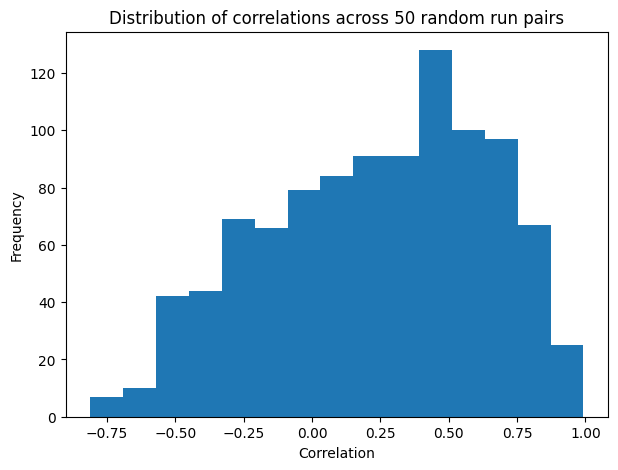

In [ ]:
###### PURPOSE - THIS IS TO CHECK THE CORRELATION BETWEEN DIFFERENT RUNS OF THE SAME MODEL - WE WOULD HOPE TAHT THE CORR IS HIGH WHCIH SEEMS TO BE THE CASE


with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/single_param_corr_results.json', 'r') as f_json:
    res = json.load(f_json)

import random
from itertools import combinations
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# # --- helpers ---

def corr_for_pair(run_i, run_j , use_spearman = False):
    """Pearson correlation between two runs' flattened predictions."""
    xi = [i for part in run_i['all_preds'] for i in part]
    xj = [i for part in run_j['all_preds'] for i in part]
    n = min(len(xi), len(xj))  # just in case lengths differ
    if n == 0:
        return np.nan
    # align (assumes same ordering of observations across runs)
    xi = xi[:n]
    xj = xj[:n]
    if use_spearman:
        c = spearmanr(xi, xj).correlation
    else:
        c = np.corrcoef(xi, xj)[0, 1]
    return float(c)

# --- main ---

# RES: list of results (each like the dicts you showed)
N = len(res)
all_pairs = list(combinations(range(N), 2))

picked_pairs = random.sample(all_pairs, 1000)

correlations = []
for i, j in picked_pairs:

    r = corr_for_pair(res[i], res[j] , use_spearman=True)
    if not np.isnan(r):
        correlations.append(r)

# plot the distribution
plt.figure(figsize=(7,5))
plt.hist(correlations, bins=15)  
plt.xlabel("Correlation")
plt.ylabel("Frequency")
plt.title("Distribution of correlations across 50 random run pairs")
plt.show()

# If you want the raw list too:
# correlations[:5], len(correlations)
# len(all_pairs)

---
# Initial Analytics 
### - purpose is to discover if the correlation between functions tends to remain similar in V and T set
---


In [ ]:



import json 
## NOTE - FIX - one of the params has been repeated in the H and L sets , will be kept in the L set only - this is a mistake made
#  when the models were being trained 
with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/top_combos_dist_discovcery_low_high_preforming_models_V_T/top_combos_dist_discovcery_low_prec_seeds_results_MAC_T.json' , 'r') as f_json:
   mac_T_L =  json.load(f_json)
with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/top_combos_dist_discovcery_low_high_preforming_models_V_T/top_combos_dist_discovcery_low_prec_seeds_results_MAC_V.json' , 'r') as f_json:
   mac_V_L =  json.load(f_json)
with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/top_combos_dist_discovcery_low_high_preforming_models_V_T/top_combos_dist_discovcery_high_prec_seeds_results_MAC_T.json' , 'r') as f_json:
   mac_T_H =  json.load(f_json)
with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/top_combos_dist_discovcery_low_high_preforming_models_V_T/top_combos_dist_discovcery_high_prec_seeds_results_MAC_V.json' , 'r') as f_json:
   mac_V_H =  json.load(f_json)



etf_data_T = {
    'HUC': df_HUC_T_folds_values,
    'UCO': df_UCO_T_folds_values,
    'HOD': df_HOD_T_folds_values,
    'CRUD': df_CRUD_T_folds_values,
    'USO': df_USO_T_folds_values
}

etf_data_V = {
    'HUC': df_HUC_V_folds_values,
    'UCO': df_UCO_V_folds_values,
    'HOD': df_HOD_V_folds_values,
    'CRUD': df_CRUD_V_folds_values,
    'USO': df_USO_V_folds_values
}


def add_etf_values(data , etf_data): 

    for res in data:
        for key in etf_data.keys():
            res[f"{key}_values"] = etf_data[key]


# Add threshold metrics
names_all = [mac_T_L, mac_V_L, mac_T_H, mac_V_H]

names_test = [mac_T_L, mac_V_L]
names_val = [mac_T_H, mac_V_H]



for data in names_val:
    add_etf_values(data, etf_data_V)
for data in names_test:
    add_etf_values(data, etf_data_T)


for data in names_all:
    add_threshold_metrics(data, threshold=.7)



mac_V_H = [i for i in mac_V_H if i["parameters"]["seed_num"] != 42] 
mac_T_H = [i for i in mac_T_H if i["parameters"]["seed_num"] != 42]

mac_T = mac_T_L + mac_T_H 
mac_V = mac_V_L + mac_V_H


# names_all = [mac_T_L, mac_V_L, mac_T_H, mac_V_H]
# for data in names_all:
#     add_threshold_metrics(data, threshold=.7)


# mac_V_H = [i for i in mac_V_H if i["parameters"]["seed_num"] != 42] ; mac_T_H = [i for i in mac_T_H if i["parameters"]["seed_num"] != 42]
# mac_T = mac_T_L + mac_T_H ; mac_V = mac_V_L + mac_V_H


FileNotFoundError: [Errno 2] No such file or directory: '/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/top_combos_dist_discovcery_low_high_preforming_models_V_T/top_combos_dist_discovcery_low_prec_seeds_results_MAC_T.json'

In [ ]:

# Create new DataFrames for each result set
df_mac_val  = flatten_results(mac_V)
df_mac_test  = flatten_results(mac_T)

dfs = [df_mac_val, df_mac_test]
# Add various metrics
add_up_prediction_counts(dfs)
add_false_correct_up_stats(dfs)
flatten_metrics_columns(dfs)

master_df = process_parameters_and_merge(dfs)


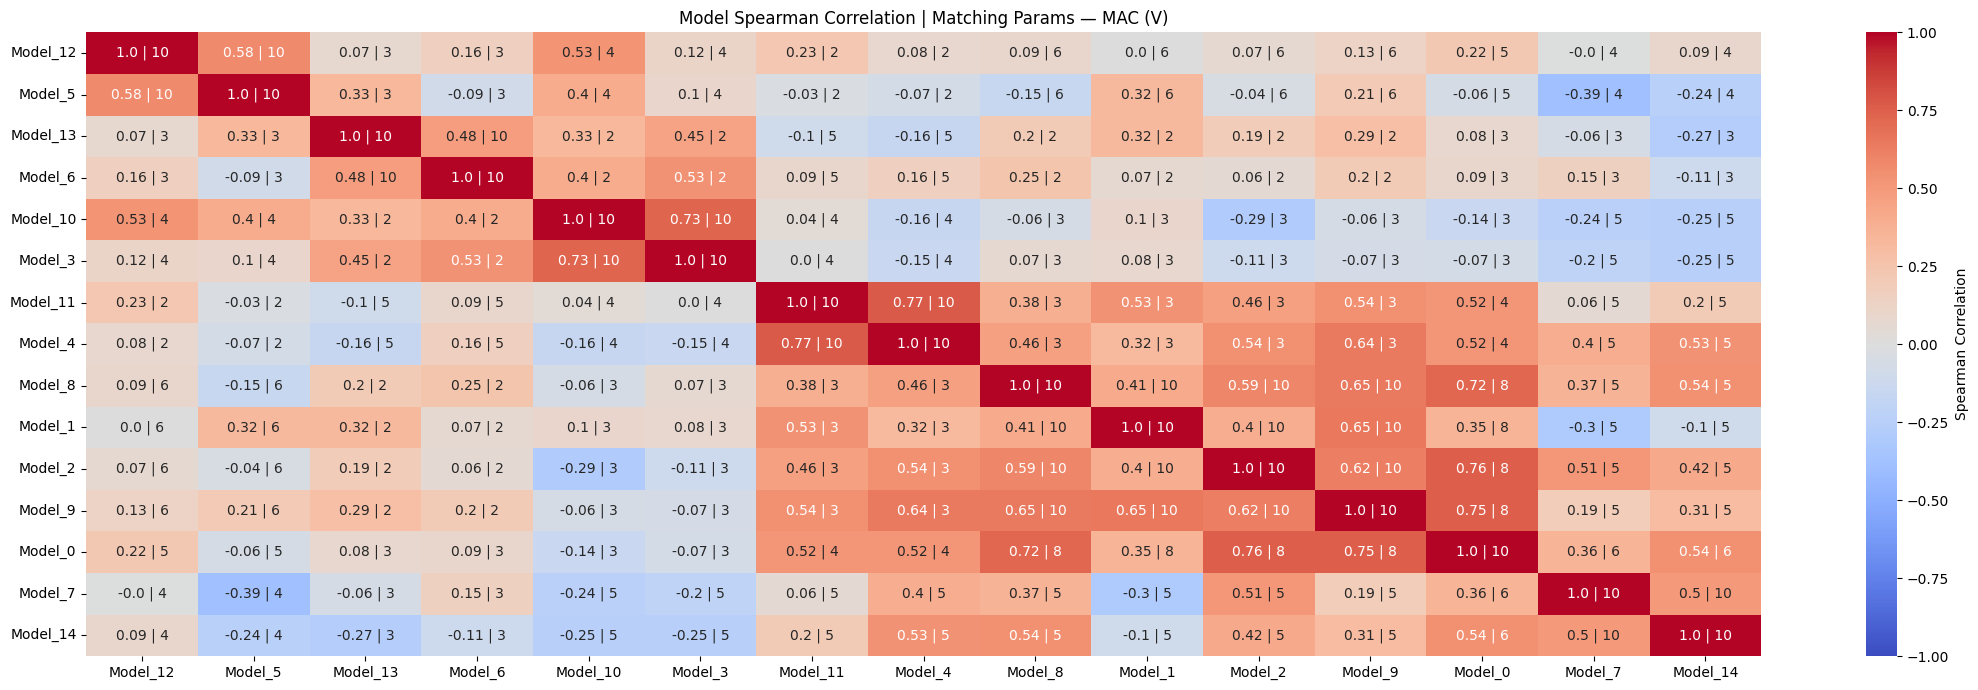

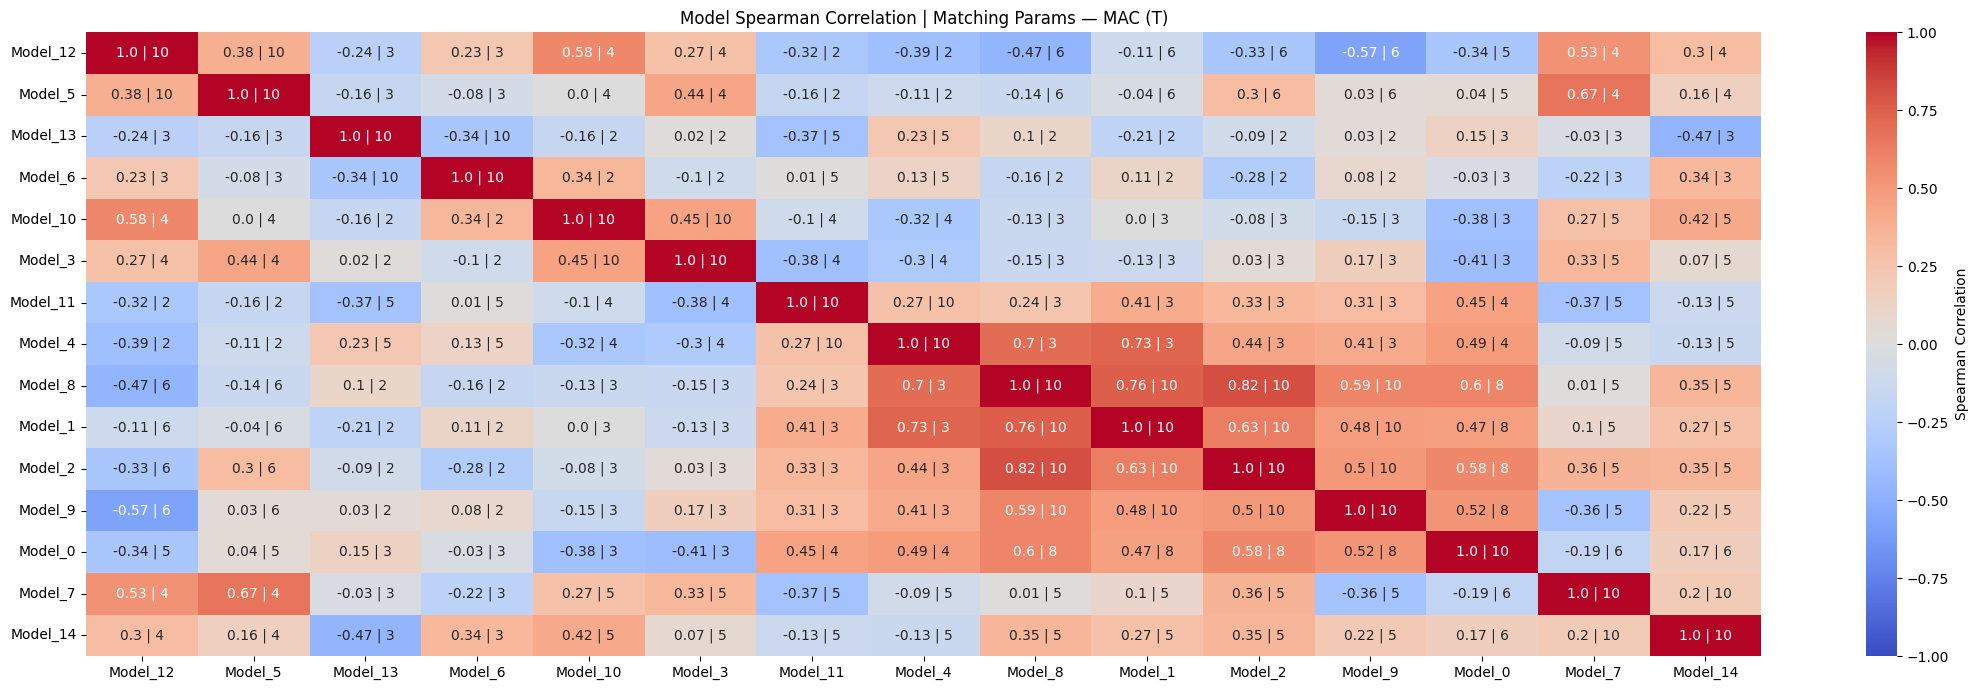

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def plot_model_corr(master_df, machine="mac", set_type="V", use_spearman=True):
    """
    Plots correlation and matching-parameter counts for models
    from a given machine ('mac' or 'gc') and set type ('V' or 'T'),
    using the param_int_Vue column as the unique model ID.
    
    Returns: List of tuples with (model_pair, same_params_count, correlation)
    """
    # Dynamic column names
    preds_col  = f"all_preds_{machine}_{set_type}"
    params_col = f"parameters_{machine}_{set_type}"
    id_col     = f"param_int_Vue_{machine}_{set_type}"  # unique model integer

    # Extract relevant rows
    block = master_df[[preds_col, params_col, id_col]].reset_index(drop=True)
    if block.empty:
        raise ValueError(f"No data found for machine '{machine}' and set '{set_type}'.")

    # 1. Flatten predictions and get model IDs
    all_preds_list = []
    model_ids = []
    
    for idx, preds in enumerate(block[preds_col]):
        flat = [p for fold in preds for p in fold]  # flatten folds
        all_preds_list.append(flat)
        model_ids.append(int(block.iloc[idx][id_col]))

    labels = [f"Model_{mid}" for mid in model_ids]
    n_models = len(all_preds_list)

    # 2. Correlation matrix - unified approach
    corr = np.zeros((n_models, n_models))
    
    for i in range(n_models):
        for j in range(n_models):
            if i <= j:  # Calculate only once for each pair
                if use_spearman:
                    rho, _ = spearmanr(all_preds_list[i], all_preds_list[j])
                else:
                    rho = np.corrcoef(all_preds_list[i], all_preds_list[j])[0, 1]
                corr[i, j] = rho
                corr[j, i] = rho  # Symmetric matrix

    corr_df = pd.DataFrame(corr, index=labels, columns=labels)

    # 3. Matching parameter counts
    keys_to_check = [
        "learning_rate", "num_epochs", "batch_size", "lag",
        "num_layers", "input_size", "use_rolling_fixed_train_size",
        "hidden_size", "use_class_weighting", "use_dropout"
    ]
    params_list = block[params_col].tolist()
    match_counts = np.zeros((n_models, n_models), dtype=int)

    for i in range(n_models):
        for j in range(n_models):
            p1, p2 = params_list[i], params_list[j]
            if not isinstance(p1, dict) or not isinstance(p2, dict):
                continue
            match_counts[i, j] = sum(p1.get(k) == p2.get(k) for k in keys_to_check)

    match_df = pd.DataFrame(match_counts, index=labels, columns=labels)

    # 4. Annotated heatmap
    annot = corr_df.round(2).astype(str) + " | " + match_df.astype(str)
    
    correlation_type = "Spearman" if use_spearman else "Pearson"
    
    plt.figure(figsize=(22, 7))
    sns.heatmap(
        corr_df,
        annot=annot,
        fmt="",
        cmap="coolwarm",
        vmin=-1, vmax=1,
        cbar_kws={'label': f'{correlation_type} Correlation'}
    )
    plt.title(f"Model {correlation_type} Correlation | Matching Params — {machine.upper()} ({set_type})")
    plt.tight_layout()
    plt.show()

    # 5. Create return data: list of tuples (model_pair, same_params, correlation)
    return_data = {}
    for i in range(n_models):
        for j in range(i + 1, n_models):  # Only unique pairs, avoid self-comparisons and duplicates
            model_pair = (model_ids[i], model_ids[j])
            same_params = match_counts[i, j]
            correlation = corr[i, j]
            return_data[model_pair] = (same_params, correlation)

    return return_data

# Example usage:
result_V = plot_model_corr(master_df, machine="mac", set_type="V", use_spearman=True)
result_T = plot_model_corr(master_df, machine="mac", set_type="T", use_spearman=True)



Correlation Changes Analysis:
Number of model pairs analyzed: 105
Average correlation in V set: 0.204
Average correlation in T set: 0.098
Average absolute correlation change: 0.282
Maximum correlation change: 1.060

Top 10 pairs with largest correlation changes:
  model_pair  same_params    corr_V    corr_T  corr_diff
0     (5, 7)            4 -0.388696  0.671329   1.060024
1    (13, 6)           10  0.483478 -0.342657  -0.826136
2    (12, 9)            6  0.127826 -0.573427  -0.701253
3   (10, 14)            5 -0.253913  0.419580   0.673493
4    (4, 14)            5  0.532174 -0.132867  -0.665041
5     (6, 3)            2  0.532174 -0.097902  -0.630076
6    (12, 0)            5  0.222609 -0.342657  -0.565266
7    (12, 8)            6  0.090435 -0.468531  -0.558966
8   (12, 11)            2  0.227826 -0.321678  -0.549504
9     (9, 7)            5  0.185217 -0.363636  -0.548854


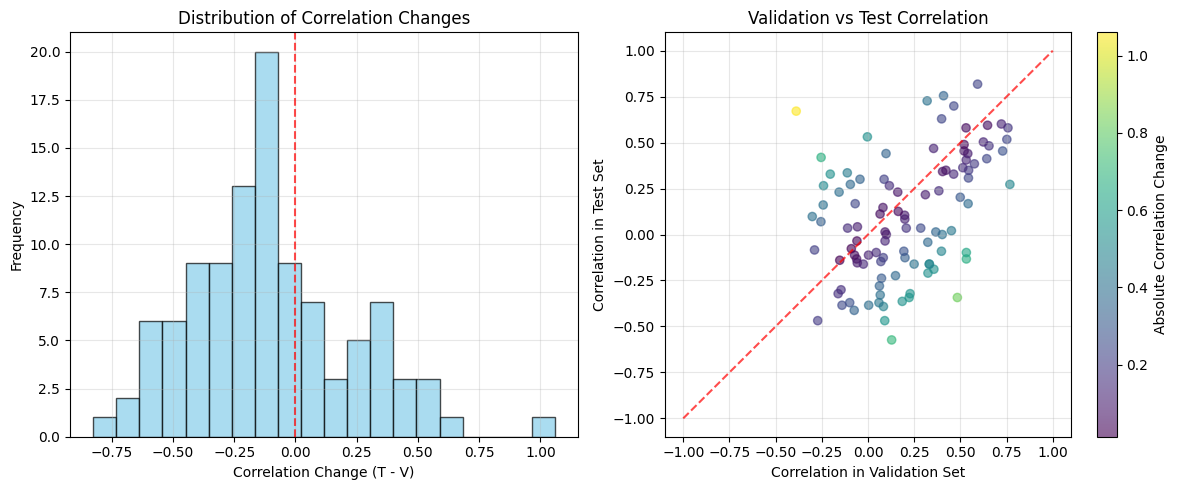


Analysis by number of same parameters:
             corr_V  corr_T  corr_diff  abs_corr_diff  pair_count
same_params                                                      
2             0.219  -0.080     -0.300          0.306          16
3             0.132   0.064     -0.067          0.200          28
4             0.098   0.199      0.101          0.293          14
5             0.107   0.062     -0.045          0.344          22
6             0.152  -0.135     -0.287          0.358          10
8             0.646   0.542     -0.104          0.161           4
10            0.580   0.432     -0.148          0.294          11


In [ ]:
def analyze_correlation_changes(result_V, result_T):
    """
    Analyzes correlation changes between validation and test sets.
    
    Parameters:
    result_V: Dictionary from plot_model_corr for validation set
    result_T: Dictionary from plot_model_corr for test set
    
    Returns:
    DataFrame with columns: model_pair, same_params, corr_V, corr_T, corr_diff
    """
    # Find common model pairs between both sets
    common_pairs = set(result_V.keys()) & set(result_T.keys())
    
    if not common_pairs:
        raise ValueError("No common model pairs found between validation and test results")
    
    # Prepare data for analysis
    analysis_data = []
    
    for pair in common_pairs:
        same_params_V, corr_V = result_V[pair]
        same_params_T, corr_T = result_T[pair]
        
        # Sanity check: same_params should be identical for the same model pair
        if same_params_V != same_params_T:
            print(f"Warning: Parameter count mismatch for pair {pair}: V={same_params_V}, T={same_params_T}")
        
        corr_diff = corr_T - corr_V
        abs_corr_diff = abs(corr_diff)
        
        analysis_data.append({
            'model_pair': pair,
            'same_params': same_params_V,  # Use V value (should be same as T)
            'corr_V': corr_V,
            'corr_T': corr_T,
            'corr_diff': corr_diff,
            'abs_corr_diff': abs_corr_diff
        })
    
    # Create DataFrame
    df = pd.DataFrame(analysis_data)
    
    # Sort by absolute correlation difference (largest changes first)
    df = df.sort_values('abs_corr_diff', ascending=False).reset_index(drop=True)
    
    return df

# Example usage with your results:
correlation_analysis_df = analyze_correlation_changes(result_V, result_T)

# Display the results
print("Correlation Changes Analysis:")
print(f"Number of model pairs analyzed: {len(correlation_analysis_df)}")
print(f"Average correlation in V set: {correlation_analysis_df['corr_V'].mean():.3f}")
print(f"Average correlation in T set: {correlation_analysis_df['corr_T'].mean():.3f}")
print(f"Average absolute correlation change: {correlation_analysis_df['abs_corr_diff'].mean():.3f}")
print(f"Maximum correlation change: {correlation_analysis_df['abs_corr_diff'].max():.3f}")
print("\nTop 10 pairs with largest correlation changes:")
print(correlation_analysis_df[['model_pair', 'same_params', 'corr_V', 'corr_T', 'corr_diff']].head(10))

# Optional: Plot the distribution of correlation changes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(correlation_analysis_df['corr_diff'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Correlation Change (T - V)')
plt.ylabel('Frequency')
plt.title('Distribution of Correlation Changes')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(correlation_analysis_df['corr_V'], correlation_analysis_df['corr_T'], 
           alpha=0.6, c=correlation_analysis_df['abs_corr_diff'], cmap='viridis')
plt.colorbar(label='Absolute Correlation Change')
plt.plot([-1, 1], [-1, 1], 'r--', alpha=0.7)  # Diagonal line
plt.xlabel('Correlation in Validation Set')
plt.ylabel('Correlation in Test Set')
plt.title('Validation vs Test Correlation')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Group by number of same parameters
if len(correlation_analysis_df) > 0:
    grouped_analysis = correlation_analysis_df.groupby('same_params').agg({
        'corr_V': 'mean',
        'corr_T': 'mean',
        'corr_diff': 'mean',
        'abs_corr_diff': 'mean',
        'model_pair': 'count'
    }).rename(columns={'model_pair': 'pair_count'}).round(3)
    
    print("\nAnalysis by number of same parameters:")
    print(grouped_analysis)

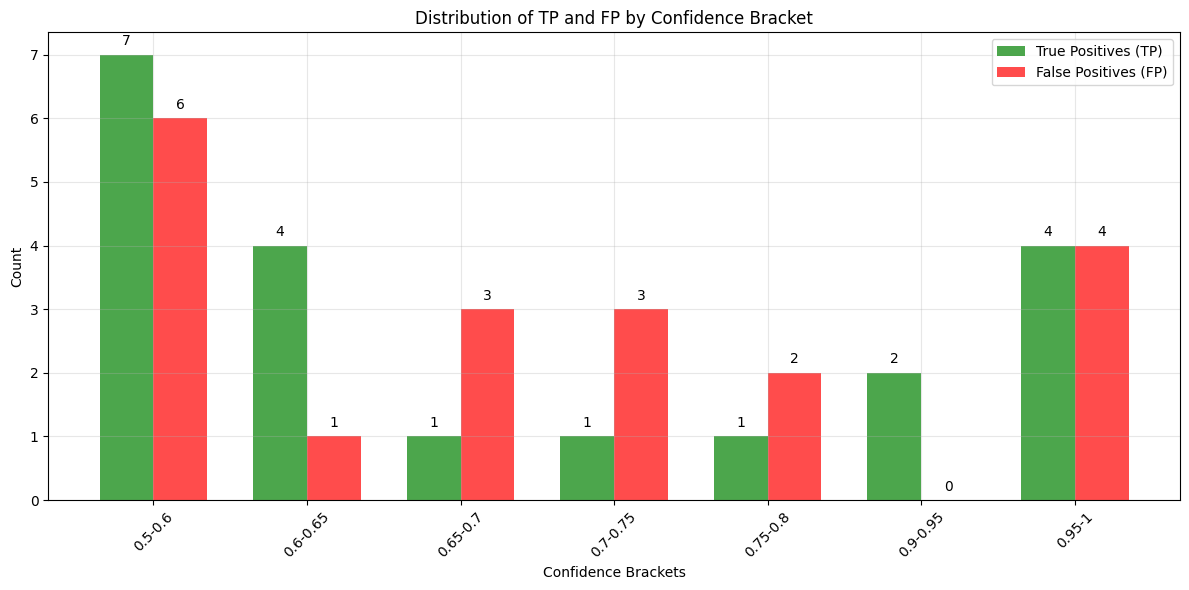

Summary by Confidence Bracket:
----------------------------------------
0.5-0.6: TP=7, FP=6, Total=13, Precision=0.538
0.6-0.65: TP=4, FP=1, Total=5, Precision=0.800
0.65-0.7: TP=1, FP=3, Total=4, Precision=0.250
0.7-0.75: TP=1, FP=3, Total=4, Precision=0.250
0.75-0.8: TP=1, FP=2, Total=3, Precision=0.333
0.9-0.95: TP=2, FP=0, Total=2, Precision=1.000
0.95-1: TP=4, FP=4, Total=8, Precision=0.500


In [ ]:
###                             PURPOSE - BAR CHART OF TP AND FP BY CONFIDENCE BRACKET - WE WOULD HOPE THAT THE TP DOMINATES IN THE HIGHER BRACKETS


###     CONVERTED TO USE MASTER DF INSTEAD 
###     CONVERTED TO USE MASTER DF INSTEAD 


logit_brackets_pred1 =  [(0.5, 0.6), (0.6, 0.65), (0.65, 0.7), 
                         (0.7, 0.75) , (0.75, 0.8) , (0.8, 0.85), (0.85, 0.9), (0.9, 0.95) , (0.95, 1)]
data_dict_bar_chart = {}


DATA_SET_FOLD = "T"

for act , pred , param_int in zip(master_df[f"all_actuals_mac_{DATA_SET_FOLD}"] , master_df[f"all_preds_mac_{DATA_SET_FOLD}"],  master_df[f"param_int_Vue_mac_{DATA_SET_FOLD}"]):
    flat_preds = [i for part in pred for i in part]
    flat_actuals = [i for part in act for i in part]
    for p , a in zip(flat_preds, flat_actuals):

        if (p > 0.5 and a > 0.5):
            for tup in logit_brackets_pred1:
                for L , H in [tup]:
                    if L < p < H:
                        #check if dict if empty first , vals should not be replaced 
                        if f"{L}-{H}-{param_int}" in data_dict_bar_chart:
                            data_dict_bar_chart[f"{L}-{H}-{param_int}"].append("TP")
                        else:
                            data_dict_bar_chart[f"{L}-{H}-{param_int}"] = ["TP"]

        if (p > 0.5 and a < 0.5):
            for tup in logit_brackets_pred1:
                for L , H in [tup]:
                    if L < p < H:
                        if f"{L}-{H}-{param_int}" in data_dict_bar_chart:
                            data_dict_bar_chart[f"{L}-{H}-{param_int}"].append("FP")
                        else:
                            data_dict_bar_chart[f"{L}-{H}-{param_int}"] = ["FP"]




data_dict_bar_chart

# ###     CONVERTED TO USE MASTER DF INSTEAD 
# ###     CONVERTED TO USE MASTER DF INSTEAD 
# ###                             THRESH AND PRED CORR FILTER TESTING TESTING TESTING 




import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Extract bracket counts from your data_dict_bar_chart
bracket_counts = defaultdict(lambda: {'TP': 0, 'FP': 0})

for key, values in data_dict_bar_chart.items():
    # Extract just the bracket part (ignore the model number)
    bracket = '-'.join(key.split('-')[:2])
    
    # Count TP and FP
    for value in values:
        if value == 'TP':
            bracket_counts[bracket]['TP'] += 1
        elif value == 'FP':
            bracket_counts[bracket]['FP'] += 1

# Prepare data for plotting
brackets = sorted(bracket_counts.keys(), key=lambda x: float(x.split('-')[0]))
tp_counts = [bracket_counts[b]['TP'] for b in brackets]
fp_counts = [bracket_counts[b]['FP'] for b in brackets]

# Create the plot
plt.figure(figsize=(12, 6))

x = np.arange(len(brackets))
width = 0.35

plt.bar(x - width/2, tp_counts, width, label='True Positives (TP)', alpha=0.7, color='green')
plt.bar(x + width/2, fp_counts, width, label='False Positives (FP)', alpha=0.7, color='red')

plt.xlabel('Confidence Brackets')
plt.ylabel('Count')
plt.title('Distribution of TP and FP by Confidence Bracket')
plt.xticks(x, brackets, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Add total counts on top of bars
for i, (tp, fp) in enumerate(zip(tp_counts, fp_counts)):
    plt.text(i - width/2, tp + 0.1, str(tp), ha='center', va='bottom')
    plt.text(i + width/2, fp + 0.1, str(fp), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary by Confidence Bracket:")
print("-" * 40)
for bracket in brackets:
    tp = bracket_counts[bracket]['TP']
    fp = bracket_counts[bracket]['FP']
    total = tp + fp
    precision = tp / total if total > 0 else 0
    print(f"{bracket}: TP={tp}, FP={fp}, Total={total}, Precision={precision:.3f}")

FP actual raw: 0.14319526627218937, pred: 0.5053175091743469, act: 0.0, severity: Severe (>0.1)
FP actual raw: 0.060271451575799606, pred: 0.5134336948394775, act: 0.0, severity: Medium (0.05-0.1)
FP actual raw: -0.022367913613575152, pred: 0.6994616985321045, act: 0.0, severity: Negative (-0.05-0)
FP actual raw: 0.14319526627218937, pred: 0.7354041337966919, act: 0.0, severity: Severe (>0.1)
FP actual raw: 0.060271451575799606, pred: 0.7475719451904297, act: 0.0, severity: Medium (0.05-0.1)
FP actual raw: 0.10238210986874097, pred: 0.6733989119529724, act: 0.0, severity: Severe (>0.1)
FP actual raw: -0.04850943729052748, pred: 0.5681711435317993, act: 0.0, severity: Negative (-0.05-0)
FP actual raw: -0.022367913613575152, pred: 0.5747760534286499, act: 0.0, severity: Negative (-0.05-0)
FP actual raw: 0.14319526627218937, pred: 0.7034813165664673, act: 0.0, severity: Severe (>0.1)
FP actual raw: 0.060271451575799606, pred: 0.6555504202842712, act: 0.0, severity: Medium (0.05-0.1)
FP ac

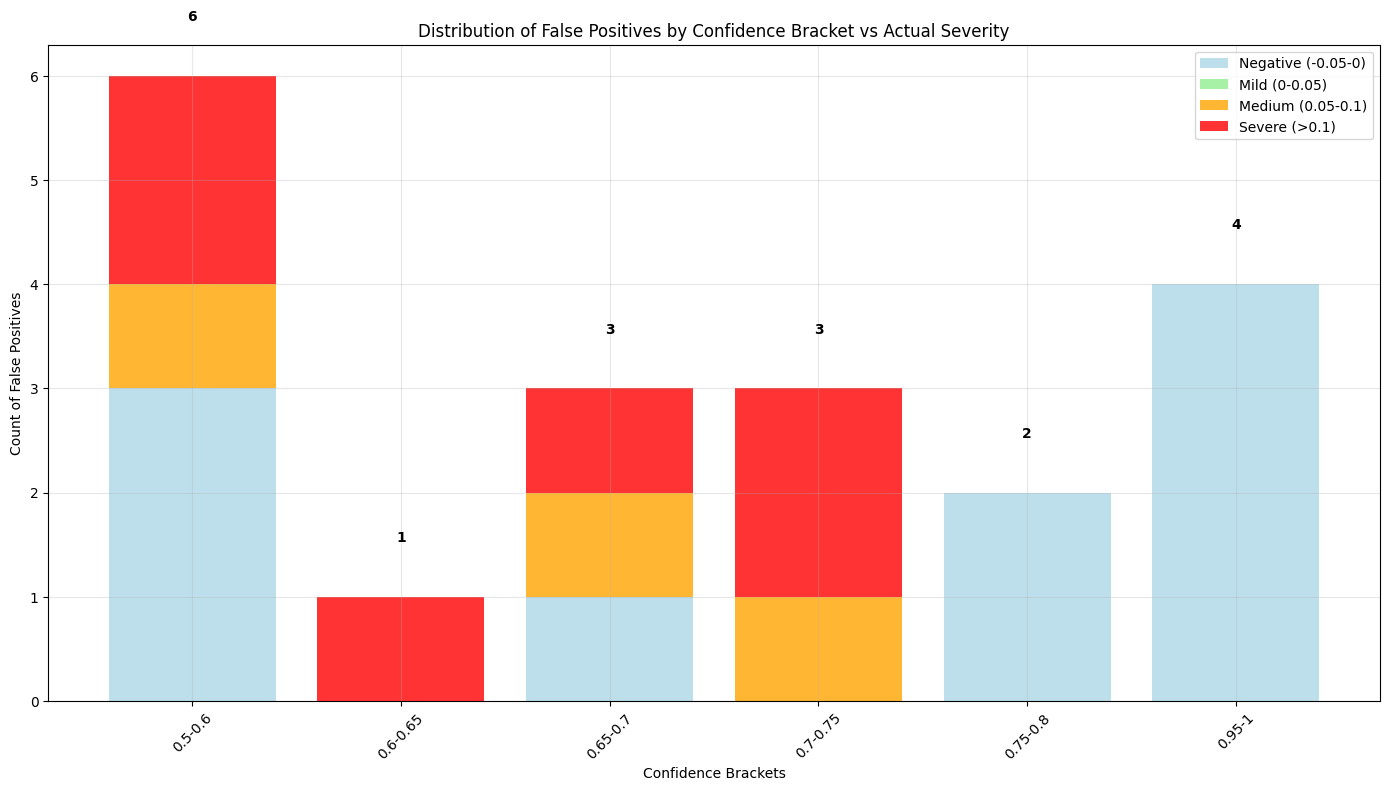

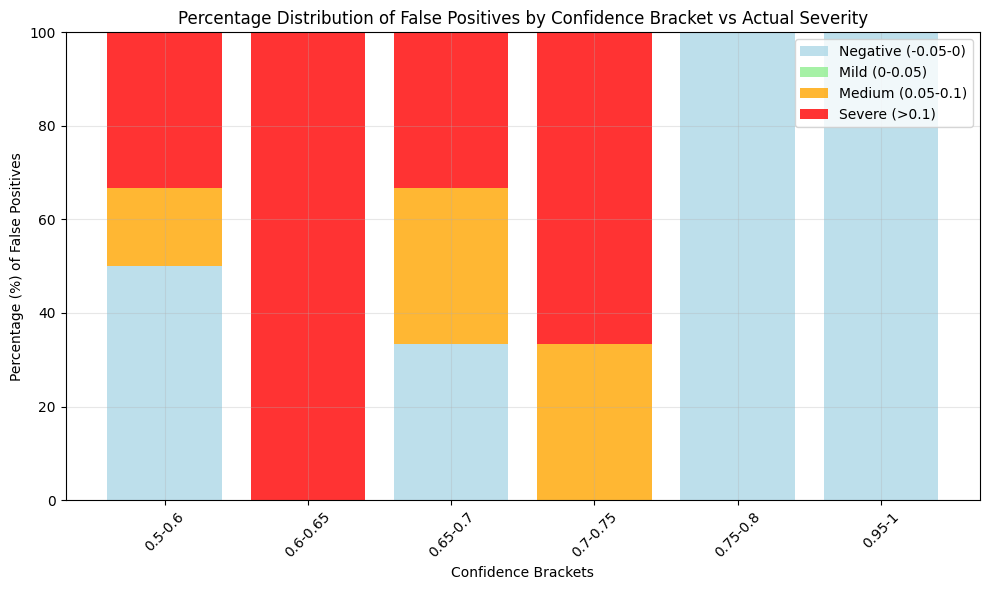

In [ ]:
####                            PURPOSE - BAR CHART OF FP BY CONFIDENCE BRACKET AND ACTUAL SEVERITY - WE WOULD HOPE THAT THE SEVERE CASES DOMINATE IN THE LOWER BRACKETS


import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict


DATA_SET_FOLD = "T"


def classify_severity(actual_value):
    """Classify actual values into severity categories"""
    if 0 >= actual_value >= -0.05:
        return "Negative (-0.05-0)"
    elif 0 < actual_value <= 0.05:
        return "Mild (0-0.05)"
    elif 0.05 < actual_value <= 0.1:
        return "Medium (0.05-0.1)"
    elif actual_value > 0.1:
        return "Severe (>0.1)"

# Extract bracket counts with severity information - ONLY FOR FALSE POSITIVES
bracket_severity_counts = defaultdict(lambda: {
    'Negative (-0.05-0)': 0,
    'Mild (0-0.05)': 0, 
    'Medium (0.05-0.1)': 0,
    'Severe (>0.1)': 0
})

# Process the original data to get actual values - ONLY FALSE POSITIVES
for act, pred, raw_act, param_int in zip(master_df[f"all_actuals_mac_{DATA_SET_FOLD}"], 
                               master_df[f"all_preds_mac_{DATA_SET_FOLD}"],  
                               master_df[f"raw_actuals_mac_{DATA_SET_FOLD}"],
                               master_df[f"param_int_Vue_mac_{DATA_SET_FOLD}"]):
    
    flat_preds = [i for part in pred for i in part]
    flat_actuals = [i for part in act for i in part]
    flat_raw_actuals = [i for part in raw_act for i in part]

    for p, a , a_raw in zip(flat_preds, flat_actuals, flat_raw_actuals):
        # ONLY FALSE POSITIVES: prediction > 0.5 BUT actual <= 0.5
        if p > 0.5 and a < 0.5:

            severity = classify_severity(a_raw)
            print(f"FP actual raw: {a_raw}, pred: {p}, act: {a}, severity: {severity}")


            # Find which bracket this prediction falls into
            for L, H in logit_brackets_pred1:
                if L < p < H:
                    bracket = f"{L}-{H}"
                    bracket_severity_counts[bracket][severity] += 1
                    break

# Prepare data for plotting
brackets = sorted(bracket_severity_counts.keys(), key=lambda x: float(x.split('-')[0]))
severity_categories = ["Negative (-0.05-0)", "Mild (0-0.05)", "Medium (0.05-0.1)", "Severe (>0.1)"]

# Create counts for each severity category by bracket
counts_by_severity = {category: [] for category in severity_categories}
for bracket in brackets:
    for category in severity_categories:
        counts_by_severity[category].append(bracket_severity_counts[bracket][category])

# Create the stacked bar plot - ONLY FALSE POSITIVES
plt.figure(figsize=(14, 8))

x = np.arange(len(brackets))
width = 0.8
bottom = np.zeros(len(brackets))

colors = ['lightblue', 'lightgreen', 'orange', 'red']

for i, category in enumerate(severity_categories):
    counts = counts_by_severity[category]
    plt.bar(x, counts, width, bottom=bottom, label=category, alpha=0.8, color=colors[i])
    bottom += counts

plt.xlabel('Confidence Brackets')
plt.ylabel('Count of False Positives')
plt.title('Distribution of False Positives by Confidence Bracket vs Actual Severity')
plt.xticks(x, brackets, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Add total counts on top of bars
total_counts = [sum(bracket_severity_counts[bracket].values()) for bracket in brackets]
for i, total in enumerate(total_counts):
    plt.text(i, total + 0.5, str(total), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# # Print summary statistics - ONLY FALSE POSITIVES
# print("Summary of FALSE POSITIVES by Confidence Bracket and Severity:")
# print("-" * 70)
# for bracket in brackets:
#     total = sum(bracket_severity_counts[bracket].values())
#     print(f"\n{bracket}: Total FP={total}")
#     for severity in severity_categories:
#         count = bracket_severity_counts[bracket][severity]
#         percentage = (count / total * 100) if total > 0 else 0
#         print(f"  {severity}: {count} ({percentage:.1f}%)")

# Additional: Create a normalized stacked bar plot to see proportions
plt.figure(figsize=(10, 6))

# Calculate percentages
percentages_by_severity = {category: [] for category in severity_categories}
for bracket in brackets:
    total = sum(bracket_severity_counts[bracket].values())
    for category in severity_categories:
        percentage = (bracket_severity_counts[bracket][category] / total * 100) if total > 0 else 0
        percentages_by_severity[category].append(percentage)

# Create normalized stacked bar plot
bottom = np.zeros(len(brackets))
for i, category in enumerate(severity_categories):
    percentages = percentages_by_severity[category]
    plt.bar(x, percentages, width, bottom=bottom, label=category, alpha=0.8, color=colors[i])
    bottom += percentages



plt.xlabel('Confidence Brackets')
plt.ylabel('Percentage (%) of False Positives')
plt.title('Percentage Distribution of False Positives by Confidence Bracket vs Actual Severity')
plt.xticks(x, brackets, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

Model groups by POS_weight_multiplier parameter:
POS_weight_multiplier=1.3: models=[12, 5]
POS_weight_multiplier=0.7: models=[13, 6, 10, 3, 8, 1, 0]
POS_weight_multiplier=0.1: models=[11, 4, 7, 14]
POS_weight_multiplier=1: models=[2, 9]

ANALYSIS FOR POS_WEIGHT_MULTIPLIER = 1.3 (Models: [12, 5])
No false positives found for POS_weight_multiplier=1.3

ANALYSIS FOR POS_WEIGHT_MULTIPLIER = 0.7 (Models: [13, 6, 10, 3, 8, 1, 0])


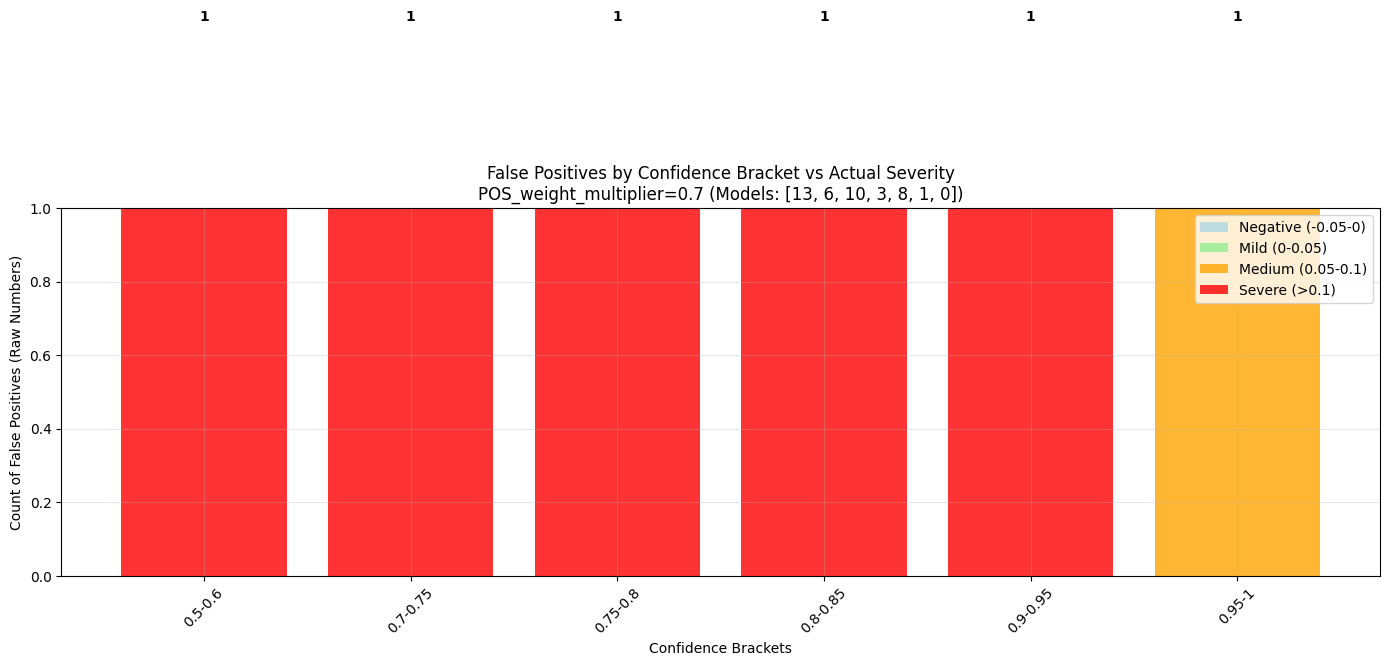

Summary of FALSE POSITIVES for POS_weight_multiplier=0.7:
----------------------------------------------------------------------

0.5-0.6: Total FP=1
  Negative (-0.05-0): 0
  Mild (0-0.05): 0
  Medium (0.05-0.1): 0
  Severe (>0.1): 1

0.7-0.75: Total FP=1
  Negative (-0.05-0): 0
  Mild (0-0.05): 0
  Medium (0.05-0.1): 0
  Severe (>0.1): 1

0.75-0.8: Total FP=1
  Negative (-0.05-0): 0
  Mild (0-0.05): 0
  Medium (0.05-0.1): 0
  Severe (>0.1): 1

0.8-0.85: Total FP=1
  Negative (-0.05-0): 0
  Mild (0-0.05): 0
  Medium (0.05-0.1): 0
  Severe (>0.1): 1

0.9-0.95: Total FP=1
  Negative (-0.05-0): 0
  Mild (0-0.05): 0
  Medium (0.05-0.1): 0
  Severe (>0.1): 1

0.95-1: Total FP=1
  Negative (-0.05-0): 0
  Mild (0-0.05): 0
  Medium (0.05-0.1): 1
  Severe (>0.1): 0

ANALYSIS FOR POS_WEIGHT_MULTIPLIER = 0.1 (Models: [11, 4, 7, 14])


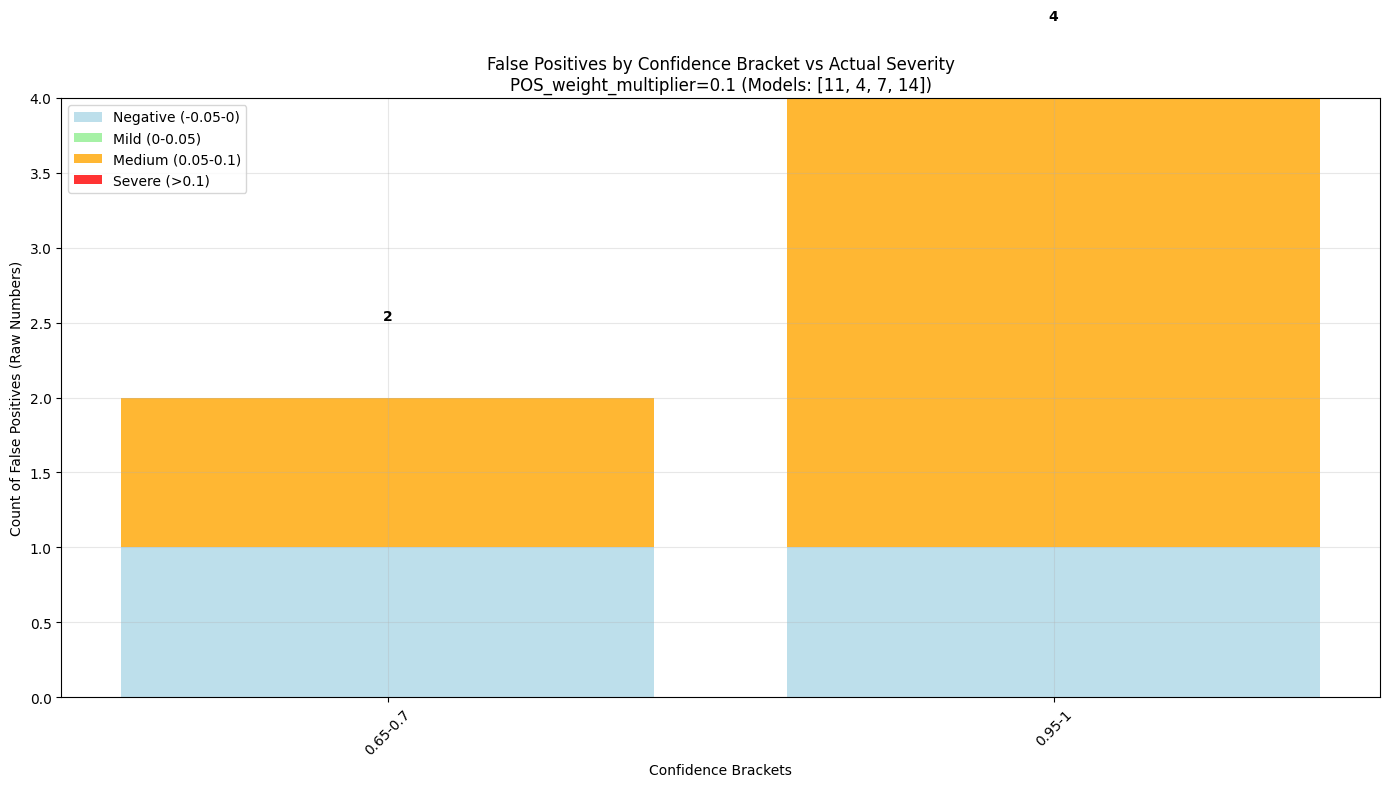

Summary of FALSE POSITIVES for POS_weight_multiplier=0.1:
----------------------------------------------------------------------

0.65-0.7: Total FP=2
  Negative (-0.05-0): 1
  Mild (0-0.05): 0
  Medium (0.05-0.1): 1
  Severe (>0.1): 0

0.95-1: Total FP=4
  Negative (-0.05-0): 1
  Mild (0-0.05): 0
  Medium (0.05-0.1): 3
  Severe (>0.1): 0

ANALYSIS FOR POS_WEIGHT_MULTIPLIER = 1 (Models: [2, 9])


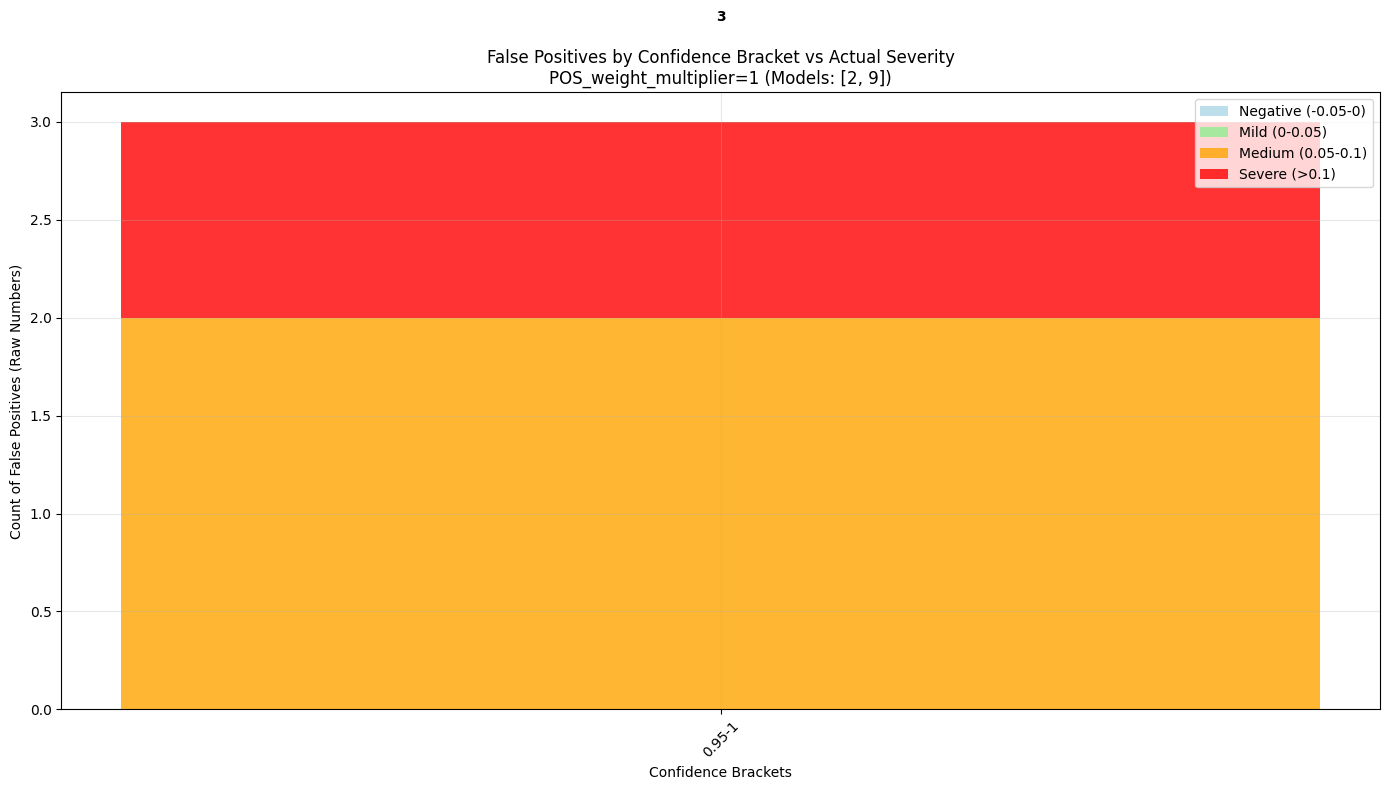

Summary of FALSE POSITIVES for POS_weight_multiplier=1:
----------------------------------------------------------------------

0.95-1: Total FP=3
  Negative (-0.05-0): 0
  Mild (0-0.05): 0
  Medium (0.05-0.1): 2
  Severe (>0.1): 1

Analysis complete for all POS_weight_multiplier groups!


In [ ]:
#######                      PURPOSE - CHECK FOR CORR BETWEEN POS_WEIGHT_MULTIPLIER PARAMETER AND FALSE POSITIVES BY SEVERITY AND CONFIDENCE BRACKET

## this analysis must be done with more models with randomness used accordingly - ie same random models for diff pos_weight_multiplier values




import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd

logit_brackets_pred1 =  [(0.5, 0.6), (0.6, 0.65), (0.65, 0.7), 
                         (0.7, 0.75) , (0.75, 0.8) , (0.8, 0.85), (0.85, 0.9), (0.9, 0.95) , (0.95, 1)]
# Define severity classifications - USING YOUR CORRECTED VERSION
def classify_severity(actual_value):
    """Classify actual values into severity categories"""
    if 0 >= actual_value >= -0.05:
        return "Negative (-0.05-0)"
    elif 0 < actual_value <= 0.05:
        return "Mild (0-0.05)"
    elif 0.05 < actual_value <= 0.1:
        return "Medium (0.05-0.1)"
    elif actual_value > 0.1:
        return "Severe (>0.1)"

# Extract POS_weight_multiplier parameter values and group models
param_groups = defaultdict(list)

DATA_SET_FOLD = "V"


for idx, row in master_df.iterrows():
    param_int = row[f"param_int_Vue_mac_{DATA_SET_FOLD}"]
    params = row[f"parameters_mac_{DATA_SET_FOLD}"]
    
    if isinstance(params, dict) and 'POS_weight_multiplier' in params:
        pos_weight = params['POS_weight_multiplier']
        param_groups[pos_weight].append(param_int)

print("Model groups by POS_weight_multiplier parameter:")
for pos_weight, models in param_groups.items():
    print(f"POS_weight_multiplier={pos_weight}: models={models}")

# Analyze false positives for each parameter group
for pos_weight, model_ids in param_groups.items():
    print(f"\n{'='*80}")
    print(f"ANALYSIS FOR POS_WEIGHT_MULTIPLIER = {pos_weight} (Models: {model_ids})")
    print(f"{'='*80}")
    
    # Extract bracket counts with severity information - ONLY FOR FALSE POSITIVES
    bracket_severity_counts = defaultdict(lambda: {
        'Negative (-0.05-0)': 0,
        'Mild (0-0.05)': 0, 
        'Medium (0.05-0.1)': 0,
        'Severe (>0.1)': 0
    })

    # Process data only for models in this parameter group
    for idx, row in master_df.iterrows():
        param_int = row[f"param_int_Vue_mac_{DATA_SET_FOLD}"]
        
        # Only process models in the current parameter group
        if param_int in model_ids:
            raw_actuals = row[f"raw_actuals_mac_{DATA_SET_FOLD}"]  # RAW percentage change values
            binary_actuals = row[f"all_actuals_mac_{DATA_SET_FOLD}"]  # Binary 0/1 labels
            pred = row[f"all_preds_mac_{DATA_SET_FOLD}"]
            
            flat_preds = [i for part in pred for i in part]
            flat_raw_actuals = [i for part in raw_actuals for i in part]  # Raw pct changes
            flat_binary_actuals = [i for part in binary_actuals for i in part]  # Binary labels
            
            for p, raw_a, bin_a in zip(flat_preds, flat_raw_actuals, flat_binary_actuals):
                # ONLY FALSE POSITIVES: prediction > 0.5 BUT binary actual <= 0.5
                if p > 0.5 and bin_a <= 0.5:
                    severity = classify_severity(raw_a)  # Use RAW percentage change for severity
                    
                    # Find which bracket this prediction falls into
                    for L, H in logit_brackets_pred1:
                        if L < p < H:
                            bracket = f"{L}-{H}"
                            bracket_severity_counts[bracket][severity] += 1
                            break

    # Prepare data for plotting
    brackets = sorted(bracket_severity_counts.keys(), key=lambda x: float(x.split('-')[0]))
    severity_categories = ["Negative (-0.05-0)", "Mild (0-0.05)", "Medium (0.05-0.1)", "Severe (>0.1)"]
    
    # Skip if no false positives in this group
    total_fp = sum(sum(bracket_severity_counts[bracket].values()) for bracket in brackets)
    if total_fp == 0:
        print(f"No false positives found for POS_weight_multiplier={pos_weight}")
        continue

    # Create counts for each severity category by bracket
    counts_by_severity = {category: [] for category in severity_categories}
    for bracket in brackets:
        for category in severity_categories:
            counts_by_severity[category].append(bracket_severity_counts[bracket][category])

    # Create the stacked bar plot - ONLY FALSE POSITIVES (RAW COUNTS)
    plt.figure(figsize=(14, 8))

    x = np.arange(len(brackets))
    width = 0.8
    bottom = np.zeros(len(brackets))

    colors = ['lightblue', 'lightgreen', 'orange', 'red']

    for i, category in enumerate(severity_categories):
        counts = counts_by_severity[category]
        plt.bar(x, counts, width, bottom=bottom, label=category, alpha=0.8, color=colors[i])
        bottom += counts

    plt.xlabel('Confidence Brackets')
    plt.ylabel('Count of False Positives (Raw Numbers)')
    plt.title(f'False Positives by Confidence Bracket vs Actual Severity\nPOS_weight_multiplier={pos_weight} (Models: {model_ids})')
    plt.xticks(x, brackets, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add total counts on top of bars (RAW NUMBERS)
    total_counts = [sum(bracket_severity_counts[bracket].values()) for bracket in brackets]
    for i, total in enumerate(total_counts):
        plt.text(i, total + 0.5, str(total), ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print summary statistics - ONLY FALSE POSITIVES (RAW NUMBERS)
    print(f"Summary of FALSE POSITIVES for POS_weight_multiplier={pos_weight}:")
    print("-" * 70)
    for bracket in brackets:
        total = sum(bracket_severity_counts[bracket].values())
        print(f"\n{bracket}: Total FP={total}")
        for severity in severity_categories:
            count = bracket_severity_counts[bracket][severity]
            print(f"  {severity}: {count}")

print("\nAnalysis complete for all POS_weight_multiplier groups!")

In [ ]:
for i, j in zip(master_df["parameters_mac_V"], master_df["param_int_Vue_mac_V"]):
   print(i["POS_weight_multiplier"] , '-' , j)   

1.3 - 12
1.3 - 5
0.7 - 13
0.7 - 6
0.7 - 10
0.7 - 3
0.1 - 11
0.1 - 4
0.7 - 8
0.7 - 1
1 - 2
1 - 9
0.7 - 0
0.1 - 7
0.1 - 14


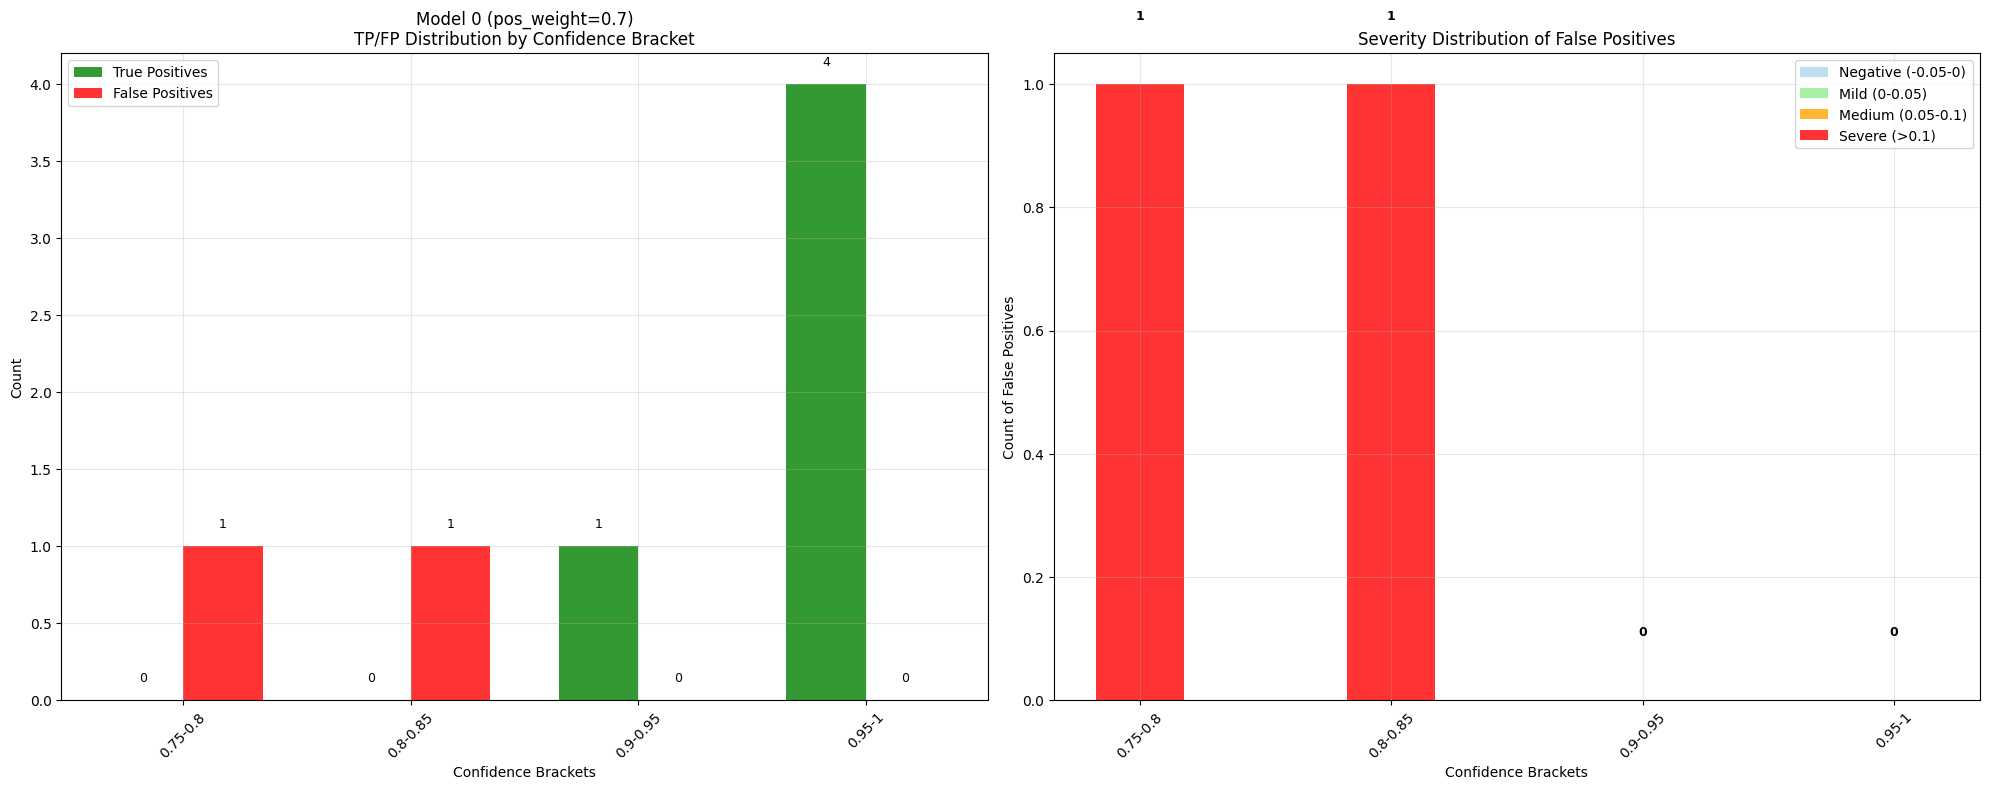


SUMMARY FOR MODEL 0 (pos_weight=0.7)
Total TP: 5, Total FP: 2, Precision: 0.714

Detailed breakdown by confidence bracket:

0.75-0.8: TP=0, FP=1, Total=1, Precision=0.000
  Severe (>0.1): 1

0.8-0.85: TP=0, FP=1, Total=1, Precision=0.000
  Severe (>0.1): 1

0.9-0.95: TP=1, FP=0, Total=1, Precision=1.000

0.95-1: TP=4, FP=0, Total=4, Precision=1.000


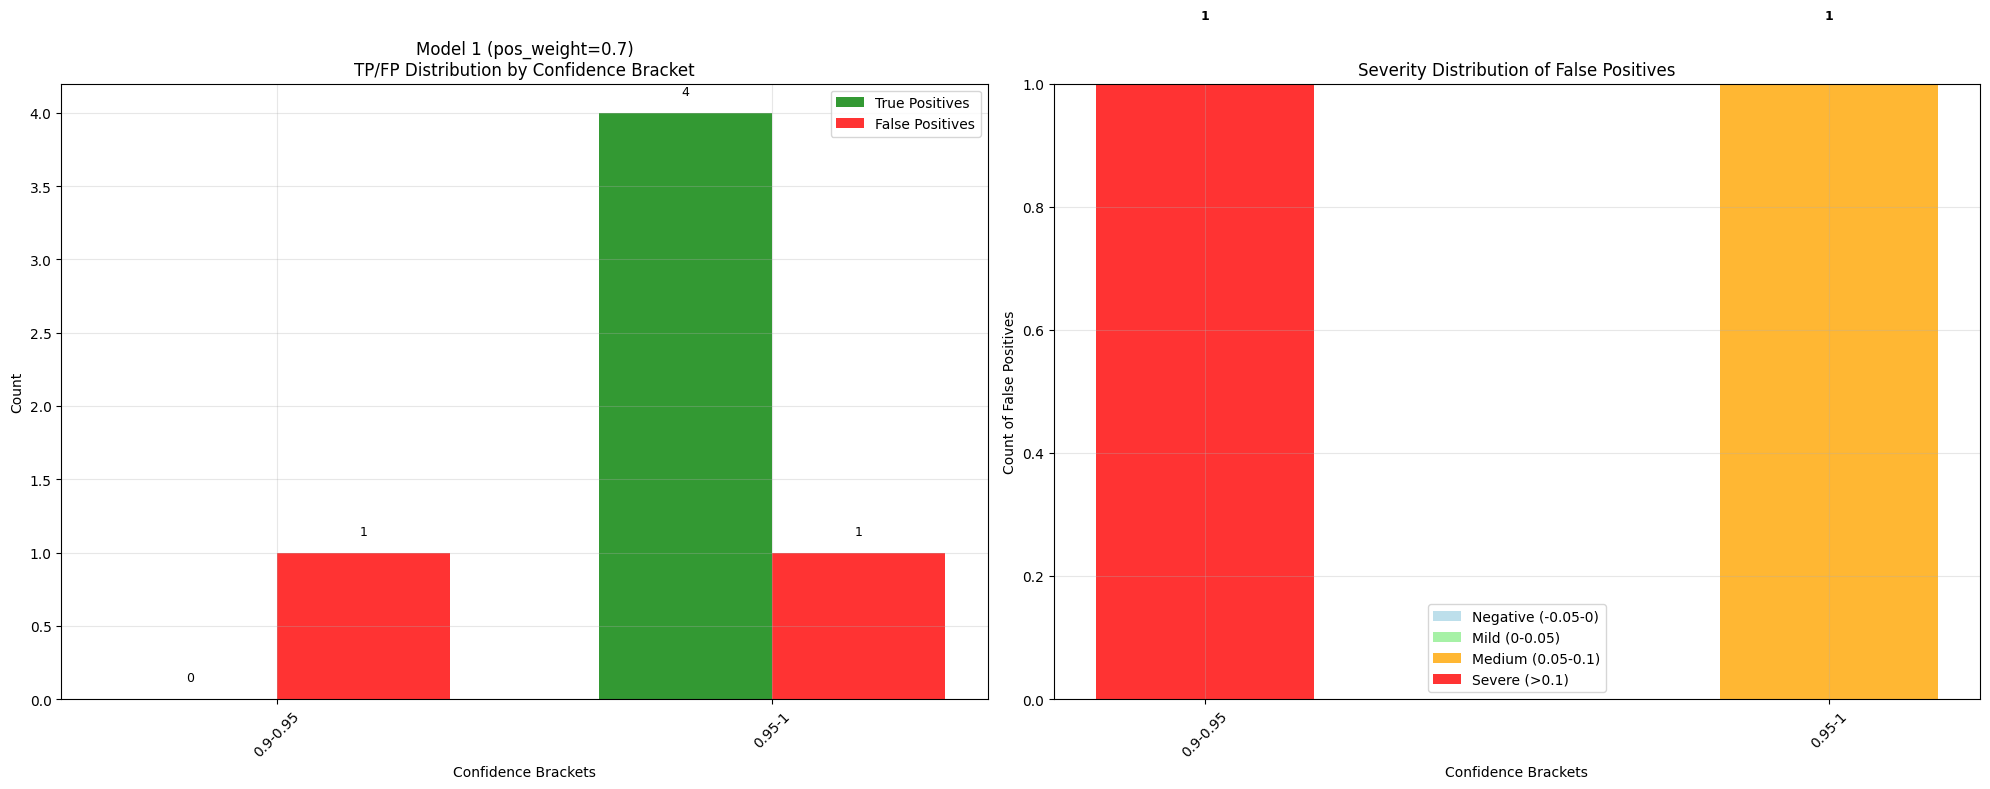


SUMMARY FOR MODEL 1 (pos_weight=0.7)
Total TP: 4, Total FP: 2, Precision: 0.667

Detailed breakdown by confidence bracket:

0.9-0.95: TP=0, FP=1, Total=1, Precision=0.000
  Severe (>0.1): 1

0.95-1: TP=4, FP=1, Total=5, Precision=0.800
  Medium (0.05-0.1): 1


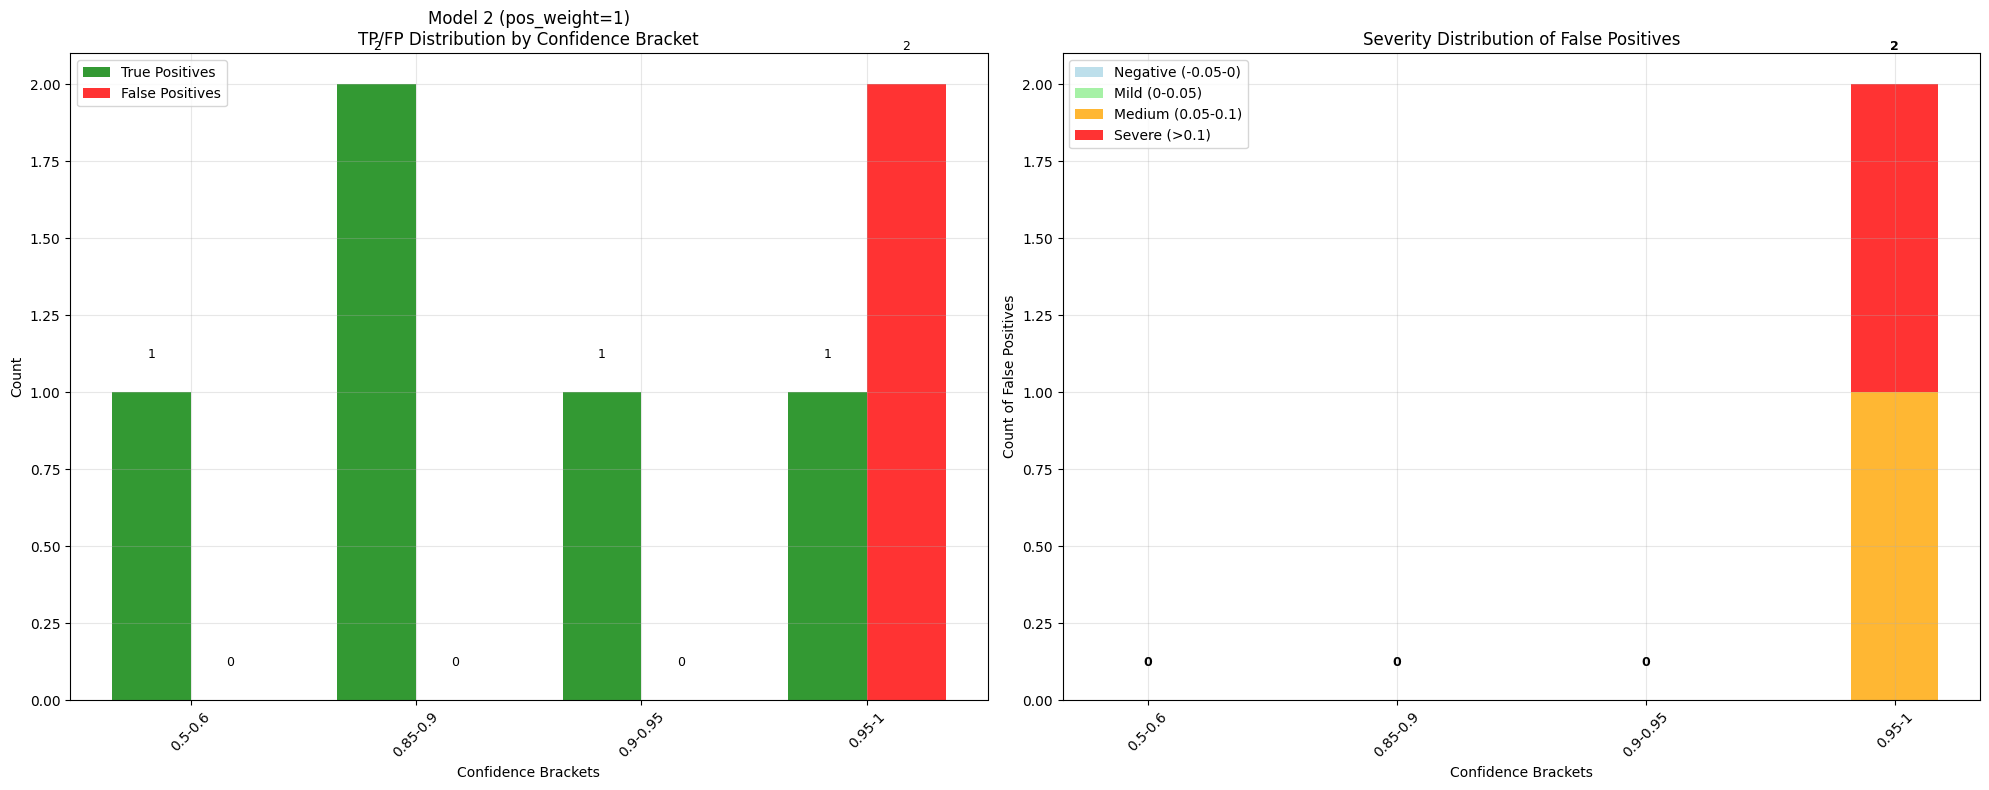


SUMMARY FOR MODEL 2 (pos_weight=1)
Total TP: 5, Total FP: 2, Precision: 0.714

Detailed breakdown by confidence bracket:

0.5-0.6: TP=1, FP=0, Total=1, Precision=1.000

0.85-0.9: TP=2, FP=0, Total=2, Precision=1.000

0.9-0.95: TP=1, FP=0, Total=1, Precision=1.000

0.95-1: TP=1, FP=2, Total=3, Precision=0.333
  Medium (0.05-0.1): 1
  Severe (>0.1): 1


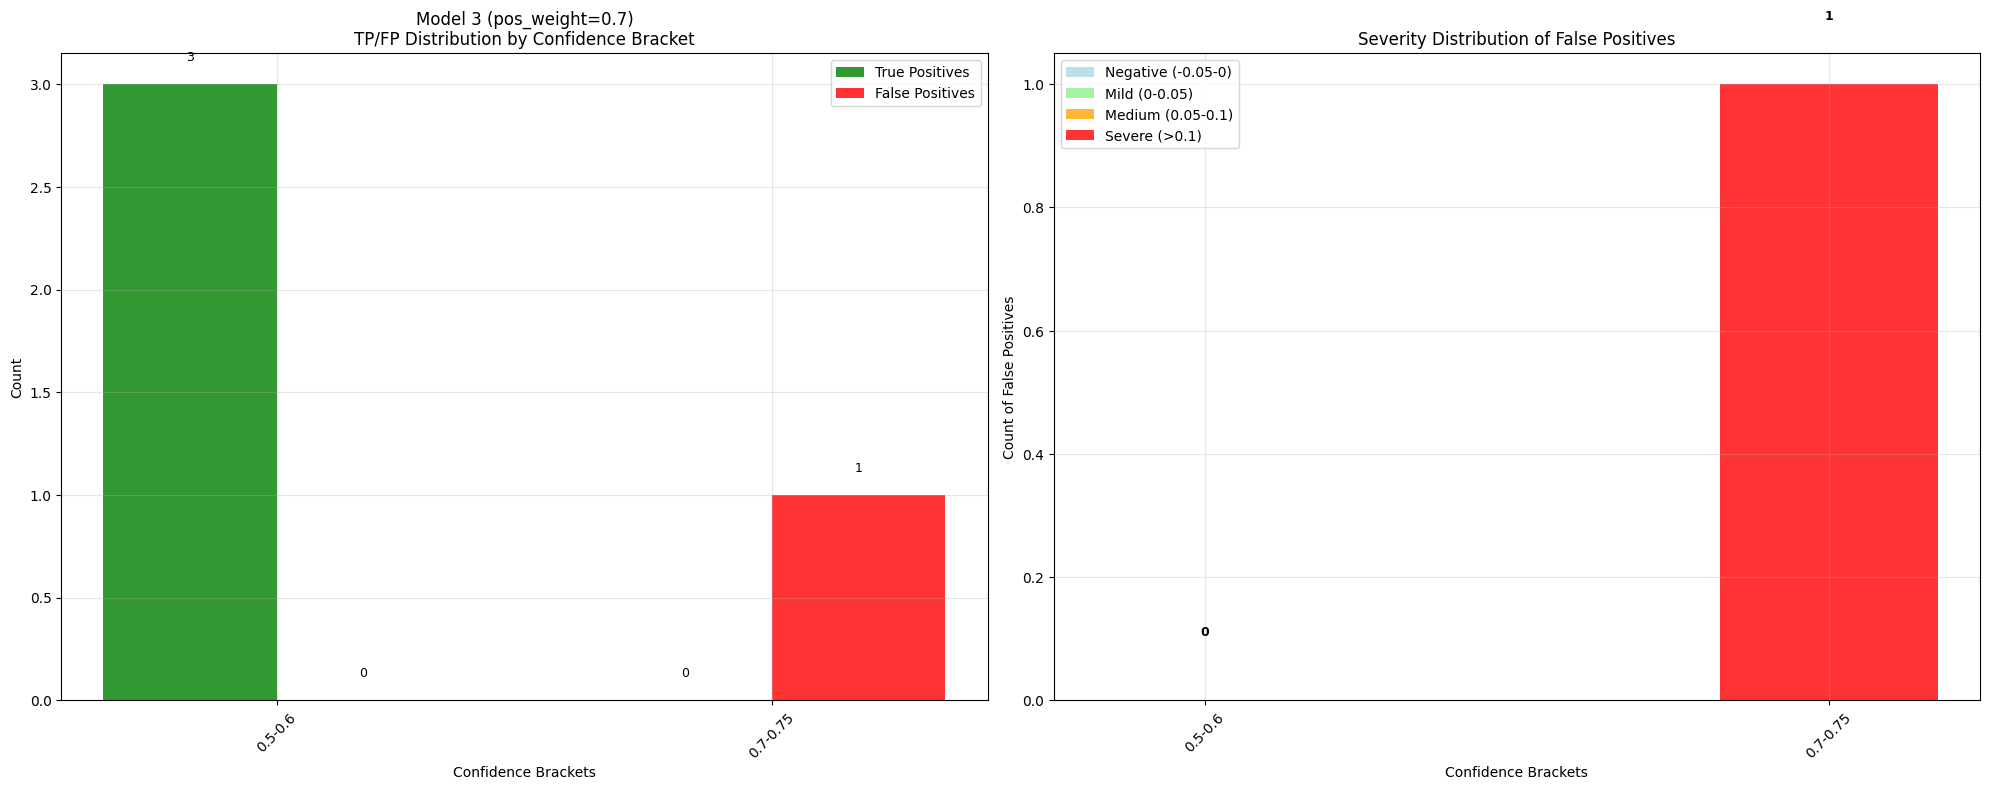


SUMMARY FOR MODEL 3 (pos_weight=0.7)
Total TP: 3, Total FP: 1, Precision: 0.750

Detailed breakdown by confidence bracket:

0.5-0.6: TP=3, FP=0, Total=3, Precision=1.000

0.7-0.75: TP=0, FP=1, Total=1, Precision=0.000
  Severe (>0.1): 1


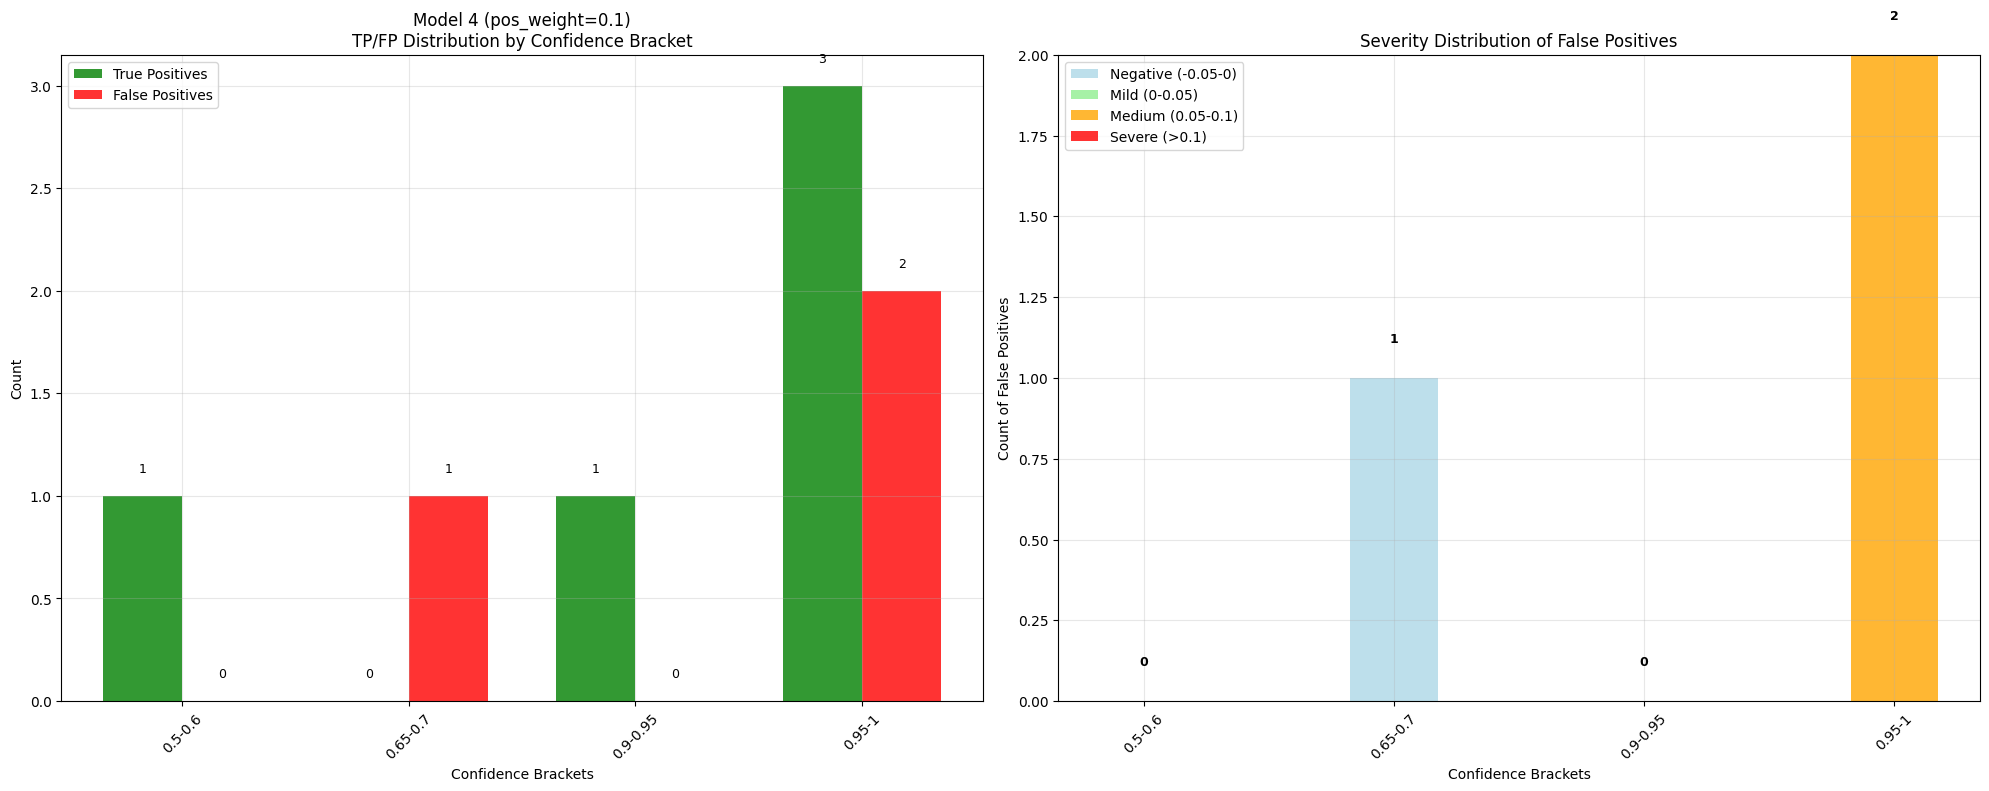


SUMMARY FOR MODEL 4 (pos_weight=0.1)
Total TP: 5, Total FP: 3, Precision: 0.625

Detailed breakdown by confidence bracket:

0.5-0.6: TP=1, FP=0, Total=1, Precision=1.000

0.65-0.7: TP=0, FP=1, Total=1, Precision=0.000
  Negative (-0.05-0): 1

0.9-0.95: TP=1, FP=0, Total=1, Precision=1.000

0.95-1: TP=3, FP=2, Total=5, Precision=0.600
  Medium (0.05-0.1): 2


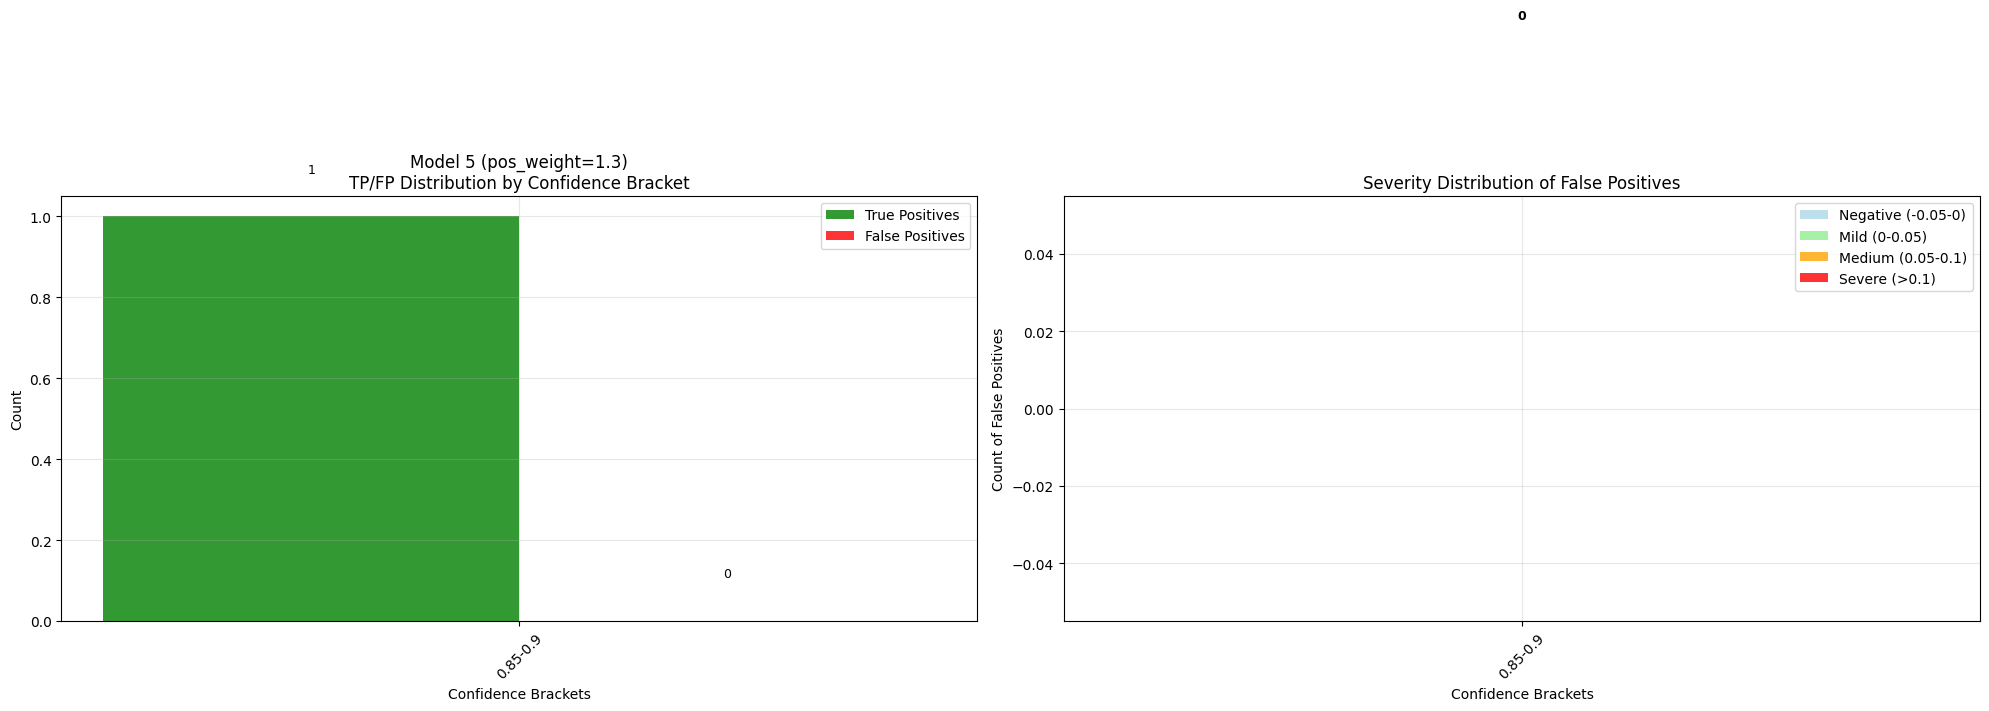


SUMMARY FOR MODEL 5 (pos_weight=1.3)
Total TP: 1, Total FP: 0, Precision: 1.000

Detailed breakdown by confidence bracket:

0.85-0.9: TP=1, FP=0, Total=1, Precision=1.000


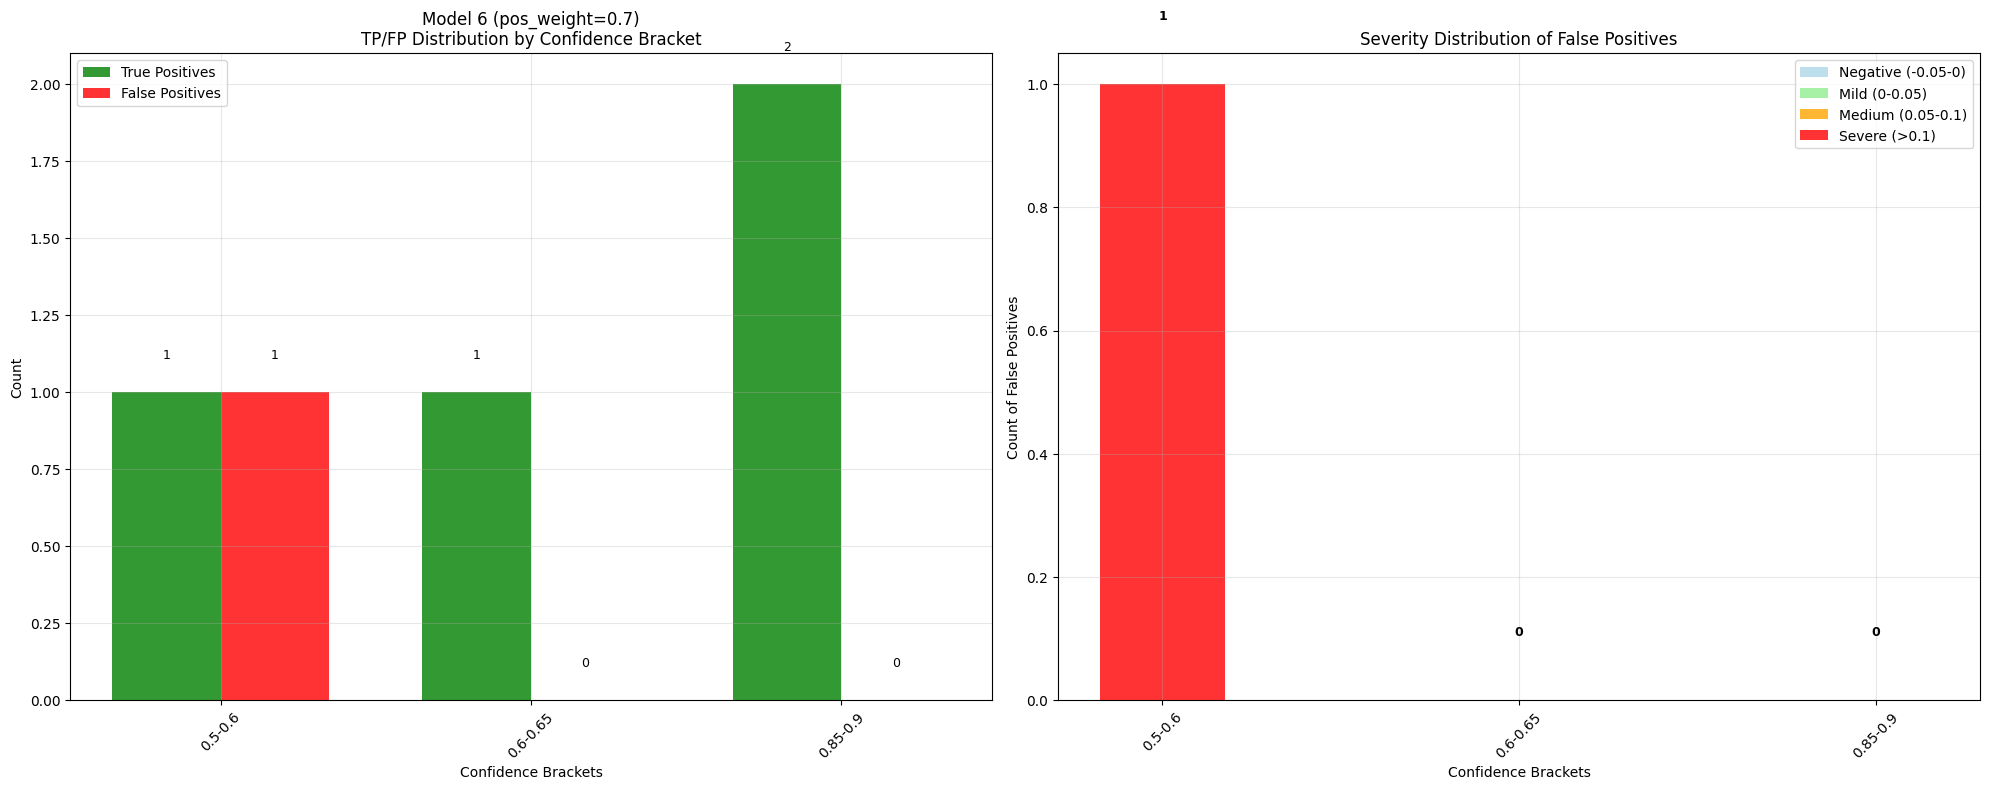


SUMMARY FOR MODEL 6 (pos_weight=0.7)
Total TP: 4, Total FP: 1, Precision: 0.800

Detailed breakdown by confidence bracket:

0.5-0.6: TP=1, FP=1, Total=2, Precision=0.500
  Severe (>0.1): 1

0.6-0.65: TP=1, FP=0, Total=1, Precision=1.000

0.85-0.9: TP=2, FP=0, Total=2, Precision=1.000


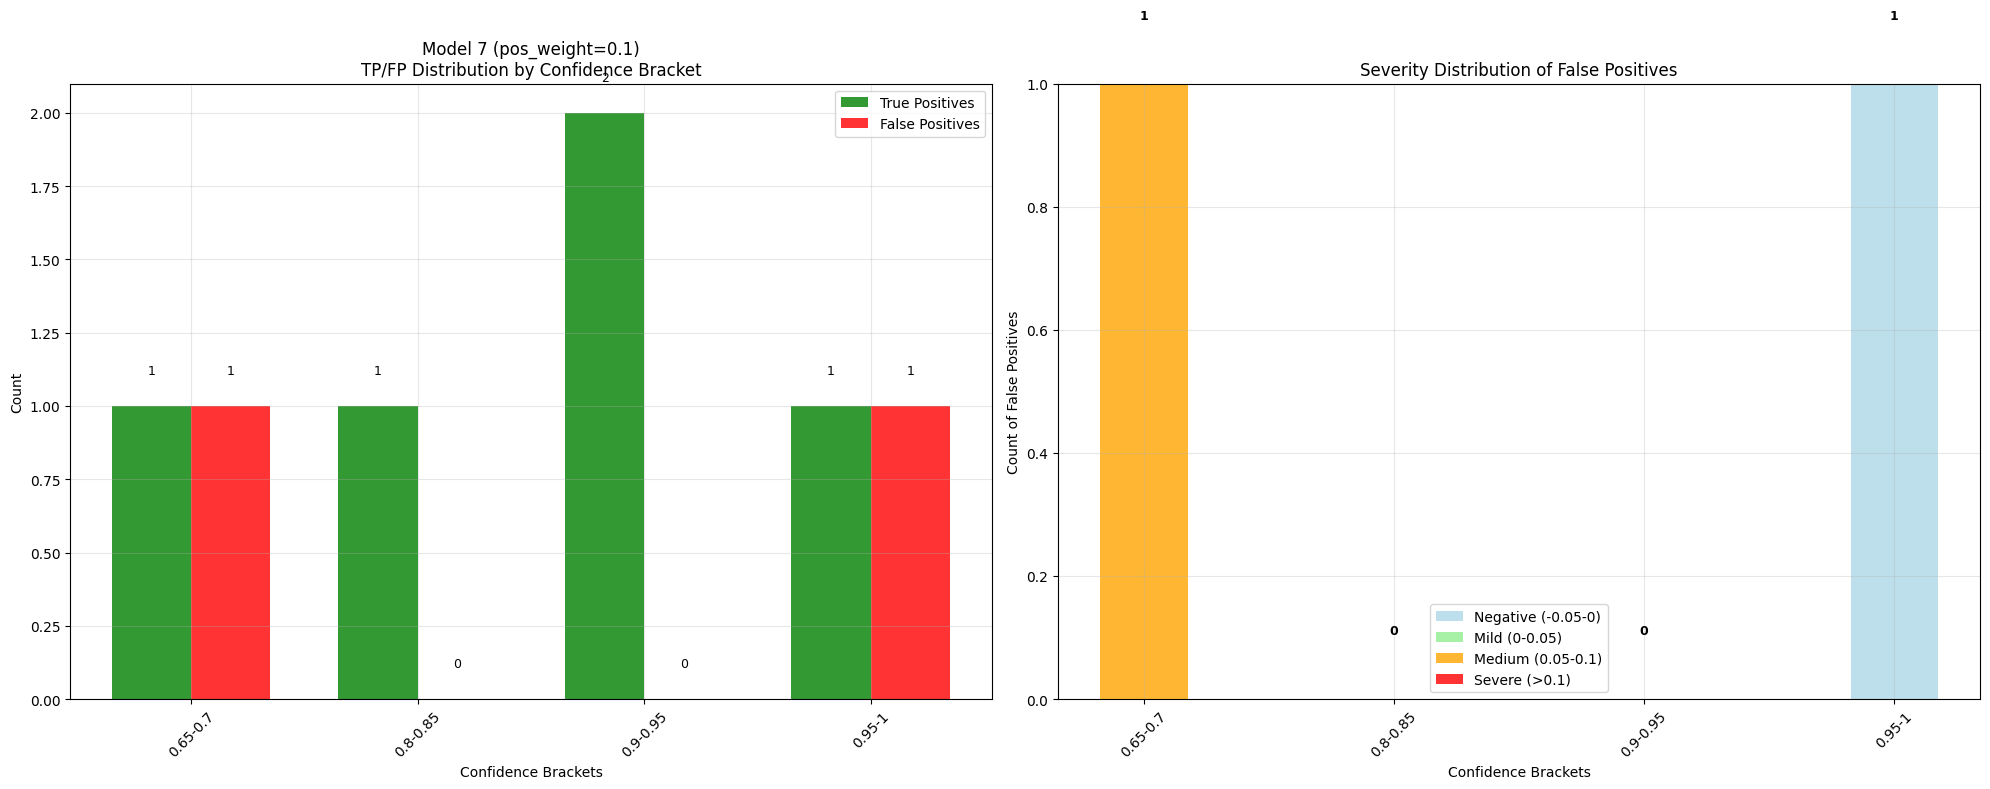


SUMMARY FOR MODEL 7 (pos_weight=0.1)
Total TP: 5, Total FP: 2, Precision: 0.714

Detailed breakdown by confidence bracket:

0.65-0.7: TP=1, FP=1, Total=2, Precision=0.500
  Medium (0.05-0.1): 1

0.8-0.85: TP=1, FP=0, Total=1, Precision=1.000

0.9-0.95: TP=2, FP=0, Total=2, Precision=1.000

0.95-1: TP=1, FP=1, Total=2, Precision=0.500
  Negative (-0.05-0): 1


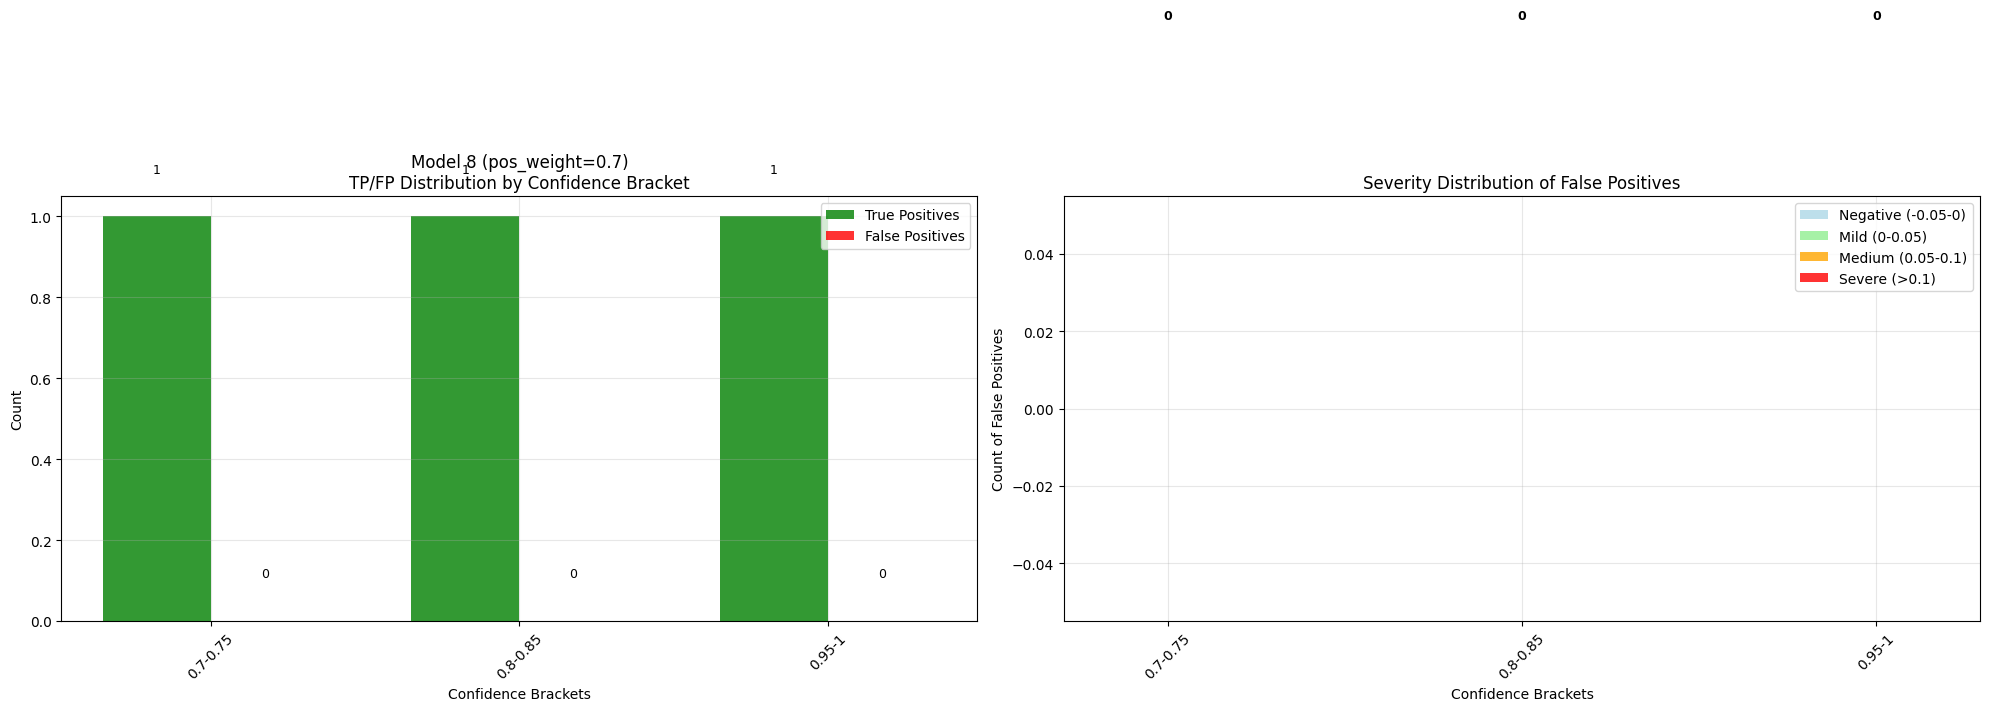


SUMMARY FOR MODEL 8 (pos_weight=0.7)
Total TP: 3, Total FP: 0, Precision: 1.000

Detailed breakdown by confidence bracket:

0.7-0.75: TP=1, FP=0, Total=1, Precision=1.000

0.8-0.85: TP=1, FP=0, Total=1, Precision=1.000

0.95-1: TP=1, FP=0, Total=1, Precision=1.000


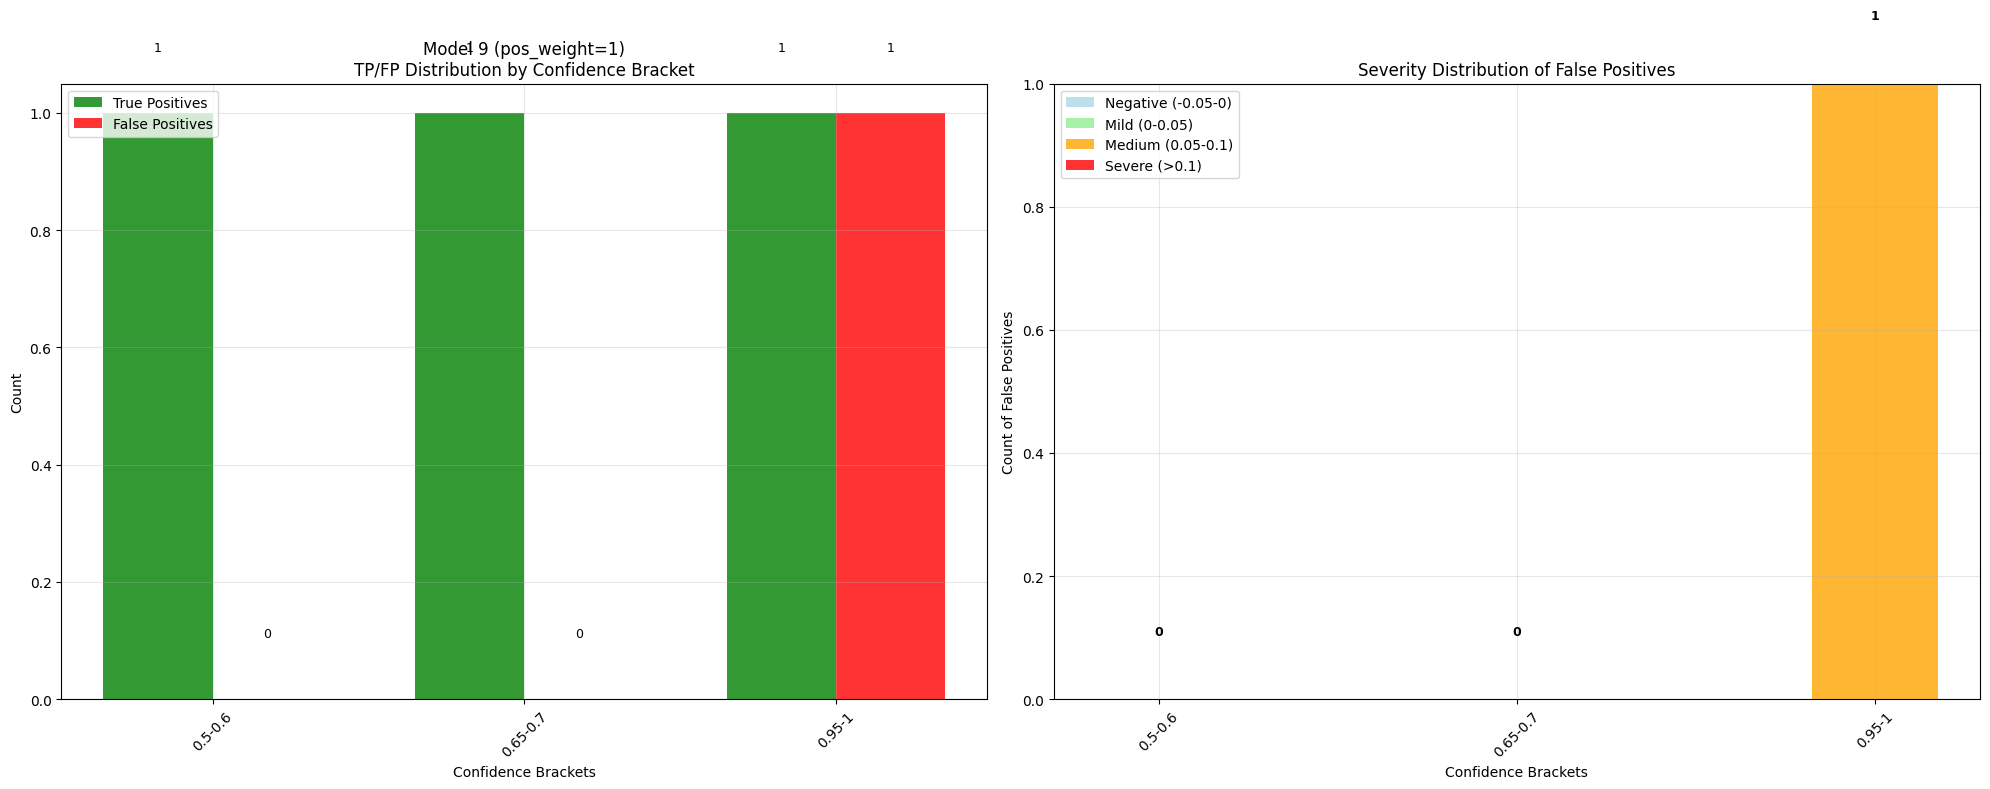


SUMMARY FOR MODEL 9 (pos_weight=1)
Total TP: 3, Total FP: 1, Precision: 0.750

Detailed breakdown by confidence bracket:

0.5-0.6: TP=1, FP=0, Total=1, Precision=1.000

0.65-0.7: TP=1, FP=0, Total=1, Precision=1.000

0.95-1: TP=1, FP=1, Total=2, Precision=0.500
  Medium (0.05-0.1): 1


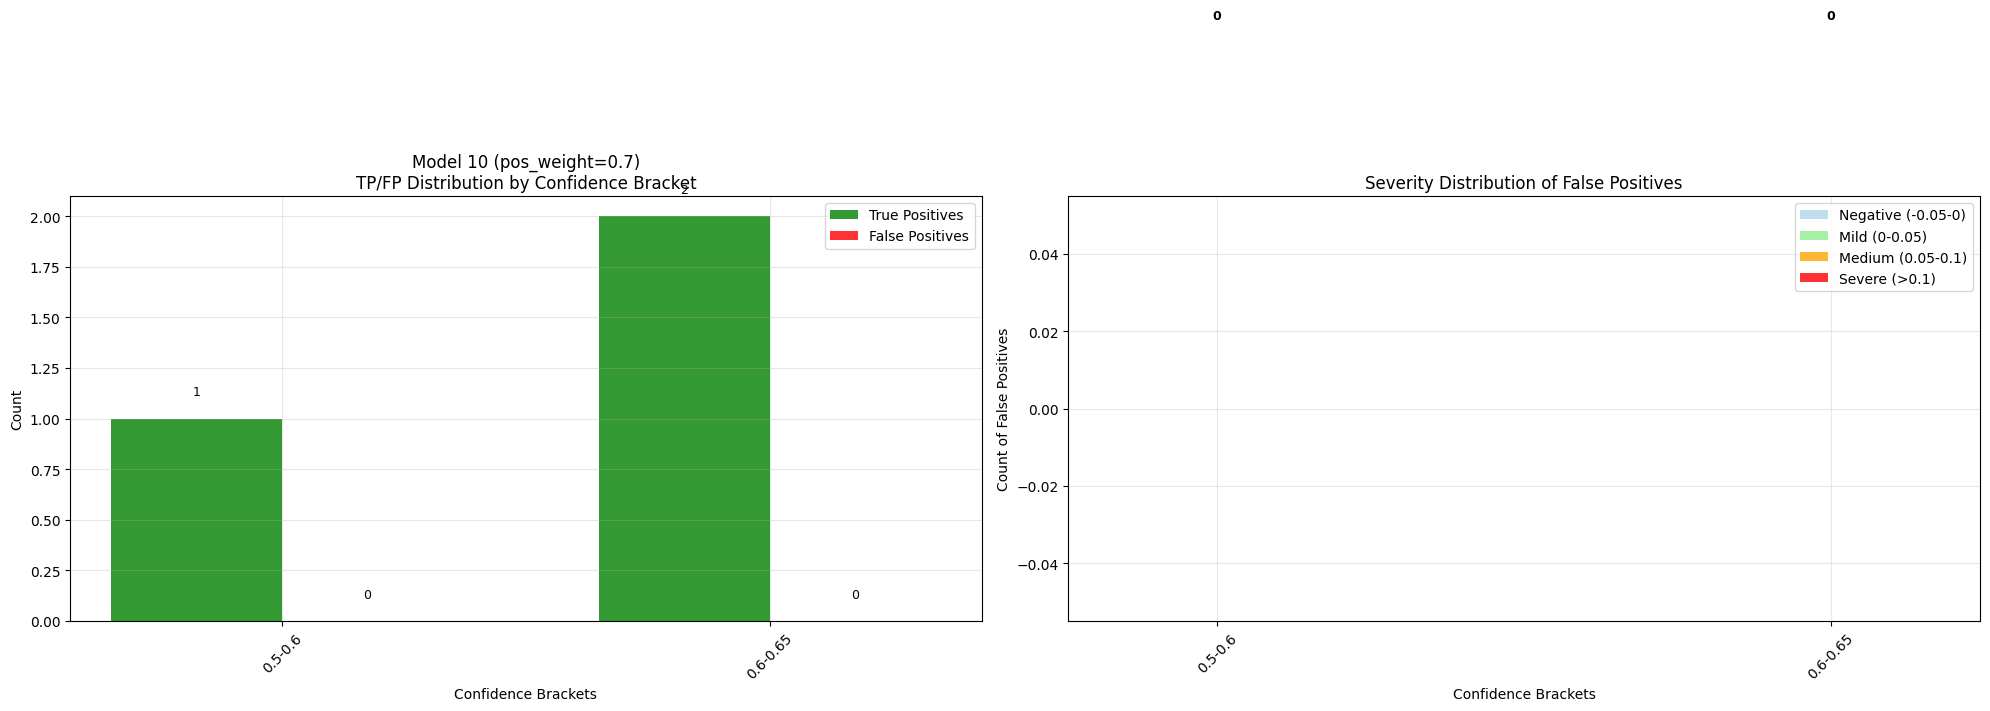


SUMMARY FOR MODEL 10 (pos_weight=0.7)
Total TP: 3, Total FP: 0, Precision: 1.000

Detailed breakdown by confidence bracket:

0.5-0.6: TP=1, FP=0, Total=1, Precision=1.000

0.6-0.65: TP=2, FP=0, Total=2, Precision=1.000


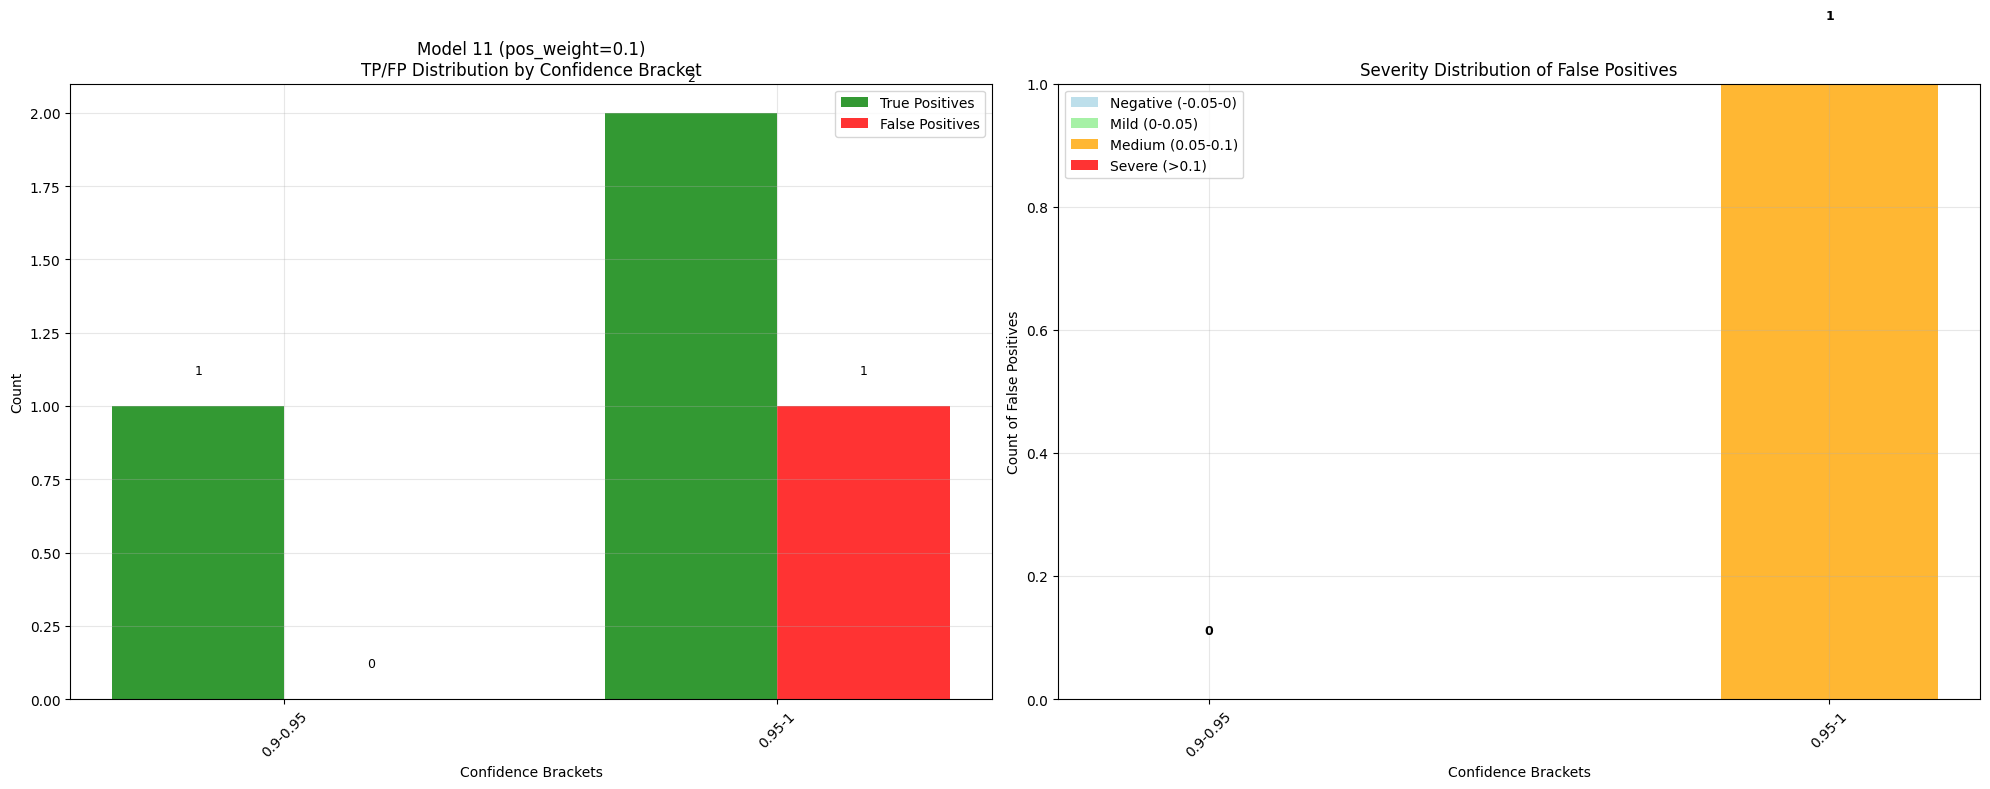


SUMMARY FOR MODEL 11 (pos_weight=0.1)
Total TP: 3, Total FP: 1, Precision: 0.750

Detailed breakdown by confidence bracket:

0.9-0.95: TP=1, FP=0, Total=1, Precision=1.000

0.95-1: TP=2, FP=1, Total=3, Precision=0.667
  Medium (0.05-0.1): 1


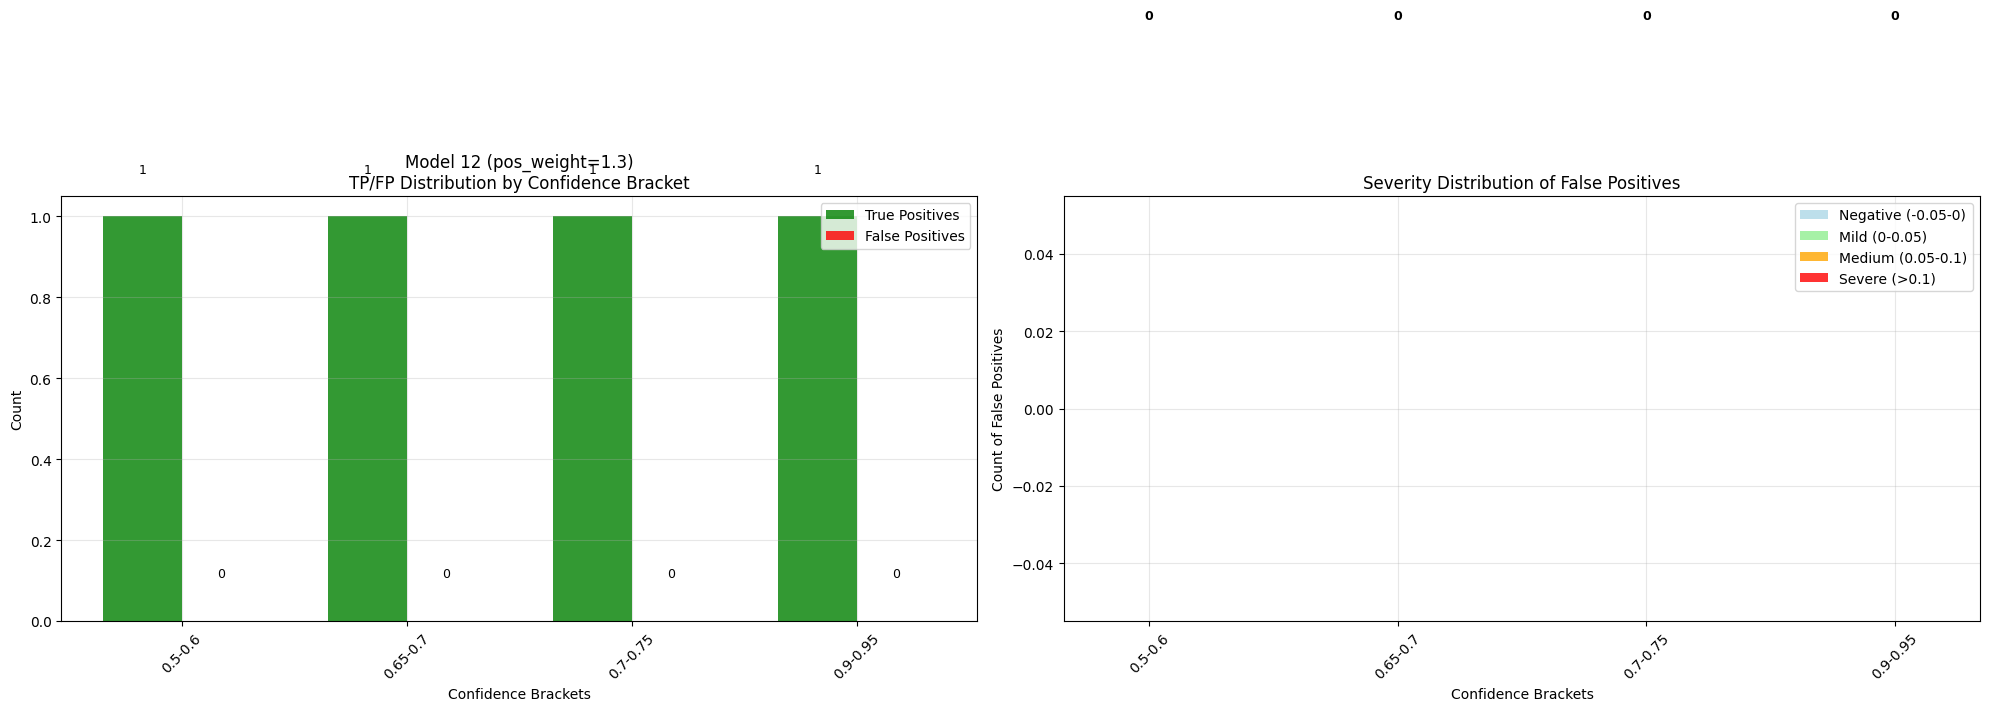


SUMMARY FOR MODEL 12 (pos_weight=1.3)
Total TP: 4, Total FP: 0, Precision: 1.000

Detailed breakdown by confidence bracket:

0.5-0.6: TP=1, FP=0, Total=1, Precision=1.000

0.65-0.7: TP=1, FP=0, Total=1, Precision=1.000

0.7-0.75: TP=1, FP=0, Total=1, Precision=1.000

0.9-0.95: TP=1, FP=0, Total=1, Precision=1.000


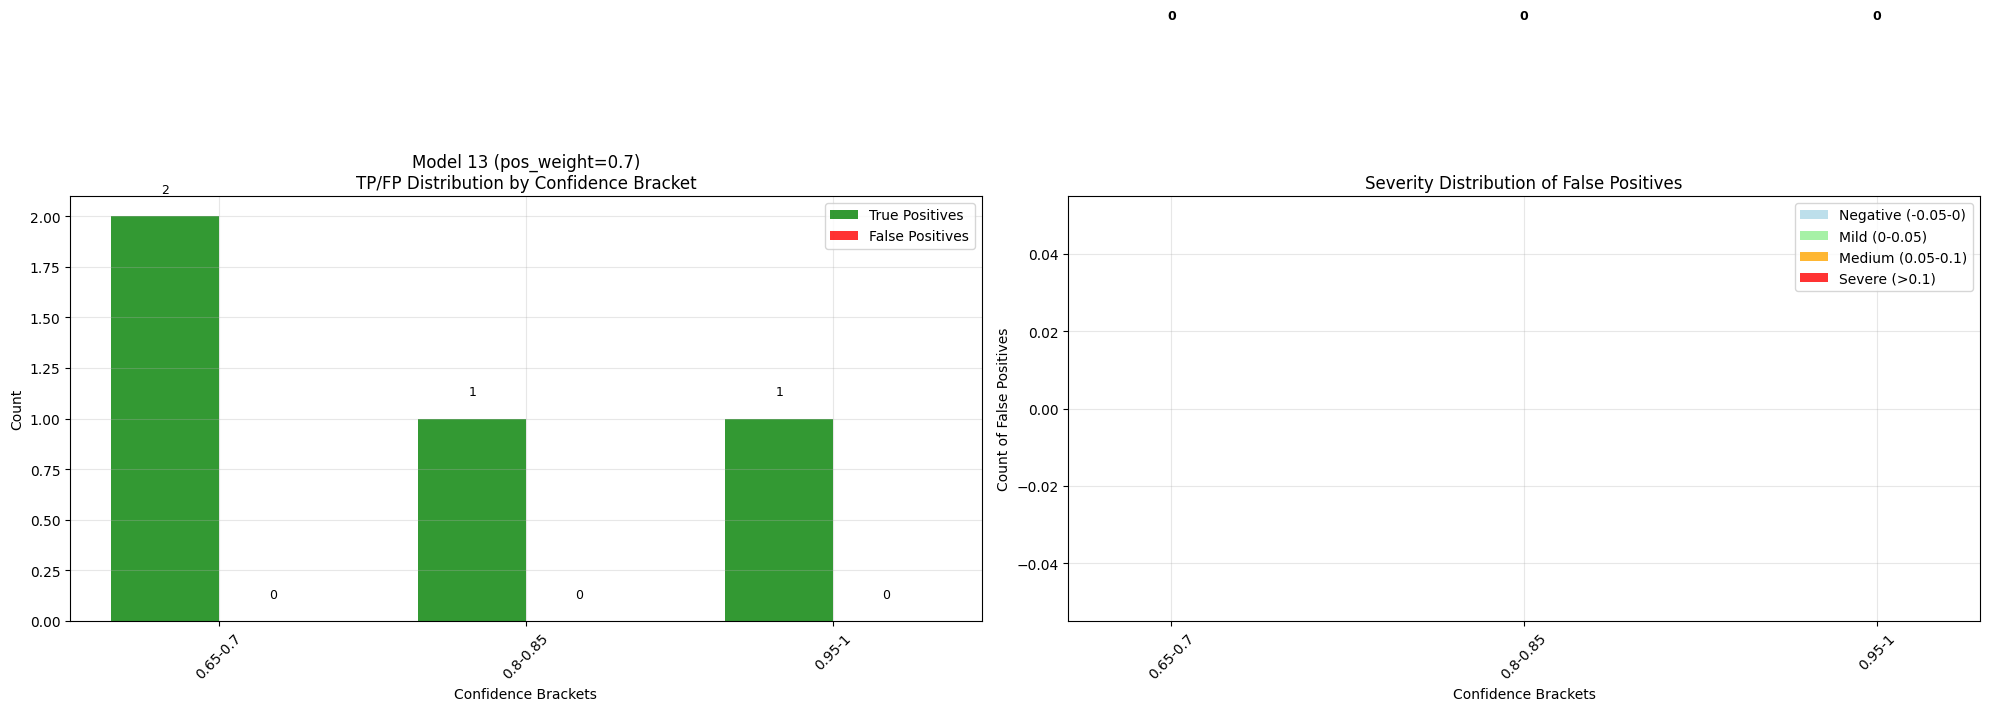


SUMMARY FOR MODEL 13 (pos_weight=0.7)
Total TP: 4, Total FP: 0, Precision: 1.000

Detailed breakdown by confidence bracket:

0.65-0.7: TP=2, FP=0, Total=2, Precision=1.000

0.8-0.85: TP=1, FP=0, Total=1, Precision=1.000

0.95-1: TP=1, FP=0, Total=1, Precision=1.000


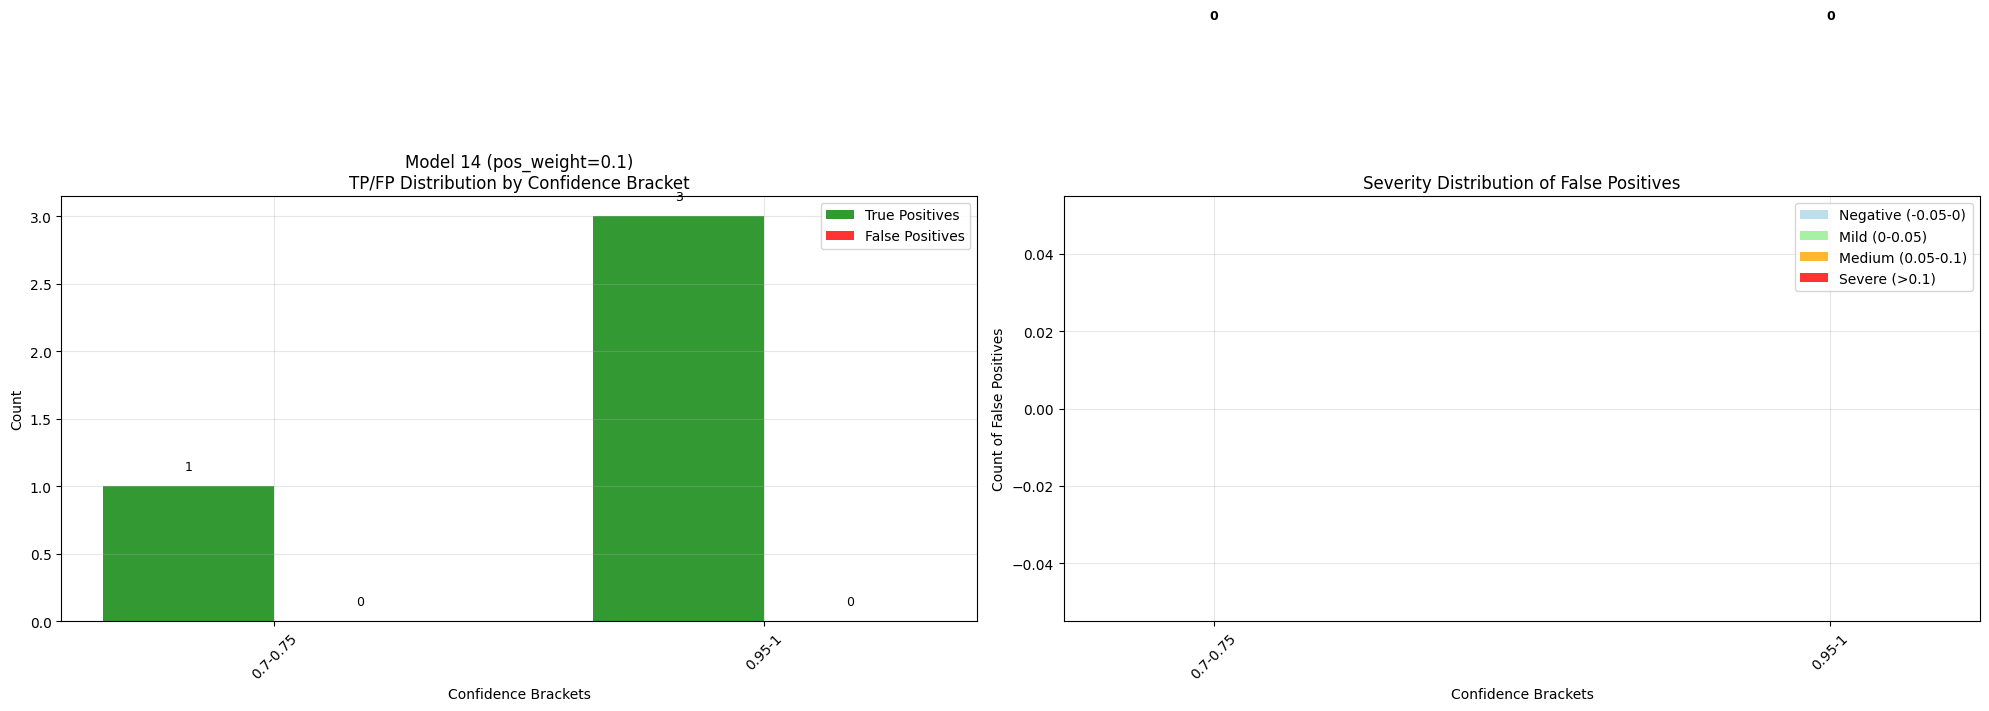


SUMMARY FOR MODEL 14 (pos_weight=0.1)
Total TP: 4, Total FP: 0, Precision: 1.000

Detailed breakdown by confidence bracket:

0.7-0.75: TP=1, FP=0, Total=1, Precision=1.000

0.95-1: TP=3, FP=0, Total=3, Precision=1.000


In [ ]:
#######             PURPOSE - FILER MODELS , MODEL BY MODEL, TO INCLUDE MODELS WITH CORR BETWEEN CORRECNESS AND CONFIDENCE BRACKET - THEN PLOTTING TP/FP AND SEVERITY DISTRIBUTIONS FOR EACH MODEL

## NOTE in the "GS+CV Results Dists V_2.ipynb" file the results after the deletion of models chosen below are plotted

## this analysis most be done in more robust fashion via dist discoery to discover loss function 

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd



def classify_severity(actual_value):
    """Classify actual values into severity categories"""
    if 0 >= actual_value >= -0.05:
        return "Negative (-0.05-0)"
    elif 0 < actual_value <= 0.05:
        return "Mild (0-0.05)"
    elif 0.05 < actual_value <= 0.1:
        return "Medium (0.05-0.1)"
    elif actual_value > 0.1:
        return "Severe (>0.1)"


def plot_model_fp_analysis(master_df, model_id, data_set_fold="V"):
    """
    Creates dual-plot analysis for a single model showing:
    - Left: FP/TP distribution by prediction confidence brackets
    - Right: Severity distribution of FPs by prediction confidence brackets
    """
    # Find the row for the specific model
    model_row = master_df[master_df[f"param_int_Vue_mac_{data_set_fold}"] == model_id]
    if len(model_row) == 0:
        print(f"Model {model_id} not found in dataset {data_set_fold}")
        return
    
    row = model_row.iloc[0]
    
    # Get model parameters
    params = row[f"parameters_mac_{data_set_fold}"]
    pos_weight = params.get('POS_weight_multiplier', 'N/A') if isinstance(params, dict) else 'N/A'
    
    # Get the data
    raw_actuals = row[f"raw_actuals_mac_{data_set_fold}"]
    binary_actuals = row[f"all_actuals_mac_{data_set_fold}"]
    preds = row[f"all_preds_mac_{data_set_fold}"]
    
    # Flatten all arrays
    flat_preds = [p for fold in preds for p in fold]
    flat_raw_actuals = [a for fold in raw_actuals for a in fold]
    flat_binary_actuals = [a for fold in binary_actuals for a in fold]
    
    # Initialize data structures
    bracket_counts = defaultdict(lambda: {'TP': 0, 'FP': 0})
    bracket_severity_counts = defaultdict(lambda: {
        'Negative (-0.05-0)': 0,
        'Mild (0-0.05)': 0, 
        'Medium (0.05-0.1)': 0,
        'Severe (>0.1)': 0
    })
    
    # Process each prediction
    for p, raw_a, bin_a in zip(flat_preds, flat_raw_actuals, flat_binary_actuals):
        # Find the confidence bracket
        bracket = None
        for L, H in logit_brackets_pred1:
            if L < p < H:
                bracket = f"{L}-{H}"
                break
        
        if bracket is None:
            continue
        
        # Classify as TP or FP
        if p > 0.5:
            if bin_a > 0.5:
                bracket_counts[bracket]['TP'] += 1
            else:
                bracket_counts[bracket]['FP'] += 1
                severity = classify_severity(raw_a)
                bracket_severity_counts[bracket][severity] += 1
    
    # Prepare data for plotting
    brackets = sorted(bracket_counts.keys(), key=lambda x: float(x.split('-')[0]))
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Left plot: TP/FP distribution
    tp_counts = [bracket_counts[b]['TP'] for b in brackets]
    fp_counts = [bracket_counts[b]['FP'] for b in brackets]
    
    x = np.arange(len(brackets))
    width = 0.35
    
    ax1.bar(x - width/2, tp_counts, width, label='True Positives', alpha=0.8, color='green')
    ax1.bar(x + width/2, fp_counts, width, label='False Positives', alpha=0.8, color='red')
    
    ax1.set_xlabel('Confidence Brackets')
    ax1.set_ylabel('Count')
    ax1.set_title(f'Model {model_id} (pos_weight={pos_weight})\nTP/FP Distribution by Confidence Bracket')
    ax1.set_xticks(x)
    ax1.set_xticklabels(brackets, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add counts on bars
    for i, (tp, fp) in enumerate(zip(tp_counts, fp_counts)):
        ax1.text(i - width/2, tp + 0.1, str(tp), ha='center', va='bottom', fontsize=9)
        ax1.text(i + width/2, fp + 0.1, str(fp), ha='center', va='bottom', fontsize=9)
    
    # Right plot: Severity distribution of FPs
    severity_categories = ["Negative (-0.05-0)", "Mild (0-0.05)", "Medium (0.05-0.1)", "Severe (>0.1)"]
    colors = ['lightblue', 'lightgreen', 'orange', 'red']
    
    # Prepare severity data
    severity_data = {category: [] for category in severity_categories}
    for bracket in brackets:
        for category in severity_categories:
            severity_data[category].append(bracket_severity_counts[bracket][category])
    
    # Create stacked bar plot for severity
    bottom = np.zeros(len(brackets))
    for i, category in enumerate(severity_categories):
        counts = severity_data[category]
        ax2.bar(x, counts, width, bottom=bottom, label=category, alpha=0.8, color=colors[i])
        bottom += counts
    
    ax2.set_xlabel('Confidence Brackets')
    ax2.set_ylabel('Count of False Positives')
    ax2.set_title('Severity Distribution of False Positives')
    ax2.set_xticks(x)
    ax2.set_xticklabels(brackets, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add total FP counts on top of severity bars
    total_fp_counts = [sum(bracket_severity_counts[b].values()) for b in brackets]
    for i, total in enumerate(total_fp_counts):
        ax2.text(i, total + 0.1, str(total), ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*80}")
    print(f"SUMMARY FOR MODEL {model_id} (pos_weight={pos_weight})")
    print(f"{'='*80}")
    
    total_tp = sum(tp_counts)
    total_fp = sum(fp_counts)
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    
    print(f"Total TP: {total_tp}, Total FP: {total_fp}, Precision: {precision:.3f}")
    print("\nDetailed breakdown by confidence bracket:")
    for bracket in brackets:
        tp = bracket_counts[bracket]['TP']
        fp = bracket_counts[bracket]['FP']
        total = tp + fp
        bracket_precision = tp / total if total > 0 else 0
        print(f"\n{bracket}: TP={tp}, FP={fp}, Total={total}, Precision={bracket_precision:.3f}")
        for severity in severity_categories:
            count = bracket_severity_counts[bracket][severity]
            if count > 0:
                print(f"  {severity}: {count}")

# Example usage:
# Plot analysis for specific models



DATA_SET_FOLD = "V"


for model_id in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
    plot_model_fp_analysis(master_df, model_id, DATA_SET_FOLD)



# ### Models to drop 

# # model -[ 0  , 2, 3 , 9 ]
# models_to_delete = [ 0  , 2, 3 , 9 ]
# allowed = set(master_df["param_int_Vue_mac_T"]) - set(models_to_delete)
# master_df_T_thresh_corr = master_df[master_df["param_int_Vue_mac_T"].isin(allowed)]

# master_df_T_thresh_corr["param_int_Vue_mac_T"].tolist()

---
# Analysis after removing models with no corr btwn accuracy and greater thersh val bracket  
---

In [ ]:
import numpy as np
from itertools import combinations
from collections import Counter
import random

# random.seed(402





models_to_delete = [0,2,3,9]

allowed = set(master_df["param_int_Vue_mac_V"]) - set(models_to_delete)
master_df_V_thresh_corr = master_df[master_df["param_int_Vue_mac_V"].isin(allowed)]

master_df_V_thresh_corr["parameters_mac_V"]


n_random = 10
n_random_2 = 10
#  ----------------- Groups of size 2
groups_2_neg03_01 = get_model_groups_in_corr_range(master_df_V_thresh_corr, "mac", "V", (-0.3, 0.1), group_size=2) 
groups_2_01_03    = get_model_groups_in_corr_range(master_df_V_thresh_corr, "mac", "V", (0.1, 0.3), group_size=2) 
groups_2_03_05    = get_model_groups_in_corr_range(master_df_V_thresh_corr, "mac", "V", (0.3, 0.5), group_size=2) 
# groups_2_04_07    = get_model_groups_in_corr_range(master_df_V_thresh_corr, "mac", "V", (0.6, 0.7), group_size=2) 

# Randomly select 10 from each group
random_2_neg03_01 = random.sample(groups_2_neg03_01, min(n_random_2, len(groups_2_neg03_01))) if groups_2_neg03_01 else []
random_2_01_03    = random.sample(groups_2_01_03, min(n_random_2, len(groups_2_01_03))) if groups_2_01_03 else []
random_2_03_05    = random.sample(groups_2_03_05, min(n_random_2, len(groups_2_03_05))) if groups_2_03_05 else []
# random_2_04_07    = random.sample(groups_2_04_07, min(n_random_2, len(groups_2_04_07))) if groups_2_04_07 else []

# ------------------ Groups of size 3
groups_3_neg03_01 = get_model_groups_in_corr_range(master_df_V_thresh_corr, "mac", "V", (-0.3, 0.1), group_size=3)
groups_3_01_03    = get_model_groups_in_corr_range(master_df_V_thresh_corr, "mac", "V", (0.1, 0.3), group_size=3) 
groups_3_03_05    = get_model_groups_in_corr_range(master_df_V_thresh_corr, "mac", "V", (0.3, 0.5), group_size=3) 
# groups_3_04_07    = get_model_groups_in_corr_range(master_df_V_thresh_corr, "mac", "V", (0.6, 0.7), group_size=3)



# Randomly select 10 from each group
random_3_neg03_01 = random.sample(groups_3_neg03_01, min(n_random, len(groups_3_neg03_01))) if groups_3_neg03_01 else []
random_3_01_03    = random.sample(groups_3_01_03, min(n_random, len(groups_3_01_03))) if groups_3_01_03 else []
random_3_03_05    = random.sample(groups_3_03_05, min(n_random, len(groups_3_03_05))) if groups_3_03_05 else []
# random_3_04_07    = random.sample(groups_3_04_07, min(n_random, len(groups_3_04_07))) if groups_3_04_07 else []
# # ------------------ Groups of size 4
# groups_4_neg01_00 = get_model_groups_in_corr_range(master_df, "mac", "V", (-0.1, 0.0), group_size=4)
# groups_4_00_02    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.0, 0.2), group_size=4) 
# groups_4_02_04    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.2, 0.4), group_size=4)
# groups_4_04_07    = get_model_groups_in_corr_range(master_df, "mac", "V", (0.4, 0.7), group_size=4)

# # Randomly select 10 from each group
# random_4_neg01_00 = random.sample(groups_4_neg01_00, min(n_random, len(groups_4_neg01_00))) if groups_4_neg01_00 else []
# random_4_00_02    = random.sample(groups_4_00_02, min(n_random, len(groups_4_00_02))) if groups_4_00_02 else []
# random_4_02_04    = random.sample(groups_4_02_04, min(n_random, len(groups_4_02_04))) if groups_4_02_04 else []
# random_4_04_07    = random.sample(groups_4_04_07, min(n_random, len(groups_4_04_07))) if groups_4_04_07 else []

# ------------------- CHECK 
print("Size 2 groups:")
print(len(groups_2_neg03_01))
print(len(groups_2_01_03))
print(len(groups_2_03_05))
# print(len(random_2_04_07))
print('----')
print("Size 3 groups:")
print(len(groups_3_neg03_01))
print(len(groups_3_01_03))
print(len(groups_3_03_05))
# print(len(random_3_04_07))
print('----')
# print("Size 4 groups:")
# print(len(random_4_neg01_00))
# print(len(random_4_00_02))
# print(len(random_4_02_04))
# print(len(random_4_04_07))


Size 2 groups:
13
14
17
----
Size 3 groups:
1
0
4
----


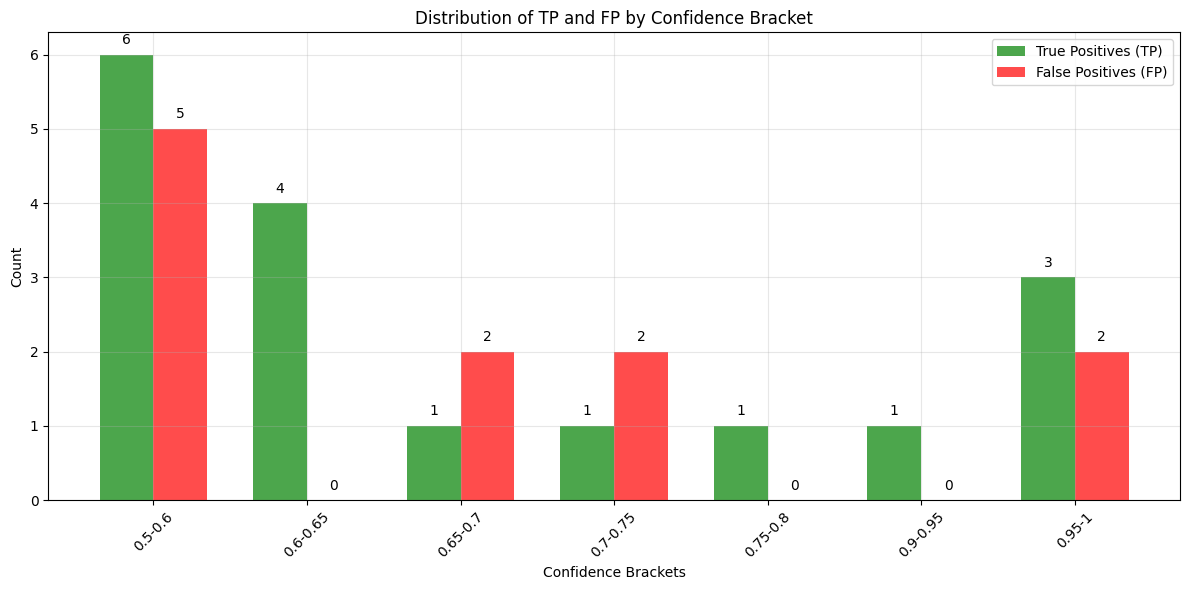

Summary by Confidence Bracket:
----------------------------------------
0.5-0.6: TP=6, FP=5, Total=11, Precision=0.545
0.6-0.65: TP=4, FP=0, Total=4, Precision=1.000
0.65-0.7: TP=1, FP=2, Total=3, Precision=0.333
0.7-0.75: TP=1, FP=2, Total=3, Precision=0.333
0.75-0.8: TP=1, FP=0, Total=1, Precision=1.000
0.9-0.95: TP=1, FP=0, Total=1, Precision=1.000
0.95-1: TP=3, FP=2, Total=5, Precision=0.600


In [ ]:
###                             THRESH AND PRED CORR FILTER TESTING TESTING TESTING 
###     CONVERTED TO USE MASTER DF INSTEAD 
###     CONVERTED TO USE MASTER DF INSTEAD 


logit_brackets_pred1 =  [(0.5, 0.6), (0.6, 0.65), (0.65, 0.7), 
                         (0.7, 0.75) , (0.75, 0.8) , (0.8, 0.85), (0.85, 0.9), (0.9, 0.95) , (0.95, 1)]
data_dict_bar_chart = {}


DATA_SET_FOLD = "T"

for act , pred , param_int in zip(master_df_V_thresh_corr[f"all_actuals_mac_{DATA_SET_FOLD}"] , master_df_V_thresh_corr[f"all_preds_mac_{DATA_SET_FOLD}"],  master_df_V_thresh_corr[f"param_int_Vue_mac_{DATA_SET_FOLD}"]):
    flat_preds = [i for part in pred for i in part]
    flat_actuals = [i for part in act for i in part]
    for p , a in zip(flat_preds, flat_actuals):

        if (p > 0.5 and a > 0.5):
            for tup in logit_brackets_pred1:
                for L , H in [tup]:
                    if L < p < H:
                        #check if dict if empty first , vals should not be replaced 
                        if f"{L}-{H}-{param_int}" in data_dict_bar_chart:
                            data_dict_bar_chart[f"{L}-{H}-{param_int}"].append("TP")
                        else:
                            data_dict_bar_chart[f"{L}-{H}-{param_int}"] = ["TP"]

        if (p > 0.5 and a < 0.5):
            for tup in logit_brackets_pred1:
                for L , H in [tup]:
                    if L < p < H:
                        if f"{L}-{H}-{param_int}" in data_dict_bar_chart:
                            data_dict_bar_chart[f"{L}-{H}-{param_int}"].append("FP")
                        else:
                            data_dict_bar_chart[f"{L}-{H}-{param_int}"] = ["FP"]




data_dict_bar_chart

# ###     CONVERTED TO USE MASTER DF INSTEAD 
# ###     CONVERTED TO USE MASTER DF INSTEAD 
# ###                             THRESH AND PRED CORR FILTER TESTING TESTING TESTING 




import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Extract bracket counts from your data_dict_bar_chart
bracket_counts = defaultdict(lambda: {'TP': 0, 'FP': 0})

for key, values in data_dict_bar_chart.items():
    # Extract just the bracket part (ignore the model number)
    bracket = '-'.join(key.split('-')[:2])
    
    # Count TP and FP
    for value in values:
        if value == 'TP':
            bracket_counts[bracket]['TP'] += 1
        elif value == 'FP':
            bracket_counts[bracket]['FP'] += 1

# Prepare data for plotting
brackets = sorted(bracket_counts.keys(), key=lambda x: float(x.split('-')[0]))
tp_counts = [bracket_counts[b]['TP'] for b in brackets]
fp_counts = [bracket_counts[b]['FP'] for b in brackets]

# Create the plot
plt.figure(figsize=(12, 6))

x = np.arange(len(brackets))
width = 0.35

plt.bar(x - width/2, tp_counts, width, label='True Positives (TP)', alpha=0.7, color='green')
plt.bar(x + width/2, fp_counts, width, label='False Positives (FP)', alpha=0.7, color='red')

plt.xlabel('Confidence Brackets')
plt.ylabel('Count')
plt.title('Distribution of TP and FP by Confidence Bracket')
plt.xticks(x, brackets, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Add total counts on top of bars
for i, (tp, fp) in enumerate(zip(tp_counts, fp_counts)):
    plt.text(i - width/2, tp + 0.1, str(tp), ha='center', va='bottom')
    plt.text(i + width/2, fp + 0.1, str(fp), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary by Confidence Bracket:")
print("-" * 40)
for bracket in brackets:
    tp = bracket_counts[bracket]['TP']
    fp = bracket_counts[bracket]['FP']
    total = tp + fp
    precision = tp / total if total > 0 else 0
    print(f"{bracket}: TP={tp}, FP={fp}, Total={total}, Precision={precision:.3f}")

FP actual raw: 0.14319526627218937, pred: 0.5053175091743469, act: 0.0, severity: Severe (>0.1)
FP actual raw: 0.060271451575799606, pred: 0.5134336948394775, act: 0.0, severity: Medium (0.05-0.1)
FP actual raw: -0.022367913613575152, pred: 0.6994616985321045, act: 0.0, severity: Negative (-0.05-0)
FP actual raw: 0.14319526627218937, pred: 0.7354041337966919, act: 0.0, severity: Severe (>0.1)
FP actual raw: 0.060271451575799606, pred: 0.7475719451904297, act: 0.0, severity: Medium (0.05-0.1)
FP actual raw: 0.10238210986874097, pred: 0.6733989119529724, act: 0.0, severity: Severe (>0.1)
FP actual raw: -0.04850943729052748, pred: 0.5681711435317993, act: 0.0, severity: Negative (-0.05-0)
FP actual raw: -0.022367913613575152, pred: 0.9981355667114258, act: 0.0, severity: Negative (-0.05-0)
FP actual raw: -0.022367913613575152, pred: 0.9867900013923645, act: 0.0, severity: Negative (-0.05-0)
FP actual raw: -0.022367913613575152, pred: 0.5096827745437622, act: 0.0, severity: Negative (-0.05

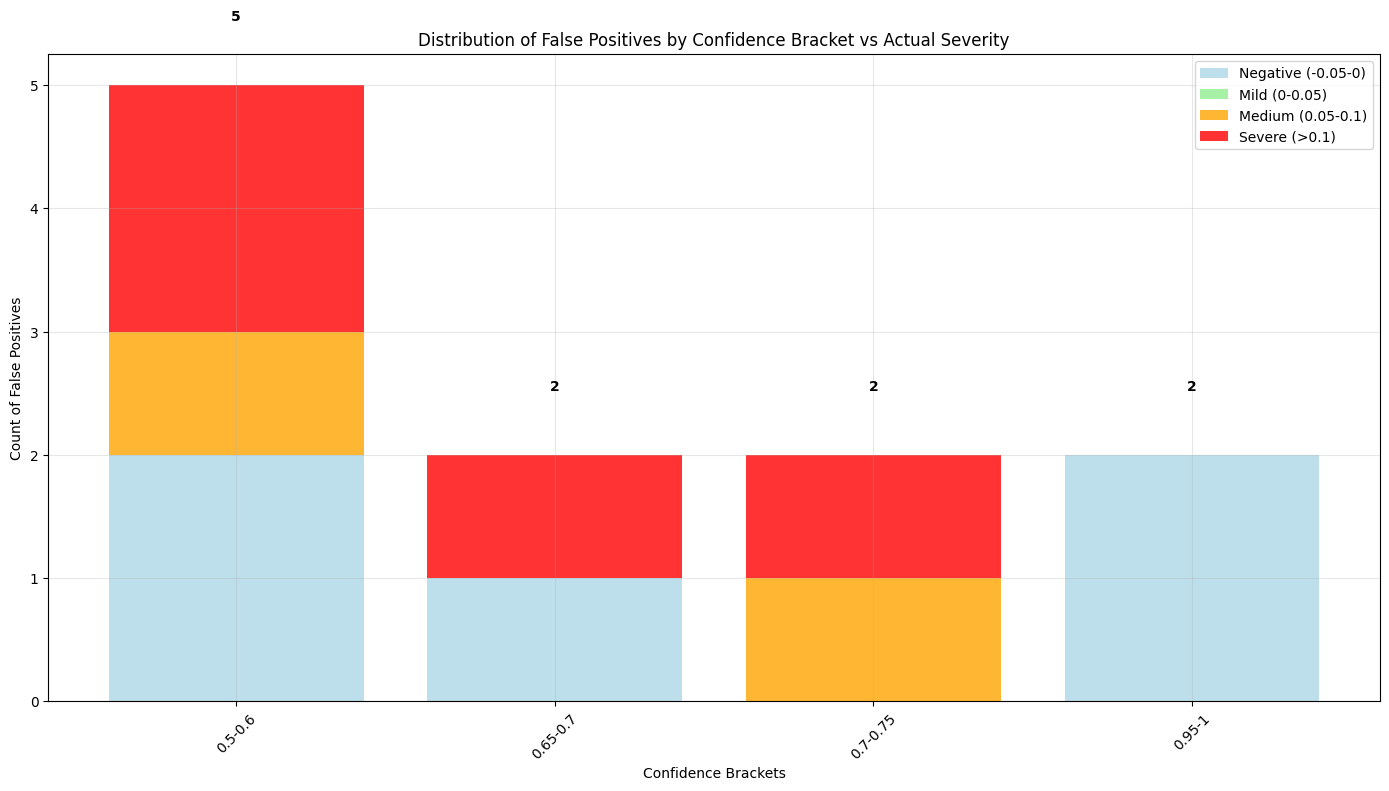

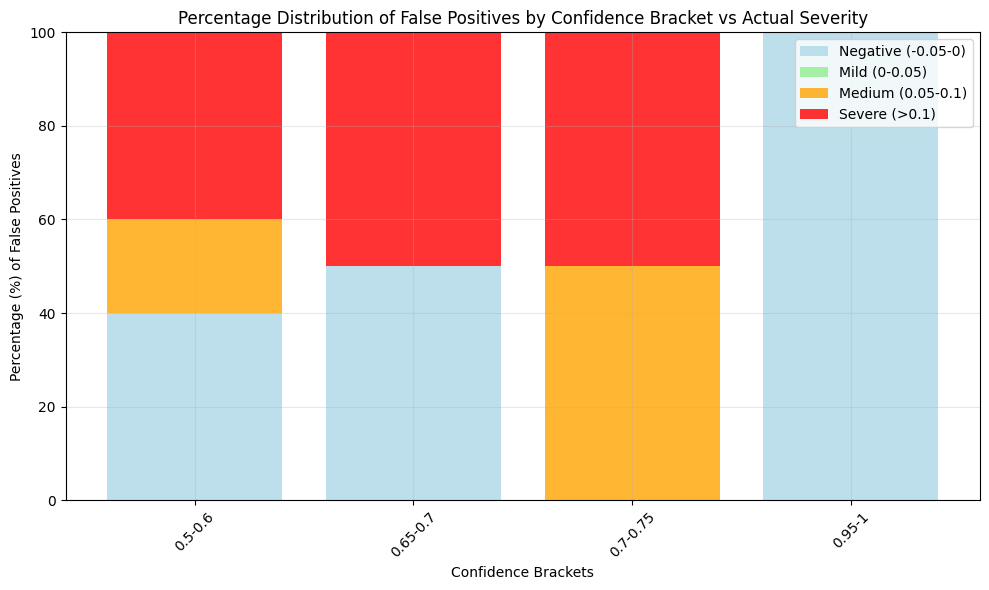

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict


DATA_SET_FOLD = "T"

def classify_severity(actual_value):
    """Classify actual values into severity categories"""
    if 0 >= actual_value >= -0.05:
        return "Negative (-0.05-0)"
    elif 0 < actual_value <= 0.05:
        return "Mild (0-0.05)"
    elif 0.05 < actual_value <= 0.1:
        return "Medium (0.05-0.1)"
    elif actual_value > 0.1:
        return "Severe (>0.1)"

# Extract bracket counts with severity information - ONLY FOR FALSE POSITIVES
bracket_severity_counts = defaultdict(lambda: {
    'Negative (-0.05-0)': 0,
    'Mild (0-0.05)': 0, 
    'Medium (0.05-0.1)': 0,
    'Severe (>0.1)': 0
})

# Process the original data to get actual values - ONLY FALSE POSITIVES
for act, pred, raw_act, param_int in zip(master_df_V_thresh_corr[f"all_actuals_mac_{DATA_SET_FOLD}"], 
                               master_df_V_thresh_corr[f"all_preds_mac_{DATA_SET_FOLD}"],  
                               master_df_V_thresh_corr[f"raw_actuals_mac_{DATA_SET_FOLD}"],
                               master_df_V_thresh_corr[f"param_int_Vue_mac_{DATA_SET_FOLD}"]):

    flat_preds = [i for part in pred for i in part]
    flat_actuals = [i for part in act for i in part]
    flat_raw_actuals = [i for part in raw_act for i in part]

    for p, a , a_raw in zip(flat_preds, flat_actuals, flat_raw_actuals):
        # ONLY FALSE POSITIVES: prediction > 0.5 BUT actual <= 0.5
        if p > 0.5 and a < 0.5:

            severity = classify_severity(a_raw)
            print(f"FP actual raw: {a_raw}, pred: {p}, act: {a}, severity: {severity}")


            # Find which bracket this prediction falls into
            for L, H in logit_brackets_pred1:
                if L < p < H:
                    bracket = f"{L}-{H}"
                    bracket_severity_counts[bracket][severity] += 1
                    break

# Prepare data for plotting
brackets = sorted(bracket_severity_counts.keys(), key=lambda x: float(x.split('-')[0]))
severity_categories = ["Negative (-0.05-0)", "Mild (0-0.05)", "Medium (0.05-0.1)", "Severe (>0.1)"]

# Create counts for each severity category by bracket
counts_by_severity = {category: [] for category in severity_categories}
for bracket in brackets:
    for category in severity_categories:
        counts_by_severity[category].append(bracket_severity_counts[bracket][category])

# Create the stacked bar plot - ONLY FALSE POSITIVES
plt.figure(figsize=(14, 8))

x = np.arange(len(brackets))
width = 0.8
bottom = np.zeros(len(brackets))

colors = ['lightblue', 'lightgreen', 'orange', 'red']

for i, category in enumerate(severity_categories):
    counts = counts_by_severity[category]
    plt.bar(x, counts, width, bottom=bottom, label=category, alpha=0.8, color=colors[i])
    bottom += counts

plt.xlabel('Confidence Brackets')
plt.ylabel('Count of False Positives')
plt.title('Distribution of False Positives by Confidence Bracket vs Actual Severity')
plt.xticks(x, brackets, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Add total counts on top of bars
total_counts = [sum(bracket_severity_counts[bracket].values()) for bracket in brackets]
for i, total in enumerate(total_counts):
    plt.text(i, total + 0.5, str(total), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# # Print summary statistics - ONLY FALSE POSITIVES
# print("Summary of FALSE POSITIVES by Confidence Bracket and Severity:")
# print("-" * 70)
# for bracket in brackets:
#     total = sum(bracket_severity_counts[bracket].values())
#     print(f"\n{bracket}: Total FP={total}")
#     for severity in severity_categories:
#         count = bracket_severity_counts[bracket][severity]
#         percentage = (count / total * 100) if total > 0 else 0
#         print(f"  {severity}: {count} ({percentage:.1f}%)")

# Additional: Create a normalized stacked bar plot to see proportions
plt.figure(figsize=(10, 6))

# Calculate percentages
percentages_by_severity = {category: [] for category in severity_categories}
for bracket in brackets:
    total = sum(bracket_severity_counts[bracket].values())
    for category in severity_categories:
        percentage = (bracket_severity_counts[bracket][category] / total * 100) if total > 0 else 0
        percentages_by_severity[category].append(percentage)

# Create normalized stacked bar plot
bottom = np.zeros(len(brackets))
for i, category in enumerate(severity_categories):
    percentages = percentages_by_severity[category]
    plt.bar(x, percentages, width, bottom=bottom, label=category, alpha=0.8, color=colors[i])
    bottom += percentages



plt.xlabel('Confidence Brackets')
plt.ylabel('Percentage (%) of False Positives')
plt.title('Percentage Distribution of False Positives by Confidence Bracket vs Actual Severity')
plt.xticks(x, brackets, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

---
# Analysis - Check if Custom Loss function improves thresh and precision correlation 

### - THE IDEA - so far in the analysis we are choosing models that behave desirably based on discovery! The more robust way to do this is via a custom loss fucntion where you attempt to force the fucntion to behave desirably, then run discovery methods 
---

In [ ]:
from Equations_Run_Combo_V_2 import *
import copy
###                             FIRST

import itertools
import math 
from joblib import parallel_backend , Parallel , delayed 
import random 

######    GS 

param_grid = {
    "learning_rate": [0.05, 0.005, 0.0005],
    "num_epochs": [ 70, 150, 300, 700],
    "batch_size": [10, 30, 50],
    "use_bidirectional": [False],
    "lag": [ 2, 3, 6],
    "input_size": [12],
    "hidden_size": [ 12, 20, 35, 55],
    "num_layers": [1, 2, 4 , 6],
                                            "use_monthly_dfs_only": [True],
    
                                            "use_binary_0_1": [False],
    "use_binary_neg1_1": [False],  # still to be investigated
    "use_ret_rate": [False],       # still to be investigated
    "use_print_acc": [False],      # still to be investigated
    "use_dropout": [False],         # still to be investigated
    # "iter_per_valSET": [1],        # still to be investigated
    "use_class_weighting": [True],
    # missing params 
    "is_deterministic": [True],     
    "seed_num": [42],       


    "use_monthly_predictor": [False],
    
    "use_existing_lagged_data": [True],
    'use_dynamic_weights' : [False] ,

########################################################################################

    'use_monthly_daily_end_mo_predictor' : [False], 
    'use_monthly_weekly_end_mo_predictor' : [True]  ,  

    'use_binary_0_1_custom_neg' : [True] ,
    'use_binary_0_1_custom_pos' : [False] ,
    
    'binary_0_1_cutoff_ret_rate_percentage' : [.05],  ### cutoff for the  use_binary_0_1_custom_pos ot use_binary_0_1_custom_neg
    'end_value_train_set_fraction' : [0.85], 
    'val_set_fraction' : [0.1], 
    'num_folds' : [8]  , 
    'POS_weight_multiplier' : [1] , ## 24 vals is val set, 3 units per ser fi folds are 8 
    'use_rolling_fixed_train_size' : [False,True],
    'use_existing_initial_weights': [False], 
    'state_dict' : [None]
        
        }   


# --- Prepare all combinations ---
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]


def random_subset( data , seed = 42 ) :
    random.seed(seed)
    n_keep = int(len(data))
    return random.sample(data, n_keep)


# --- Split combinations into chunks ---
def split_into_chunks(lst, n_chunks):
    chunk_size = len(lst) // n_chunks
    chunks = []
    for i in range(n_chunks):
        start = i * chunk_size
        end = (i + 1) * chunk_size if i < n_chunks - 1 else len(lst)
        chunks.append(lst[start:end])
    return chunks


random_subset_combos = random_subset(combinations, seed=42)

random_subset_combos_short = random_subset_combos[:400]


random_subset_combos_short_normal = []
random_subset_combos_short_custom = []


for param in copy.deepcopy(random_subset_combos_short):
    param["use_custom_loss_function"] = False
    param["pred_threshold_sigmoid01_up"] = None
    random_subset_combos_short_normal.append(param)

for param in copy.deepcopy(random_subset_combos_short):
    param["use_custom_loss_function"] = True
    param["pred_threshold_sigmoid01_up"] = None
    random_subset_combos_short_custom.append(param)






In [3]:
import json

with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/GC_thresh_analysis_400_combos/GC_thresh_analysis_400_combos_BCE_LOSS_LOW_penalization.json', 'r') as f:
    default_res = json.load(f)

with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/GC_thresh_analysis_400_combos/GC_thresh_analysis_400_combos_CUSTOM_LOSS_THRESH_LOW_penalization.json', 'r') as f:
    custom_res_thresh_low = json.load(f)



with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/GC_thresh_analysis_400_combos/GC_thresh_analysis_400_combos_CUSTOM_LOSS_THRESH_SEVERITY_LOW_penalization__SEVfactor_1pt5.json', 'r') as f:
    custom_res_thresh_severity_1pt5 = json.load(f)

with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/GC_thresh_analysis_400_combos/GC_thresh_analysis_400_combos_CUSTOM_LOSS_THRESH_HIGH_penalization.json', 'r') as f:
    custom_res_thresh_high = json.load(f)

with open('/Users/cs/Desktop/Project_DATA_LSTM_Spot_Price_WTI/GC_thresh_analysis_400_combos/GC_thresh_analysis_400_combos_CUSTOM_LOSS_THRESH_and_SEVERITY_LOW_penalization__SEVfactor_2pt5.json', 'r') as f:
    custom_res_thresh_severity_2pt5 = json.load(f)


In [ ]:


def top_models(results, PREC_THRESH , NO_MODELS):

    scored_results_custom = []
    for entry in results:
        avg = entry['cv_sets'].get('overall_metrics', {})
        acc = avg.get('accuracy') or 0.0
        prec_up = avg.get('precision_up') or 0.0
        recall_up = avg.get('recall_up') or 0.0

        total_score = acc  # or add prec_up, etc.

        if recall_up > 0 and prec_up > PREC_THRESH:
            scored_results_custom.append((total_score, entry))

    scored_results_custom.sort(reverse=True, key=lambda x: x[0])
    top = scored_results_custom[:NO_MODELS]

    for idx , (i, j) in enumerate(top):
        print(idx ,' -' , j["combo_number"], '<--->' , j["cv_sets"]["overall_metrics"] , '<---->' , j["parameters"] )

    return top



PREC_THRESH = 40
NO_MODELS = 25

print('++++++++++++++++ DEFAULT LOSS FUNCTION ++++++++++++++++')
top_default_res = top_models(results=default_res, PREC_THRESH=PREC_THRESH, NO_MODELS=NO_MODELS)

print('++++++++++++++++ CUSTOM FUNCTION ++++++++++++++++')
top_custom_res_thresh_low = top_models(results=custom_res_thresh_low, PREC_THRESH=PREC_THRESH, NO_MODELS=NO_MODELS)

print('++++++++++++++++ CUSTOM FUNCTION HIGH THRESH ++++++++++++++++')
top_custom_res_thresh_high = top_models(results=custom_res_thresh_high, PREC_THRESH=PREC_THRESH, NO_MODELS=NO_MODELS)

print('++++++++++++++++ CUSTOM FUNCTION SEVERITY 1.5 ++++++++++++++++')
top_custom_res_thresh_severity_1pt5 = top_models(results=custom_res_thresh_severity_1pt5, PREC_THRESH=PREC_THRESH, NO_MODELS=NO_MODELS)

print('++++++++++++++++ CUSTOM FUNCTION SEVERITY 2.5 ++++++++++++++++')
top_custom_res_thresh_severity_2pt5 = top_models(results=custom_res_thresh_severity_2pt5, PREC_THRESH=PREC_THRESH, NO_MODELS=NO_MODELS)



++++++++++++++++ DEFAULT LOSS FUNCTION ++++++++++++++++
0  - 202 <---> {'accuracy': 79.16666666666666, 'precision_up': 80.0, 'recall_up': 50.0, 'precision_down': 78.94736842105263, 'recall_down': 93.75} <----> {'learning_rate': 0.005, 'num_epochs': 150, 'batch_size': 10, 'use_bidirectional': False, 'lag': 6, 'input_size': 12, 'hidden_size': 55, 'num_layers': 2, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': False, 'use_class_weighting': True, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 1, 'u

=================== top_default_res fig ===================


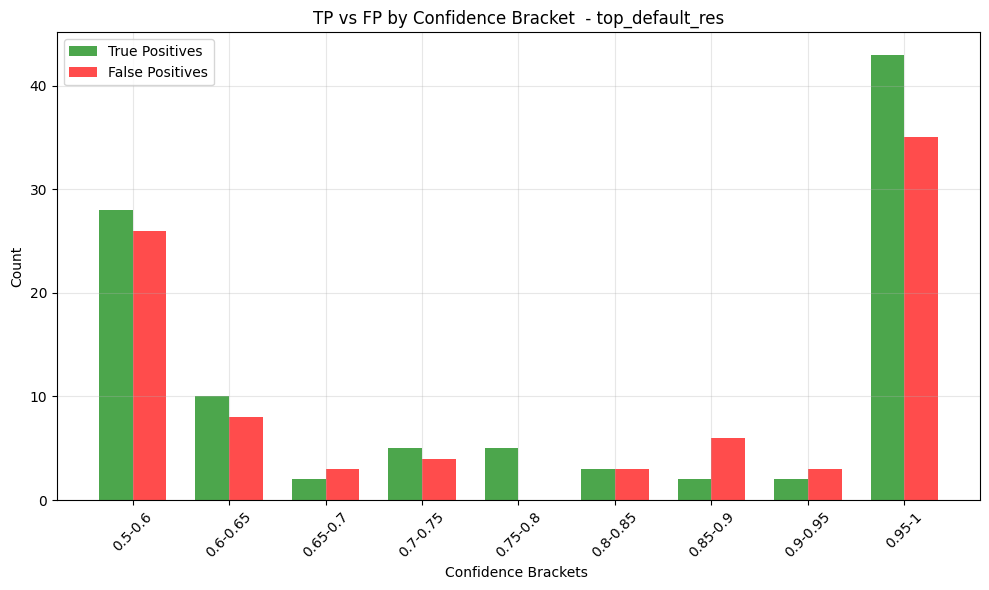

=================== top_custom_res_thresh_low fig ===================


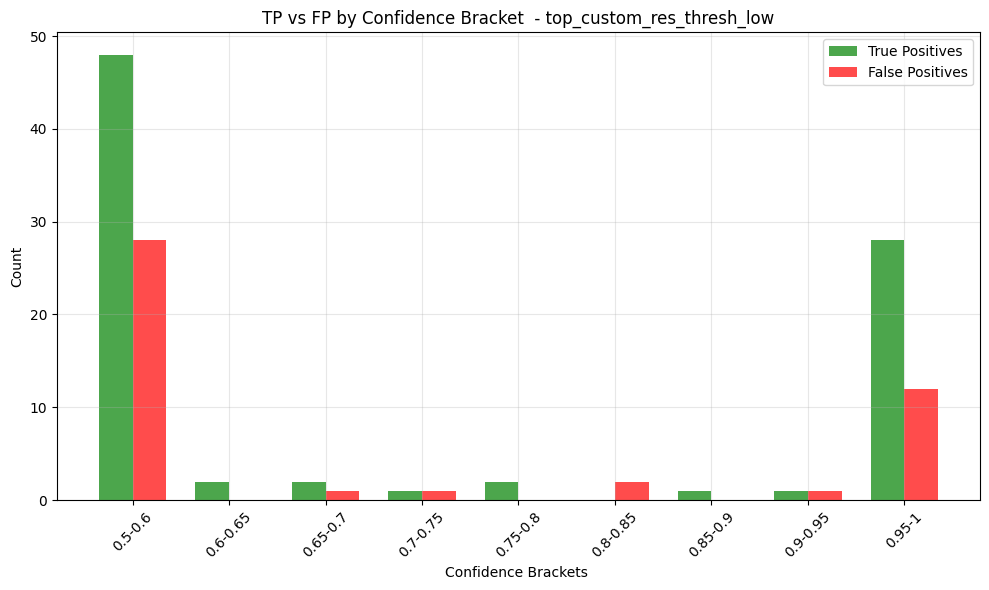

=================== top_custom_res_thresh_high fig ===================


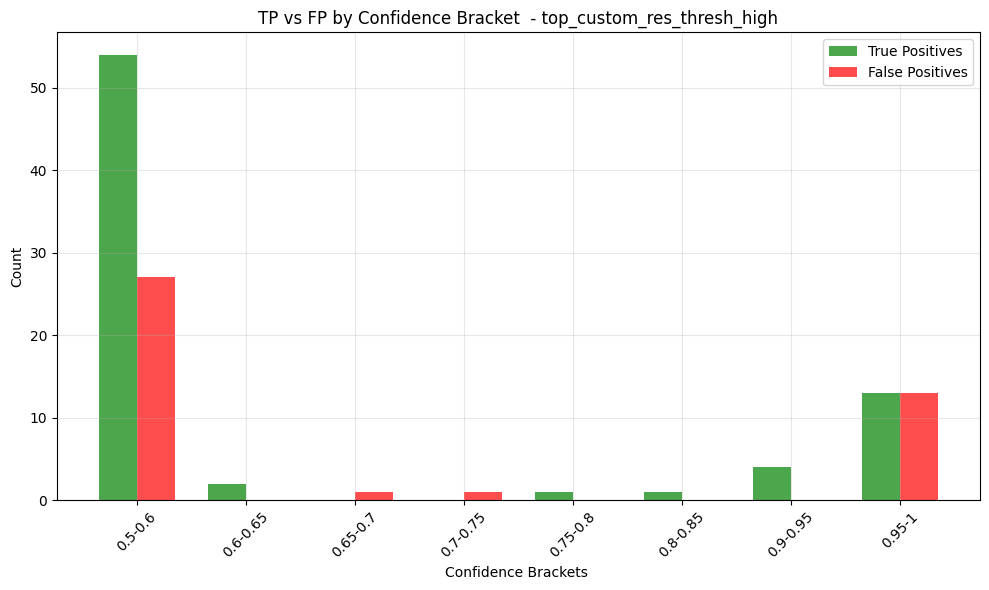

=================== top_custom_res_thresh_severity_1pt5 fig ===================


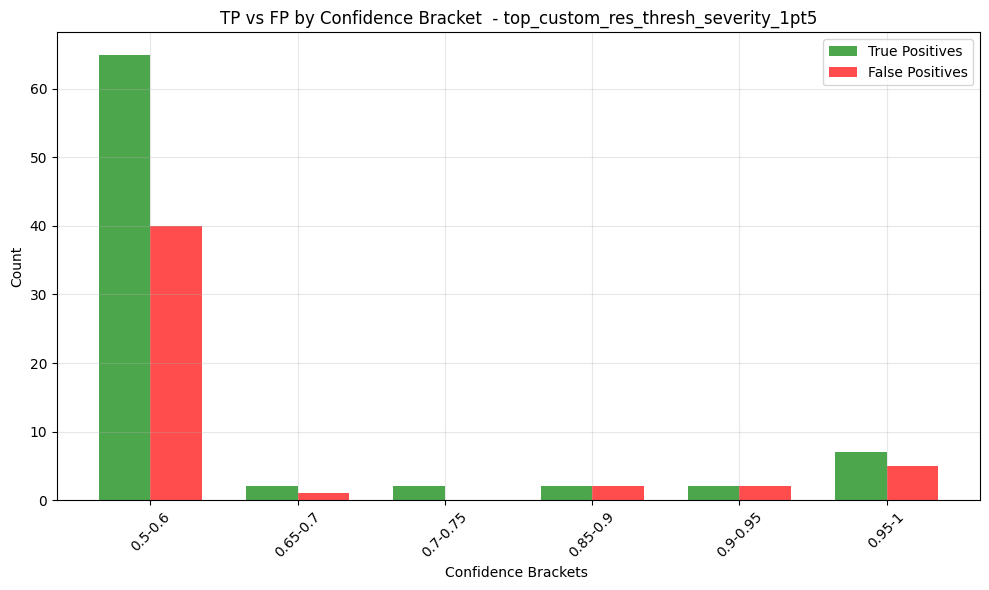

=================== top_custom_res_thresh_severity_2pt5 fig ===================


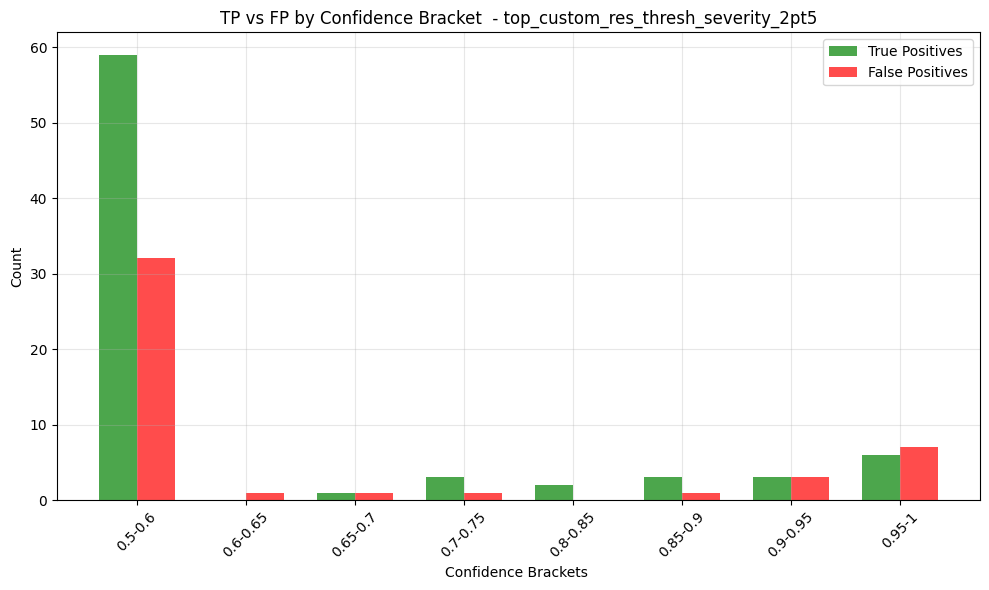

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Define confidence brackets
brackets = [(0.5, 0.6), (0.6, 0.65), (0.65, 0.7), (0.7, 0.75), 
            (0.75, 0.8), (0.8, 0.85), (0.85, 0.9), (0.9, 0.95), (0.95, 1)]


def TP_FP_brackets_analysis(top_models ,brackets , mdoel_name : str ):
        
    # Count TP and FP for each bracket
    bracket_counts = defaultdict(lambda: {'TP': 0, 'FP': 0})

    for score, entry in top_models:
        for pred_fold, actual_fold in zip(entry['all_preds'], entry['all_actuals']):
            for pred, actual in zip(pred_fold, actual_fold):
                if pred > 0.5:
                    for L, H in brackets:
                        if L < pred < H:
                            if actual > 0.5:
                                bracket_counts[f"{L}-{H}"]['TP'] += 1
                            else:
                                bracket_counts[f"{L}-{H}"]['FP'] += 1

    # Prepare data for plotting
    bracket_labels = sorted(bracket_counts.keys(), key=lambda x: float(x.split('-')[0]))
    tp_counts = [bracket_counts[b]['TP'] for b in bracket_labels]
    fp_counts = [bracket_counts[b]['FP'] for b in bracket_labels]

    # Create plot
    plt.figure(figsize=(10, 6))
    x = np.arange(len(bracket_labels))
    width = 0.35

    plt.bar(x - width/2, tp_counts, width, label='True Positives', color='green', alpha=0.7)
    plt.bar(x + width/2, fp_counts, width, label='False Positives', color='red', alpha=0.7)

    plt.xlabel('Confidence Brackets ')
    plt.ylabel('Count')
    plt.title(f'TP vs FP by Confidence Bracket  - {mdoel_name}')
    plt.xticks(x, bracket_labels, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



results = [top_default_res, top_custom_res_thresh_low, top_custom_res_thresh_high, top_custom_res_thresh_severity_1pt5, top_custom_res_thresh_severity_2pt5]
results_names = ['top_default_res', 'top_custom_res_thresh_low', 'top_custom_res_thresh_high', 'top_custom_res_thresh_severity_1pt5', 'top_custom_res_thresh_severity_2pt5']

for i, name in zip(results, results_names):
    print(f'=================== {name} fig ===================')
    TP_FP_brackets_analysis(i , brackets , name)


=================== top_default_res fig ===================


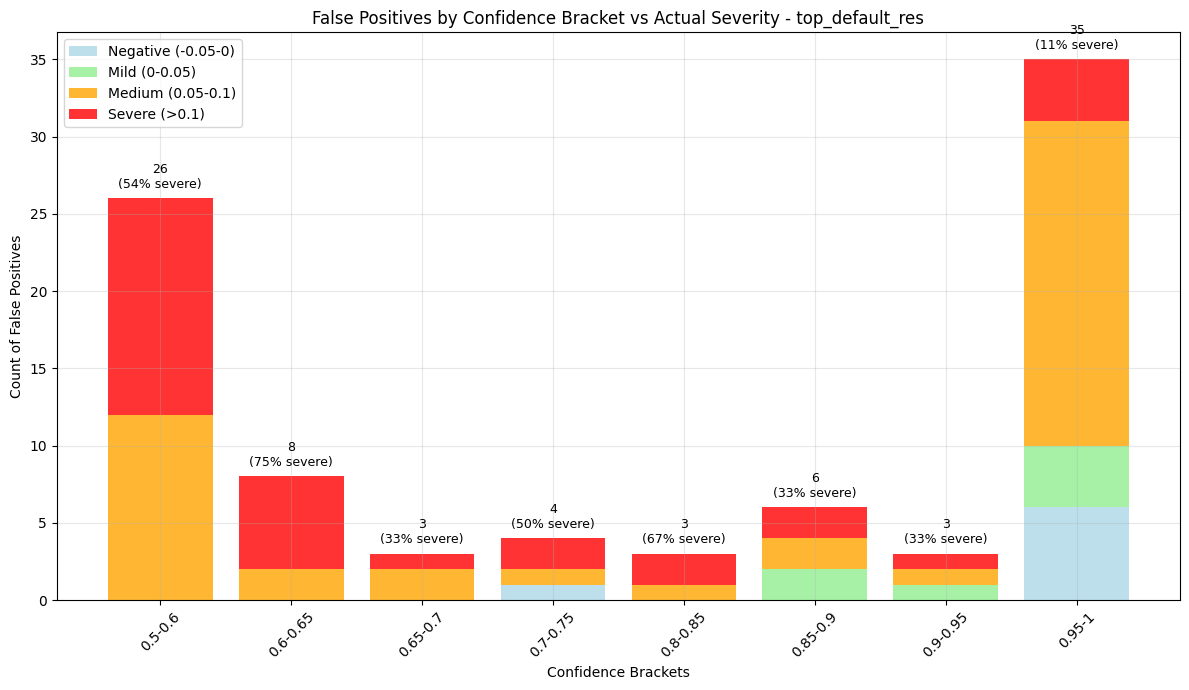

Severe Case Proportions by Confidence Bracket:
--------------------------------------------------
0.5-0.6: 53.8% severe (14/26)
0.6-0.65: 75.0% severe (6/8)
0.65-0.7: 33.3% severe (1/3)
0.7-0.75: 50.0% severe (2/4)
0.8-0.85: 66.7% severe (2/3)
0.85-0.9: 33.3% severe (2/6)
0.9-0.95: 33.3% severe (1/3)
0.95-1: 11.4% severe (4/35)
Severity Counts by Confidence Bracket:
--------------------------------------------------
0.5-0.6: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 12, 'Severe (>0.1)': 14}
0.6-0.65: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 2, 'Severe (>0.1)': 6}
0.65-0.7: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 2, 'Severe (>0.1)': 1}
0.7-0.75: {'Negative (-0.05-0)': 1, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 1, 'Severe (>0.1)': 2}
0.8-0.85: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 1, 'Severe (>0.1)': 2}
0.85-0.9: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 2, 'Medium (0.05-0.1)': 2,

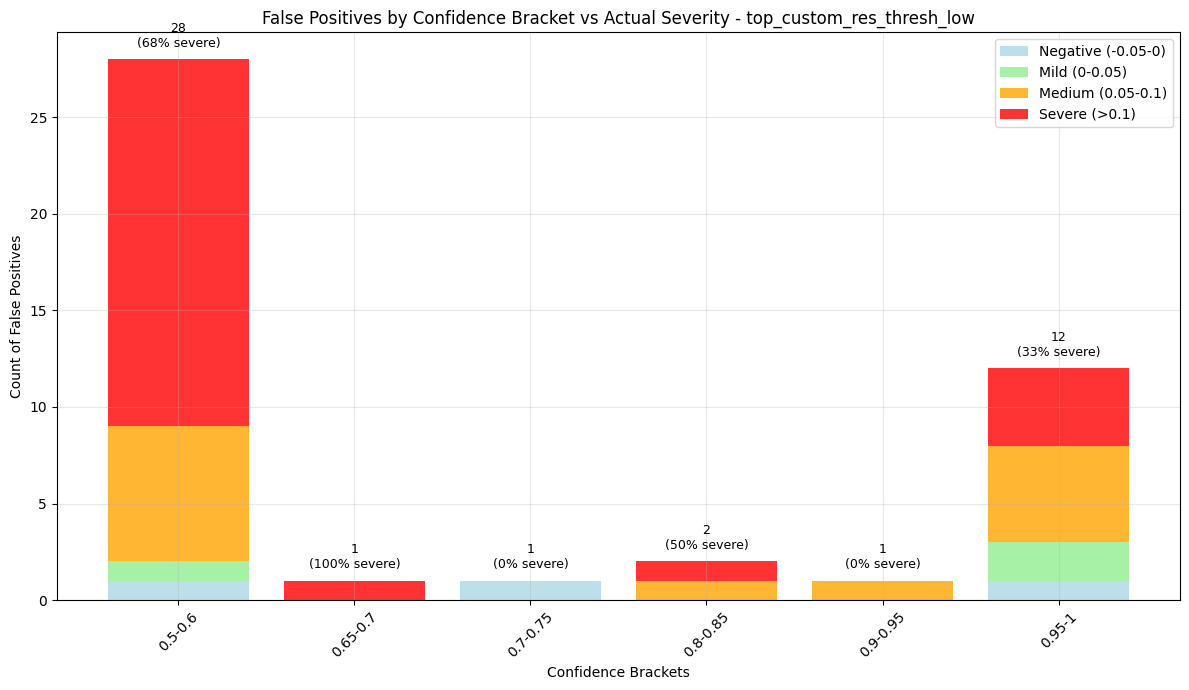

Severe Case Proportions by Confidence Bracket:
--------------------------------------------------
0.5-0.6: 67.9% severe (19/28)
0.65-0.7: 100.0% severe (1/1)
0.7-0.75: 0.0% severe (0/1)
0.8-0.85: 50.0% severe (1/2)
0.9-0.95: 0.0% severe (0/1)
0.95-1: 33.3% severe (4/12)
Severity Counts by Confidence Bracket:
--------------------------------------------------
0.5-0.6: {'Negative (-0.05-0)': 1, 'Mild (0-0.05)': 1, 'Medium (0.05-0.1)': 7, 'Severe (>0.1)': 19}
0.65-0.7: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 0, 'Severe (>0.1)': 1}
0.7-0.75: {'Negative (-0.05-0)': 1, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 0, 'Severe (>0.1)': 0}
0.8-0.85: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 1, 'Severe (>0.1)': 1}
0.9-0.95: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 1, 'Severe (>0.1)': 0}
0.95-1: {'Negative (-0.05-0)': 1, 'Mild (0-0.05)': 2, 'Medium (0.05-0.1)': 5, 'Severe (>0.1)': 4}
=================== top_custom_res_thresh

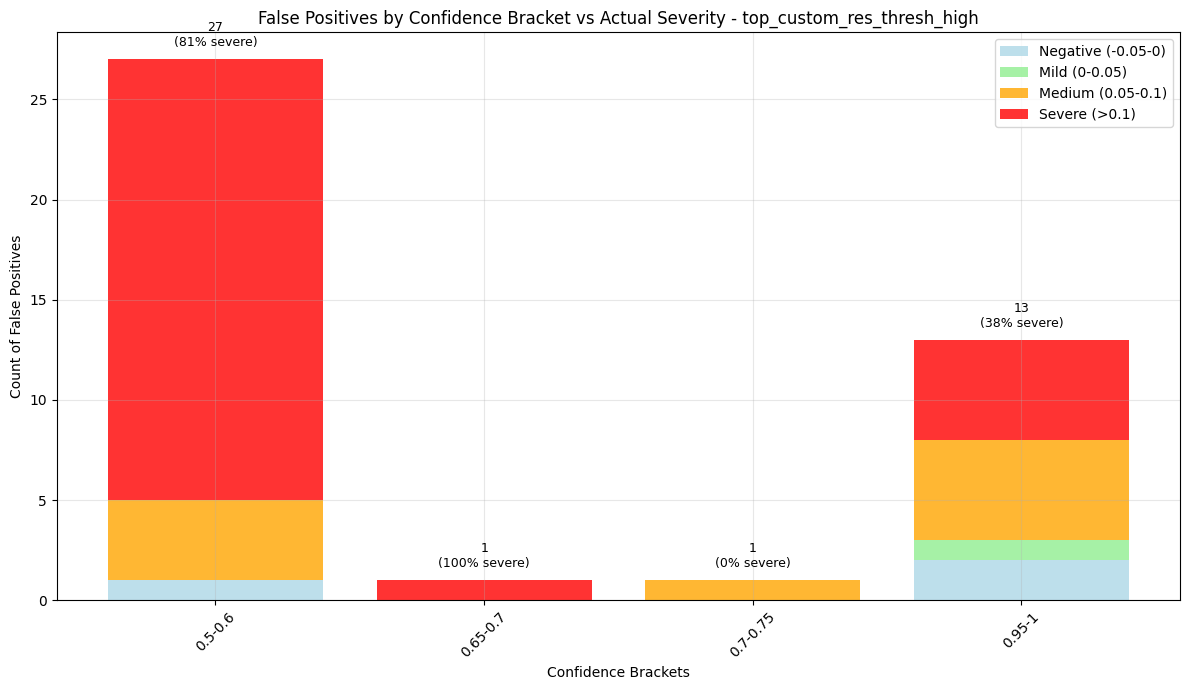

Severe Case Proportions by Confidence Bracket:
--------------------------------------------------
0.5-0.6: 81.5% severe (22/27)
0.65-0.7: 100.0% severe (1/1)
0.7-0.75: 0.0% severe (0/1)
0.95-1: 38.5% severe (5/13)
Severity Counts by Confidence Bracket:
--------------------------------------------------
0.5-0.6: {'Negative (-0.05-0)': 1, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 4, 'Severe (>0.1)': 22}
0.65-0.7: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 0, 'Severe (>0.1)': 1}
0.7-0.75: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 1, 'Severe (>0.1)': 0}
0.95-1: {'Negative (-0.05-0)': 2, 'Mild (0-0.05)': 1, 'Medium (0.05-0.1)': 5, 'Severe (>0.1)': 5}
=================== top_custom_res_thresh_severity_1pt5 fig ===================


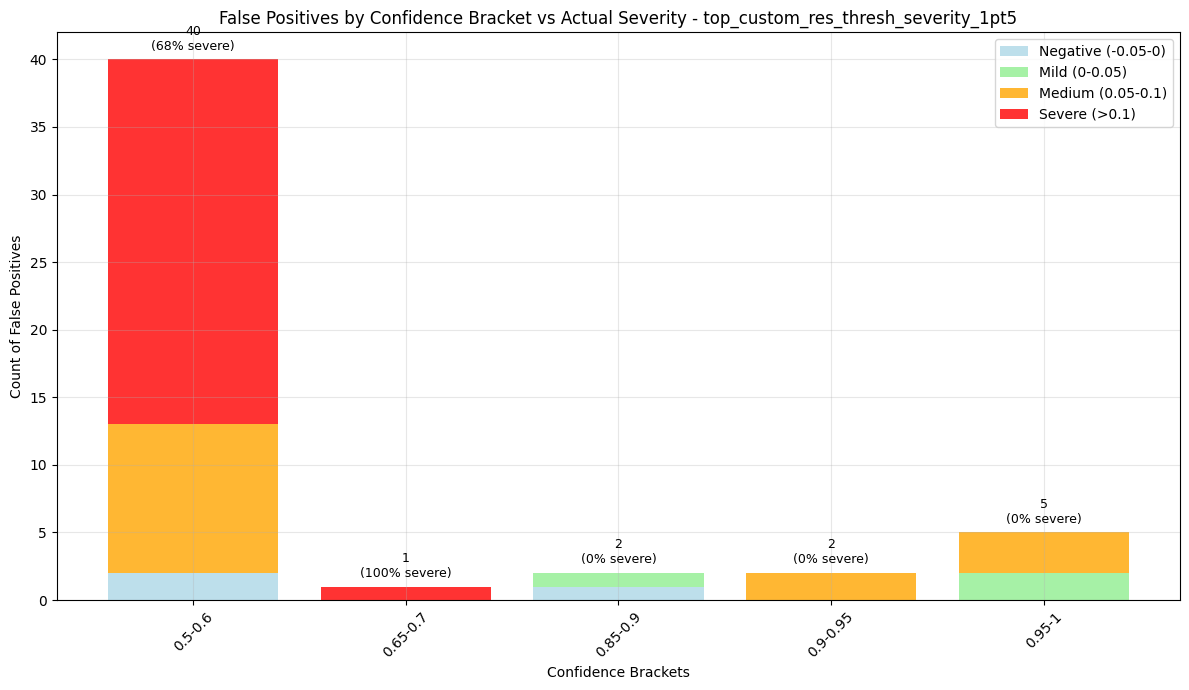

Severe Case Proportions by Confidence Bracket:
--------------------------------------------------
0.5-0.6: 67.5% severe (27/40)
0.65-0.7: 100.0% severe (1/1)
0.85-0.9: 0.0% severe (0/2)
0.9-0.95: 0.0% severe (0/2)
0.95-1: 0.0% severe (0/5)
Severity Counts by Confidence Bracket:
--------------------------------------------------
0.5-0.6: {'Negative (-0.05-0)': 2, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 11, 'Severe (>0.1)': 27}
0.65-0.7: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 0, 'Severe (>0.1)': 1}
0.85-0.9: {'Negative (-0.05-0)': 1, 'Mild (0-0.05)': 1, 'Medium (0.05-0.1)': 0, 'Severe (>0.1)': 0}
0.9-0.95: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 2, 'Severe (>0.1)': 0}
0.95-1: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 2, 'Medium (0.05-0.1)': 3, 'Severe (>0.1)': 0}
=================== top_custom_res_thresh_severity_2pt5 fig ===================


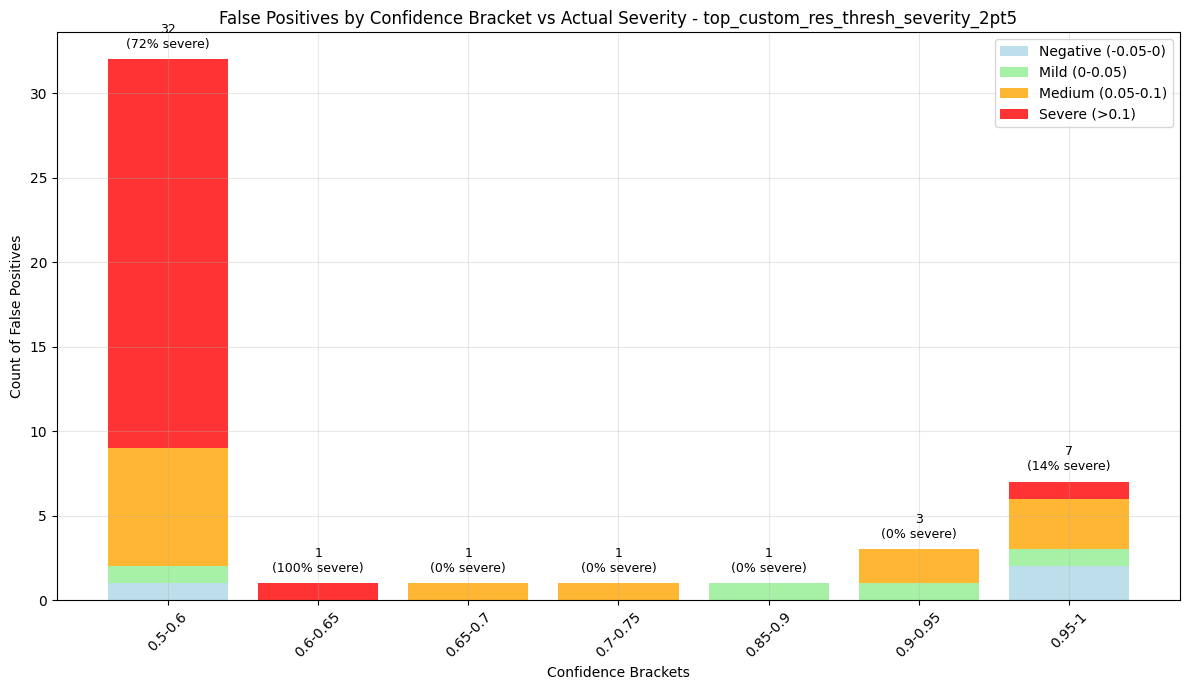

Severe Case Proportions by Confidence Bracket:
--------------------------------------------------
0.5-0.6: 71.9% severe (23/32)
0.6-0.65: 100.0% severe (1/1)
0.65-0.7: 0.0% severe (0/1)
0.7-0.75: 0.0% severe (0/1)
0.85-0.9: 0.0% severe (0/1)
0.9-0.95: 0.0% severe (0/3)
0.95-1: 14.3% severe (1/7)
Severity Counts by Confidence Bracket:
--------------------------------------------------
0.5-0.6: {'Negative (-0.05-0)': 1, 'Mild (0-0.05)': 1, 'Medium (0.05-0.1)': 7, 'Severe (>0.1)': 23}
0.6-0.65: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 0, 'Severe (>0.1)': 1}
0.65-0.7: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 1, 'Severe (>0.1)': 0}
0.7-0.75: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 0, 'Medium (0.05-0.1)': 1, 'Severe (>0.1)': 0}
0.85-0.9: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 1, 'Medium (0.05-0.1)': 0, 'Severe (>0.1)': 0}
0.9-0.95: {'Negative (-0.05-0)': 0, 'Mild (0-0.05)': 1, 'Medium (0.05-0.1)': 2, 'Severe (>0.1)': 0}
0.95-1: {'Neg

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Define confidence brackets
brackets = [(0.5, 0.6), (0.6, 0.65), (0.65, 0.7), (0.7, 0.75), 
            (0.75, 0.8), (0.8, 0.85), (0.85, 0.9), (0.9, 0.95), (0.95, 1)]

def classify_severity(actual_value):
    if 0 >= actual_value >= -0.05:
        return "Negative (-0.05-0)"
    elif 0 < actual_value <= 0.05:
        return "Mild (0-0.05)"
    elif 0.05 < actual_value <= 0.1:
        return "Medium (0.05-0.1)"
    elif actual_value > 0.1:
        return "Severe (>0.1)"



def TP_FP_brackets_severity_analysis(top, brackets , name : str ):

    # Count FP severity by bracket
    bracket_severity_counts = defaultdict(lambda: {
        'Negative (-0.05-0)': 0,
        'Mild (0-0.05)': 0, 
        'Medium (0.05-0.1)': 0,
        'Severe (>0.1)': 0
    })



    for score, entry in top:
        all_preds = entry['all_preds']
        all_actuals = entry['all_actuals']
        raw_actuals = entry['raw_actuals']
        
        # Flatten all arrays
        flat_preds = [p for fold in all_preds for p in fold]
        flat_actuals = [a for fold in all_actuals for a in fold]
        flat_raw_actuals = [r for fold in raw_actuals for r in fold]
        
        for p, a, raw in zip(flat_preds, flat_actuals, flat_raw_actuals):
            # Only process FALSE POSITIVES
            if p > 0.5 and a < 0.5:
                severity = classify_severity(raw)
                
                # Find which bracket this prediction falls into
                for L, H in brackets:
                    if L < p < H:
                        bracket_severity_counts[f"{L}-{H}"][severity] += 1
                        break

    # Prepare data for plotting
    bracket_labels = sorted(bracket_severity_counts.keys(), key=lambda x: float(x.split('-')[0]))
    severity_categories = ["Negative (-0.05-0)", "Mild (0-0.05)", "Medium (0.05-0.1)", "Severe (>0.1)"]

    # Create the stacked bar plot
    plt.figure(figsize=(12, 7))
    x = np.arange(len(bracket_labels))
    width = 0.8
    bottom = np.zeros(len(bracket_labels))

    colors = ['lightblue', 'lightgreen', 'orange', 'red']

    for i, category in enumerate(severity_categories):
        counts = [bracket_severity_counts[b][category] for b in bracket_labels]
        plt.bar(x, counts, width, bottom=bottom, label=category, alpha=0.8, color=colors[i])
        bottom += counts

    plt.xlabel('Confidence Brackets')
    plt.ylabel('Count of False Positives')
    plt.title(f'False Positives by Confidence Bracket vs Actual Severity - {name}')
    plt.xticks(x, bracket_labels, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add total counts and severity proportions on top
    for i, bracket in enumerate(bracket_labels):
        total = sum(bracket_severity_counts[bracket].values())
        severe_count = bracket_severity_counts[bracket]['Severe (>0.1)']
        severe_proportion = (severe_count / total * 100) if total > 0 else 0
        
        plt.text(i, total + 0.5, f"{total}\n({severe_proportion:.0f}% severe)", 
                ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    # Print severity proportion analytics
    print("Severe Case Proportions by Confidence Bracket:")
    print("-" * 50)
    for bracket in bracket_labels:
        total = sum(bracket_severity_counts[bracket].values())
        severe_count = bracket_severity_counts[bracket]['Severe (>0.1)']
        severe_proportion = (severe_count / total * 100) if total > 0 else 0
        
        print(f"{bracket}: {severe_proportion:.1f}% severe ({severe_count}/{total})")

    print("Severity Counts by Confidence Bracket:")
    print("-" * 50)
    for bracket in bracket_labels:
        print(f"{bracket}: {bracket_severity_counts[bracket]}")



results = [top_default_res, top_custom_res_thresh_low, top_custom_res_thresh_high, top_custom_res_thresh_severity_1pt5, top_custom_res_thresh_severity_2pt5]
results_names = ['top_default_res', 'top_custom_res_thresh_low', 'top_custom_res_thresh_high', 'top_custom_res_thresh_severity_1pt5', 'top_custom_res_thresh_severity_2pt5']

for i, name in zip(results, results_names):
    print(f'=================== {name} fig ===================')
    TP_FP_brackets_severity_analysis(i, brackets , name)

---
# TESTING
---

In [ ]:
from Equations_Run_Combo_V_2 import *
import copy
###                             FIRST

import itertools
import math 
from joblib import parallel_backend , Parallel , delayed 
import random 

######    GS 

param_grid = {
    "learning_rate": [0.05, 0.005, 0.0005],
    "num_epochs": [ 70, 150, 300, 700],
    "batch_size": [10, 30, 50],
    "use_bidirectional": [False],
    "lag": [ 2, 3, 6],
    "input_size": [12],
    "hidden_size": [ 12, 20, 35, 55],
    "num_layers": [1, 2, 4 , 6],
                                            "use_monthly_dfs_only": [True],
    
                                            "use_binary_0_1": [False],
    "use_binary_neg1_1": [False],  # still to be investigated
    "use_ret_rate": [False],       # still to be investigated
    "use_print_acc": [False],      # still to be investigated
    "use_dropout": [False],  # still to be investigated
    # "iter_per_valSET": [1],        # still to be investigated
    "use_class_weighting": [True],
    # missing params 
    "is_deterministic": [True],     
    "seed_num": [42],       


    "use_monthly_predictor": [False],
    
    "use_existing_lagged_data": [True],
    'use_dynamic_weights' : [False] ,

########################################################################################

    'use_monthly_daily_end_mo_predictor' : [False], 
    'use_monthly_weekly_end_mo_predictor' : [True]  ,  

    'use_binary_0_1_custom_neg' : [True] ,
    'use_binary_0_1_custom_pos' : [False] ,
    
    'binary_0_1_cutoff_ret_rate_percentage' : [.05],  ### cutoff for the  use_binary_0_1_custom_pos ot use_binary_0_1_custom_neg
    'end_value_train_set_fraction' : [0.85], 
    'val_set_fraction' : [0.1], 
    'num_folds' : [8]  , 
    'POS_weight_multiplier' : [1] , ## 24 vals is val set, 3 units per ser fi folds are 8 
    'use_rolling_fixed_train_size' : [False,True],
    'use_existing_initial_weights': [False], 
    'state_dict' : [None]
        
        }   


# --- Prepare all combinations ---
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]


def random_subset( data , seed = 42 ) :
    random.seed(seed)
    n_keep = int(len(data))
    return random.sample(data, n_keep)


# --- Split combinations into chunks ---
def split_into_chunks(lst, n_chunks):
    chunk_size = len(lst) // n_chunks
    chunks = []
    for i in range(n_chunks):
        start = i * chunk_size
        end = (i + 1) * chunk_size if i < n_chunks - 1 else len(lst)
        chunks.append(lst[start:end])
    return chunks


random_subset_combos = random_subset(combinations, seed=42)
random_subset_combos_short = random_subset_combos[:400]


random_subset_combos_short_custom_THRESH_and_SEVERITY = []


for param in copy.deepcopy(random_subset_combos_short):
        
    param['use_custom_loss_function_BCE_THRESH'] =  False # NEW NEW NEW
    param['use_custom_loss_function_BCE_THRESH_AND_SEVERITY'] = True # NEW NEW NEW
    param['use_LOW_weights_for_BCE_custom_loss'] = True # NEW NEW NEW
    param['pred_threshold_sigmoid01_up'] = None # NEW NEW NEW

    random_subset_combos_short_custom_THRESH_and_SEVERITY.append(param)



# cc = { 'learning_rate': 0.05 , 'num_epochs': 7, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 55, 'num_layers': 1, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': True, 'is_deterministic': True, 'seed_num': 414, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.10, 'num_folds': 8, 'POS_weight_multiplier': 1, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None,

#                 'use_custom_loss_function_BCE_THRESH': False, # NEW NEW NEW
#                 'use_custom_loss_function_BCE_THRESH_AND_SEVERITY': True, # NEW NEW NEW
#                 'use_LOW_weights_for_BCE_custom_loss': True, # NEW NEW NEW
#                 'pred_threshold_sigmoid01_up': None } # NEW NEW NEW



with parallel_backend("loky", n_jobs=-1):
    results = Parallel()(
        delayed(run_combo_V_3)(i, combo, total_offset = 0, use_print_acc_vs_pred=False , pred_threshold_sigmoid01_up_bool = None )
        for i, combo in enumerate(random_subset_combos_short_custom_THRESH_and_SEVERITY)
    )

--- Running Combo 2 ---Parameters: {'learning_rate': 0.05, 'num_epochs': 150, 'batch_size': 30, 'use_bidirectional': False, 'lag': 6, 'input_size': 12, 'hidden_size': 20, 'num_layers': 1, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': False, 'use_class_weighting': True, 'is_deterministic': True, 'seed_num': 42, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.1, 'num_folds': 8, 'POS_weight_multiplier': 1, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None, 'use_custom_loss_function_BCE_THRESH': False, 'use_custom_loss_function_BCE_THRE

KeyboardInterrupt: 

In [ ]:
from Equations_Run_Combo_V_2 import *
import copy
###                             FIRST

import itertools
import math 
from joblib import parallel_backend , Parallel , delayed 
import random 

######    GS 

param_grid = {
    "learning_rate": [0.05, 0.005, 0.0005],
    "num_epochs": [ 70, 150, 300, 700],
    "batch_size": [10, 30, 50],
    "use_bidirectional": [False],
    "lag": [ 2, 3, 6],
    "input_size": [12],
    "hidden_size": [ 12, 20, 35, 55],
    "num_layers": [1, 2, 4 , 6],
                                            "use_monthly_dfs_only": [True],
    
                                            "use_binary_0_1": [False],
    "use_binary_neg1_1": [False],  # still to be investigated
    "use_ret_rate": [False],       # still to be investigated
    "use_print_acc": [False],      # still to be investigated
    "use_dropout": [False],  # still to be investigated
    # "iter_per_valSET": [1],        # still to be investigated
    "use_class_weighting": [True],
    # missing params 
    "is_deterministic": [True],     
    "seed_num": [42],       


    "use_monthly_predictor": [False],
    
    "use_existing_lagged_data": [True],
    'use_dynamic_weights' : [False] ,

########################################################################################

    'use_monthly_daily_end_mo_predictor' : [False], 
    'use_monthly_weekly_end_mo_predictor' : [True]  ,  

    'use_binary_0_1_custom_neg' : [True] ,
    'use_binary_0_1_custom_pos' : [False] ,
    
    'binary_0_1_cutoff_ret_rate_percentage' : [.05],  ### cutoff for the  use_binary_0_1_custom_pos ot use_binary_0_1_custom_neg
    'end_value_train_set_fraction' : [0.85], 
    'val_set_fraction' : [0.1], 
    'num_folds' : [8]  , 
    'POS_weight_multiplier' : [1] , ## 24 vals is val set, 3 units per ser fi folds are 8 
    'use_rolling_fixed_train_size' : [False,True],
    'use_existing_initial_weights': [False], 
    'state_dict' : [None]
        
        }   


# --- Prepare all combinations ---
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]


def random_subset( data , seed = 42 ) :
    random.seed(seed)
    n_keep = int(len(data))
    return random.sample(data, n_keep)


# --- Split combinations into chunks ---
def split_into_chunks(lst, n_chunks):
    chunk_size = len(lst) // n_chunks
    chunks = []
    for i in range(n_chunks):
        start = i * chunk_size
        end = (i + 1) * chunk_size if i < n_chunks - 1 else len(lst)
        chunks.append(lst[start:end])
    return chunks


random_subset_combos = random_subset(combinations, seed=42)
random_subset_combos_short = random_subset_combos[:400]


random_subset_combos_short_custom_THRESH_and_SEVERITY = []


for param in copy.deepcopy(random_subset_combos_short):
        
    param['use_custom_loss_function_BCE_THRESH'] =  True # NEW NEW NEW
    param['use_custom_loss_function_BCE_THRESH_AND_SEVERITY'] = False # NEW NEW NEW
    param['use_LOW_weights_for_BCE_custom_loss'] = False # NEW NEW NEW
    param['pred_threshold_sigmoid01_up'] = None # NEW NEW NEW

    random_subset_combos_short_custom_THRESH_and_SEVERITY.append(param)



# cc = { 'learning_rate': 0.05 , 'num_epochs': 7, 'batch_size': 50, 'use_bidirectional': False, 'lag': 3, 'input_size': 12, 'hidden_size': 55, 'num_layers': 1, 'use_monthly_dfs_only': True, 'use_binary_0_1': False, 'use_binary_neg1_1': False, 'use_ret_rate': False, 'use_print_acc': False, 'use_dropout': True, 'use_class_weighting': True, 'is_deterministic': True, 'seed_num': 414, 'use_monthly_predictor': False, 'use_existing_lagged_data': True, 'use_dynamic_weights': False, 'use_monthly_daily_end_mo_predictor': False, 'use_monthly_weekly_end_mo_predictor': True, 'use_binary_0_1_custom_neg': True, 'use_binary_0_1_custom_pos': False, 'binary_0_1_cutoff_ret_rate_percentage': 0.05, 'end_value_train_set_fraction': 0.85, 'val_set_fraction': 0.10, 'num_folds': 8, 'POS_weight_multiplier': 1, 'use_rolling_fixed_train_size': False, 'use_existing_initial_weights': False, 'state_dict': None,

#                 'use_custom_loss_function_BCE_THRESH': False, # NEW NEW NEW
#                 'use_custom_loss_function_BCE_THRESH_AND_SEVERITY': True, # NEW NEW NEW
#                 'use_LOW_weights_for_BCE_custom_loss': True, # NEW NEW NEW
#                 'pred_threshold_sigmoid01_up': None } # NEW NEW NEW



with parallel_backend("loky", n_jobs=-1):
    results_2 = Parallel()(
        delayed(run_combo_V_3)(i, combo, total_offset = 0, use_print_acc_vs_pred=False , pred_threshold_sigmoid01_up_bool = None )
        for i, combo in enumerate(random_subset_combos_short_custom_THRESH_and_SEVERITY)
    )



import json

r_2, w_2 = zip(*results_2)


class numpy_encoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(numpy_encoder, self).default(obj)


with open('/home/charifslmn/GC_thresh_analysis_400_combos_CUSTOM_LOSS_THRESH_HIGH_penalization.json', 'w') as f:
    json.dump(r_2, f, cls=numpy_encoder)